# 1. Setup

In [13]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
%autoreload 2
import json
import logging
import os
from datetime import datetime
from pathlib import Path

import pandas as pd
import regex as re
import typer
from dateutils import relativedelta
from unidecode import unidecode

from analysis.config import *
from analysis.preprocessing import map_progress, tokenizer_lemma
from analysis.utils import *
from src.custom_logger import get_logger

# Removendo aviso de debug
os.environ["PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT"] = "3000"
# Removendo limitação de print de dfs
# pd.set_option("display.max_rows", 500)
# pd.set_option("display.max_columns", 500)
# pd.set_option("display.width", 1000)

# Caminho da pasta contendo os csvs
data_path = "data/2023/01/19/"
places_file = "data/places.csv"
input_file = "input/hotels_23_01_19.csv"
reports_folder = Path("./reports")
Path(reports_folder).mkdir(exist_ok=True)
data_folder = Path("./data/prep")
Path(data_folder).mkdir(exist_ok=True)


In [15]:
from tqdm import tqdm
tqdm.pandas()

In [16]:
from itertools import chain

join_str = lambda x: "\n".join(list(x)) if x is not None else ""
join_list = lambda x: list(chain.from_iterable(x))

# 2. Load

In [17]:
df_prep = pd.read_parquet("data/prep/df_text_prep_2023-06-22_20-52-11_175568.pq")
df_hotels = pd.read_parquet("data/prep/df_hotels_2023-06-22_20-52-11_175568.pq")

In [18]:
df_hotels = pd.read_parquet("data/prep/df_hotels_2023-06-22_20-52-11_175568.pq")

In [19]:
import numpy as np

# Review level documents
df_prep["text_na"] = (df_prep.text == '') | (df_prep.text.isna())
text_tokens_flat = df_prep[(~df_prep["text_na"])].text_tokens.apply(join_list)
df_prep.loc[(~df_prep["text_na"]),"text_tokens_flat"] = text_tokens_flat

# Hotel level documents
# text_tokens_flat = df_hotels.text_tokens_sum.apply(join_list)

text_tokens_flat.shape

(150774,)

In [20]:
text_tokens_flat.head()

0    [bom, preco, otima, localizacao, atendimento, ...
1    [nunca, quarto, hotel, tao, sujo, vida, lencol...
2    [hotel, baixissima, qualidad, atendimento, aco...
3    [pessimo, atendimento, classico, rio, janeiro,...
6    [experiencia, nao, boa, ness, hotel, propagand...
Name: text_tokens, dtype: object

# Usar análise de sentimentos de Transformers

# 3. Vader Sentiment Analysis

In [ ]:
from analysis.leia.leia import SentimentIntensityAnalyzer 

vader_model = SentimentIntensityAnalyzer()

# Análise de texto simples
vader_model.polarity_scores('Eu estou feliz')

def get_vader_sentiment(text, prefix = "vader_"):
    sentiments = vader_model.polarity_scores(text)
    sentiments = pd.Series(sentiments)
    return sentiments.add_prefix(prefix)

get_vader_sentiment('Eu estou feliz')

vader_neg         0.0000
vader_neu         0.3280
vader_pos         0.6720
vader_compound    0.6249
dtype: float64

In [ ]:
df_prep.filter(regex="^text").sample(2)

,text,text_is_other_language,text_tokens,text_tokens_len,text_normalized,text_na,text_tokens_flat
254650,,None,[[]],1,,True,NaN
124263,"Tudo maravilhoso, equipe sensacional, Davi ate...",False,"[[tudo, maravilhoso, equip, sensacion, davi, a...",3,"tudo maravilhoso, equipe sensacional, davi ate...",False,"[tudo, maravilhoso, equip, sensacion, davi, at..."


In [ ]:
vader_sentiments = df_prep.text.progress_apply(get_vader_sentiment)

  0%|          | 45/270097 [00:00<10:04, 446.74it/s]

100%|██████████| 270097/270097 [03:18<00:00, 1359.76it/s]


In [ ]:
df_prep[vader_sentiments.columns] = vader_sentiments

In [ ]:
df_prep.filter(regex="^vader|^text").sample(2)

,text,text_is_other_language,text_tokens,text_tokens_len,text_normalized,text_na,text_tokens_flat,vader_neg,vader_neu,vader_pos,vader_compound
129142,"Carol Anne e Jasy.Eles são nota 10. Stéfany, A...",False,"[[carol, ann, jasi], [sao, nota], [stefani, ad...",3,"carol anne e jasy.eles sao nota 10. stefany, a...",False,"[carol, ann, jasi, sao, nota, stefani, adriano]",0.0,1.000,0.000,0.0000
162550,Sempre q vou almoço muito bem e sou muito bem ...,False,"[[sempr, vou, almoco, bem, bem, atendido]]",1,sempre q vou almoco muito bem e sou muito bem ...,False,"[sempr, vou, almoco, bem, bem, atendido]",0.0,0.609,0.391,0.5411


In [ ]:
save_df(df_prep, "data/processed", "df_sentiments")

data/processed/df_sentiments_2023-07-10_09-48-22_879161.pq


In [ ]:
df_prep = pd.read_parquet("data/processed/df_sentiments_2023-07-10_09-48-22_879161.pq")

In [ ]:
df_sentiments = df_prep.groupby("name").vader_compound.mean().sort_values()

In [ ]:
df_hotels = df_hotels.merge(df_sentiments, on="name", how="left")

In [ ]:
df_count = pd.read_parquet("data/processed/df_count_2023-07-10_10-41-45_748531.pq")

In [ ]:
df_count = df_count.merge(df_sentiments, on="name", how="left")

<AxesSubplot:xlabel='vader_compound', ylabel='overall_rating'>

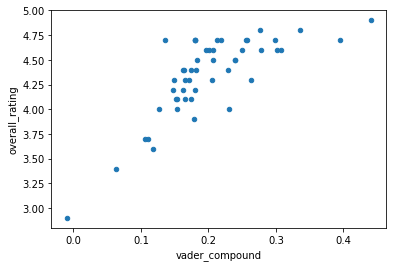

In [ ]:
df_count.plot.scatter(x="vader_compound",y="overall_rating")

In [ ]:
df_count[["name","vader_compound","stars","overall_rating"]].sort_values("overall_rating",ascending=False)

,name,vader_compound,stars,overall_rating
26,Hotel Fioreze Quero Quero,0.440994,3,4.9
45,Wish Foz do Iguaçu,0.335648,5,4.8
44,Vivá Porto De Galinhas Resort,0.277092,4,4.8
11,Copacabana Palace,0.135150,5,4.7
28,Hotel Jequitimar Guarujá Resort & SPA by Accor,0.179968,5,4.7
18,Grand Palladium Imbassaí Resort & Spa,0.394528,5,4.7
41,Royal Tulip Brasília Alvorada,0.213362,5,4.7
13,Costão do Santinho Resort,0.180668,4,4.7
1,Aroso Paço Hotel,0.256321,5,4.7
0,Acqua Lokos,0.179958,3,4.7


# Modelagem

In [ ]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
# hotel_texts = df_hotels.text_sum.str.replace(".", ";").str.replace("\n", ".")
df_hotels["text_sum_"] = df_hotels.text_sum.progress_apply(lambda x: re.sub(r"\n", ".", re.sub(r"[.]", ";", x)))


100%|██████████| 50/50 [00:00<00:00, 263.53it/s]


In [27]:
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
from collections import Counter
from tqdm import tqdm

# Carregar o modelo em português do spaCy
nlp = spacy.load('pt_core_news_lg')

In [30]:
nlp.max_length = 3536134

In [31]:
# Tokenizar o texto em frases e palavras usando o spaCy
print("text_nlp")
df_hotels["text_nlp"] = df_hotels.text_sum_.progress_apply(lambda x: nlp(x))


text_nlp


100%|██████████| 50/50 [08:23<00:00, 10.06s/it]


In [36]:
print("text_words")
df_hotels["text_words"] = df_hotels.text_nlp.progress_apply(lambda x: [token.text for token in x if not token.is_stop and token.is_alpha])


text_words


100%|██████████| 50/50 [00:01<00:00, 49.49it/s]


In [37]:
print("text_counters")
df_hotels["text_counters"] = df_hotels.text_words.progress_apply(lambda x: Counter(x))


text_counters


100%|██████████| 50/50 [00:00<00:00, 318.09it/s]


In [35]:
print("text_sentences")
df_hotels["text_sentences"] = df_hotels.text_nlp.progress_apply(lambda x: [sent.text for sent in x.sents])

text_sentences


100%|██████████| 50/50 [00:02<00:00, 24.09it/s]


In [44]:
save_df(df_hotels, "data/processed", "df_hotels_nlp")

data/processed/df_hotels_nlp_2023-07-10_11-13-12_148931.pq


ArrowInvalid: ('Could not convert O parque tá muito ruim,desde a entrada!Piscinas da área coberta que deveriam ser aquecidas,estão mais geladas que as ao ar livre,filas em todos os brinquedos ,falta de monitor,falta de higiene geral,valor da alimentação exorbitante ;  . Fui com minha familia, adoramos todas as atrações, recomendo ;  . Top de mais! Porém se tivesse uma piscina padrão para poder ficar de molho seria mais top ainda kkkkk . Lugar incrível, tem divulgação pra gurizada e para não tão guris  ;  . Se vc procura por um park só com picina, esse nao é o ideal, pq ele tem muitas coisas, piscinas e atividades ao ar livre ;  Eu gosto bastante, mais vai depender do que vc está procurando! Tem bastante coisa pra fazer ;  Só a picina quente que de quente nao tinha nada ksksk fora isso, foi um dia legal . Comidas e bebidas: Tudo muitoooo caro,mas de qualidade Serviço . O local é muito bom, mas a demora para acessar os brinquedos mesmo em dia de semana é para não retornar ;  . Melhor férias em família que tivemos ;  Levem água e petiscos para comer durante o dia, o almoço é maravilhoso, porém bem caro, 120 o kg, buffet de sorvete é muito caro, não vale a pena, comprem pizza e crepe que é mais barato e bem gostoso Serviço . Ótimo local para se divertir ;  Funcionários receptivos ;  Local organizado e limpo ;  Ótimas atrações ;  Para quem gosta de água, é uma excelente opção ;  Segurança: Estacionamento interno com pessoal cuidando e organizando tudo ;  Comidas e bebidas: Restaurantes, carros de fast food e banheiros espalhados por todo o parque ;  . Lugar fantástico, diversão para todos os gostos e tamanhos ;  Excelente atendimento e pessoas super comprometidas no que fazem ;  Recomendo!!! . Muito bom lugar ;  Recomendado para toda a família ;  Os jogos são muito bons ;  . Péssimo custo benefício ;  Um restaurante com buffet 100 reais ;  Coloca uma alface já pesa! Absurdo! Tem parques melhores ;  . Amamos a experiência, voltaremos sem dúvida!! . O pequeno é muito bom 5 estrelas ;  Traga comida, comer aqui é caro e não muito bom, a atenção de todos é excelente . Foi bom, mas lá dentro a comida é muito cara, abre muito tarde e fecha cedo e agente demora muito nos brinquedos ;  . Muito bom ; porém muito lotado numa quinta feira ; e apesar da experiência ; pareciam não esperar tanta gente ; ficou meio bagunçado!!! . Muito bem organizado ;  Piscinas limpas ;  Podem levar coisas para comer ou deêm uma boa pesquisada nos valores ;  os lanches valem mais a pena ;  O Restaurante Dallagnol tem um buffet com bastante variedade, mas a comida é razoável e o preço absurdamente caro ;  Tem guarda volumes no valor de 20,00, bastante cadeira e sombra para sentar ;  . Muitas atrações, preço bem razoável ;  Os preços da alimentação lá dentro são meio altos ;  Mas permitem que você leve comida e bebida, o que é muito bom ;  . Chalés, piscinas, restaurante . Local fantástico, especialmente para a criançada . Excelente local pra passar o dia ótimo atendimento . Passeio ideal em família ;  Espaçoso e grande variedade de atividades ;  Aproveite ;  . O parque é muito bem estruturado, bem organizado e ótimo principalmente para crianças ;  Porém as filas para os brinquedos são bemmm demoradas, talvez teriam que ter algum estratégia para melhorar esse detalhe ;  Fora isso o Parque é muito legal, e ótima opção para levar as crianças! . Maravilhoso . Muito bom, vale a pena ;  . Péssimo não gostei , muita exploração . Foi agradável no geral, porém deveria ter alguma solução para as filas demoradas ;  . Achei o lugar muito sujo, lixo por toda lugar as piscina cheia de areia ;  E com poucas opções de piscina ;  . Meu filho faz um ótimo trabalho lá recomendo . Top top . Local com vários atrativos, ótimo para passar o dia com a família e amigos! Os pontos negativos são os altos valores para alimentação e as filas nas quais em muitos brinquedos e tobogãs você perde 30 minutos ou mais ;  . Parque com excesso de lotação para ter mais lucro Gerando filas de horas ; nunca mais vou nem recomendo, piscinas lotadas ;  . Nao recomendo custo×beneficio, um passeio que a tempos programamos com os filhos e nao conseguimos andar em grande parte dos brinquedos ; decepção filas enormes  ; 1 e meia de espera EM CADA BRINQUEDO ;  NO SOL ESCALDANTE, funcionarios atenciosos ; lugar bonito, mas a super lotacao, espera de fato nao compensa ; sai exalta de esperar e nao de me divertir ;  . Passamos o dia de ontem no parque, foi um dia especial, em família ;  Adoramos , são muitas as opções de diversão ;  Perdi a CNH e o cartão do banco  ;  Hoje fui até lá e meus documentos estavam guardados  ;  Gratidão! . QUE DECEPÇÃO! Verão pocket que coisa horrível! 40% do parque funcionando, com uma quantidade absurda de gente ! As melhores atrações fechadas, as melhor que tavam abertas com filas absurdas por falta de organização do parque, que só pensou no dinheiro e enfiou gente que não era compatível com as atrações abertas! se é pra ser assim tomava banho de piscina na minha casa! 2h de viagem pra isso! Um trenzinho que pela mor de Deus, duro que é uma pedra, leva pra ver 3 tipo de bichos ;  Uma faisqueira! Não pague menos por essa data! Eles não valorizam o dinheiro que pagamos para ir e se deslocar até lá ;  Paga mais vai no Marina que pelo menos a gestão é melhor ! . Ótimo muita diversão funcionários queridos super endico . Já conhecia, é muito show, muito bom mesmo . Excelente opção de parada se você estiver viajando do Uruguai para Bombinhas ;  O parque aquático é muito bom ;  . Parque perfeito . Muito divertido, pena as filas intermináveis . Excelente parque ,local com mesas cadeiras pra refeição vários opções de alimentação  ; diversão garantida super recomendo . Atendimento deixa a,desejar, alguns brinquedos desligados ou com defeito e filas intermináveis para algumas atrações ;  . Lugar ótimo!!! . Fui ontem, 10 ; 01 ; 2023, e infelizmente nesse dia o Rio Lento estava sem monitor e por isso tava uma bagunça, não sabia onde era fila, se tinha fila, crianças fazendo bagunça na entrada do Rio Lento ;  Enfim, desorganização totol por não ter monitor ;  Também descobri da pior maneira possível q para ir até o carro e voltar é somente até as 17h ;  Qdo eu ia ir no carro pegar roupas dizeram q não podia voltar pq era 17h ;  Após conversar com o Supervisor ele liberou para mim ir ;  Dei como sugestão avisos grandes na entrada com essa observação ;  No mais, tudo continua bom ;  Preços de lanche, de tudo q vende lá são bem acima do preço q é fora do parque ;  Não aceitam carteira Nacional de estudante para desconto e o desconto para idosos é de 5,00 qdo comparado com o ingresso comprado antecipado ;  Espaço, brinquedos e piscina tudo bem como sempre ;  . Bom ! Alimentação BASTANTE CARA e algumas outras atrações dentro do parque são pagas, com o preço dos ingressos poderiam ser gratuitas ;  Tirando esse detalhe estão de parabéns pois o restante é bom ;  . muito bom recomendo . Vale muito . Lugar muito legal, muitas atrações no valor do passaporte e muitas opções de diversão para todos os gostos ;  O ideal é ir em dois dias para poder ir em todas as atrações ;  . Muito cheio ;  Filas enormes ;  Brinquedos legais ;  Comida muito cara ;  . Excelente . Excelente lugar . Já foi melhor esse lugar ;  . Fui no parque com amigos no dia 05/01 e tivemos uma primeira e péssima experiência ;  O parque estava contando com movimento de cerca de 10mil pessoas, interferindo no acesso aos brinquedos, mobilidade, organização e higiene dos locais ;  Pegamos fila na estrada para entrar no parque e depois de entrarmos não era possível acessar nenhum brinquedo com filas de menos de 1h ;  Para terem uma noção ficamos cerca de 2h na fila do chuá mountain para andarmos apenas uma vez ;  Ficamos 7h no parque e só conseguimos andar em 3 brinquedos ;  Banheiros IMUNDOS ;  Funcionários mal instruídos para lidar com o movimento, travando grandes filas por causa de brincos e piercings ;  Piscinas opacas de sujeira devido ao grande acúmulo de pessoas ;  Se não conseguem lidar e não possuem estrutura para um público tão grande, deveriam, no mínimo, estabelecer um limite de pessoas por dia para não estragar a experiência de ninguém ;  Falei com inúmeras pessoas nas filas e todos estavam extremamente insatisfeitos com a experiência ;  Pelo preço a qualidade é péssima, não pretendo voltar nunca mais e vou espalhar a minha má experiência para que não cometam o mesmo erro que eu ;  . O lugar é ótimo , vários brinquedos e atrações, tudo com muita segurança ;  Único ponto negativo é as filas nós brinquedos mais radicais ,a experiência compensa ;  Arvorismo, passeio de quadriciclo, Paint ball são a parte , então se quiser ter uma experiência de 100% do parque é necessário levar um dinheiro a mais  ;  Comprem o ingresso antecipado porque na hora é muito caro ;  . Tudo ótimo! Mas a música de propaganda do parque o dia inteiro é extremamente irritante ;  . Maravilhoso, adoramos . Tudo de bom  ;  Super indico as crianças adoram . principal . Toooop como sempreeeee . Estive hj dia 07/01/22 com minha família e nossa experiência não foi boa, pois o Park estava lotado, não tinha cadeiras/mesas para nos acomodar, tivemos que caminhar o Park todo e esperar desocupar mesas/cadeiras para sentar, tem bastante opção para as crianças de piscinas, mas para os adultos só 1 piscina com onda que mal funciona, suja e lotada com um som ensurdecedor a todo momento, não desligam em nenhum momento ;  Filas em todos os brinquedos ;  Banheiro feminino mto sujo,um nojo ;  Às vezes que fui não vi ninguém limpando ou que tinha sido limpo ; Quando fomos tentar sair do Park para ir no estacionamento buscar nossos pertence depois das 14hrs, só podia ir 1 pessoa por carro, achei isso desnecessário ;  Fora que o preço da comida é mto caro ;  Vale a pena levar comidas/ lanches nos cooler pois pode entrar no Park, isso achei legal ;  A caipirinha é mto boa, porém caro, 400ml 22,00 ;  Já fomos no Marina Park e lá a infraestrutura é mto melhor ;  Com certeza não iremos voltar, infelizmente, esperava bem mais ;  . Lugar maravilhoso para passar um dia incrível ;  Vale a pena o dinheiro pago no ingresso ;  Várias piscinas e muitas outras atrações ;  . Muito bom! . Excelente espaço para usufruir com a família ;  Brinquedos para todas as idades e gostos ;  Amplo espaço, diversidade em piscinas e brinquedos ;  . Ótimo lugar pra ter o seu chinelo roubado enquanto se diverte nas piscinas ;  Brinquedos com logística BURRA gerando fila desnecessária, comida cara e ruim ;  . Muito bom, nos divertimos bastante ;  Só um porém: estava lotado e havia filas de passar 30 min para poder usufruir algum tobogã ;  O espaço é gigantesco, podia ter mais opções de piscinas e tobogãs e podendo assim desafogar um pouco os tobogã e os demais espaços de piscinas e evitar filas e mais filas ;  A entrada do parque podia ser um pouco maior, tb tinha muita fila de carros para entrar, tendo assim um grande congestionamento na BR ;  . Uma experiência frustrante ;  Fila de mais de 1h para ir nos brinquedos ;  Som em todo o parque extremamente alto e música péssima ;  Gastronomia não tão atraente, sorvete com pedra de gelo dentro e caro ( duas bolas 25,00 ) ;  . Muito boa . Excelente atendimento, qualidade dos brinquedos e organização no geral, top demais . Parabéns . Belo parque para passar o dia inteiro com a família . O local é ótimo porém está extremamente cheio, não tem um lugar na sombra nem cadeira suficiente ;  . Excelente ; diversão garantida ,super recomendo ; pessoal educado , prestativos  ; local limpo ótimo atendimento ;  . Fui dia 5/01/2 ; 023 no parque com minha família ficamos por meio de 2 horas esperando para entrar muitas pessoas,eu chuto umas 6mil pessoas pois tinha dado lotação máxima  ;  Vou resumir comida muito cara(comemos um cachorro quente da largura de uma pequena moranga e com 4 sentimetros de altura e foi um olho da cara)/banheiros imundos/filas enormes em todos os brinquedos/eu presenciei brinquedos rachados e ETC ;  Bom esperava mais dece parque não pretendo mais voltar . Já conhecia, mas mudou totalmente ;  Vendem ingressos demais e não prestam serviço em condições ;  Pra chegar fila de 2 hs pra estacionar ;  Cada atração em média 1:30 hs de fila pra participar e usufruir 20 segundos ;  Piscina coberta de água fria ;  Não mais quente, sem ondas ;  A da rua também sem ondas ;  Muita urina nas filas das atrações ;  Banheiros imundos ;  Preços de comida astronômicos ;  As 14 hs não tinha mais comida na praça de alimentação ;  Buffet a 120,00 o kg ;  Lata de refrigerante 8,00 ;  Decepção ;  Levei a família pra maior decepção da vida ;  . Para quem vai com crianças muito ruim,muita lentidão pra estacionar muita lentidão pra entrar para almoçar pra tudo,cada brinquedo 1hora e meia na fila, preços de refeições astronômico ex: um pastel com massa normal 14 reais,um xis 40 reais e é um xis que mais parece um pão de forma de tamanho ; Minha avaliação nunca mais volto lá,meus filhos odiaram diariamente 6 mil pessoas ; Abre as 10 mas as 7 já tem carro congestionado no asfalto ;  Horrível ;  péssimo para uma família ir passear,dinheiro colocado fora ;  . Sugiro que o pessoal do Aqualocos avalie quanto as cadeiras presenciei muitas pessoas idosas de pé e cadeiras vagas reservadas ;  Não deixavam usar  ;  Uma mesa com 6 cadeiras e ninguém sentado ;  Coloquem por favor uma placa cadeira vazia é cadeira livre acho que o parque é responsável ;  . O parque possui muitas atrações porém não se preocupam em limitar a quantidade de participantes, pois fica lotado, sem mesas, sem cadeiras e sem sombra ;  Tudo tem uma fila quilométrica para usar as atrações e na praça de alimentação . A experiência sempre foi ótima, já perdi o número de vezes de que fomos desfrutar deste espaço de lazer, para todas as idades!!!!! Show . O parque é maravilhoso, mas fica a ressalva para as filas imensas, fecham por longos períodos os brinquedos, no já reduzido horário de atendimento e praticamente todas as atrações, que não envolvam as piscinas, são pagas à parte, e não são baratas ;  . Sempre é um passeio divertido, vale a pena voltar muitas vezes . Ótimo opção de entretenimento ;  Piscinas e toboáguas para todas as idades ;  Piscinas limpas e monitores responsáveis e prestativos ;  Valores praticados dentro do parque não são nada fora do que é cobrado nos centros das cidades do entorno do parque ;  Vale a pena ir e aproveitar ;  . Local lotado ;  Fila para tudo ;  Almoço levou 1h para ser entregue, sem lugar para sentar ;  Sistema de armários precários ;  Banheiros sujos, lixeiras lotadas ;  Deveriam deixar, no mínimo, uma pessoa por banheiro para mantê-los razoavelmente limpos ;  . Um ótimo lugar pra toda família um belo parque de diversões adorei . Fui barrado na entrada com ingresso em mãos pois o parque já estava lotado! . Horrível, nossos meninos estavam muito empolgados ;  Demoramos quase 1 hora na fila para acessar o parque ;  Lotaram o parque, pouquíssima quantidade de mesas e cadeiras ;  Filas enormes nos brinquedos, muita demora ;  Pouca opção de bebidas e as que fazem demora muitoooo e piscina com sujeira ;  Não recomendamos e não voltaremos ;  Grande decepção ;  Não percam seu tempo e seu dinheiro ;  . Ambiente muito bonito, mas os preços são absurdos ;  . Ótimo . Lugar maravilhoso para aproveitar as férias, piscinas grandes e atrações muito legais, pena que não pude andar em quase nada (gestante inicial)kkk, mas vou voltar no próximo verão já com o baby . Excelente lugar! Possui tobogans,brinquedos variados,área coberta, infantil entre outros ;  O valor para alimentação é um pouco alto ;  Senti falta de mais piscinas do lado externo ;  Os funcionários são atenciosos . Diversas opções para se divertir! . Tem atrações que não consegui ir pelo tempo que passamos na fila ; já fui no Marina park com a mesma quantidade de pessoas e teve atrações que fui 6 vezes ; e o cartão de consumação que botamos saldo,na hora de devolver o que sobrou descontaram um valor de taxa do cartão,sendo que na hora que fiz me falaram que era sem custo algum ; resumindo ; NÃO VOLTO MAIS!!!! . Maravilhoso, só o preço das comidas é absurdo ;  . Um parque ótimo para passar o final de semana com a família , tive uma experiência de quase morte , mas passamos bem Obs: verifiquem sempre se os brinquedos não estão a despencar por falta de manutenção ;  . Bom acesso . Parque aquático muito organizado, com monitores em todos os brinquedos, cuidadosos ;  Ótima infra, com muitas opções de brinquedos, inclusive em dias mais frios pois tem uma boa área coberta ;  A área da alimentação é bem variada, porém com custo elevado para o que oferece ;  Recomendo a ida ao parque, diversão para todas as idades! . Parque aquático com bastante opções de entretenimento, assim como a comida que é boa! Os banheiros feminino são muito sujos ;  Passamos o dia lá e não vi ninguém limpando ;  Tem um cheiro horrível de urina ;  Poderiam melhorar nisso ;  Colocar uma pessoa fixa para manter o ambiente limpo, pra não sentirmos ânsia ao entrar de tão sujo que é ;  No mais, ótimo local para levar as crianças e aproveitar o dia! . Se a expectativa é ir nos escorregadores e montanhas russa, esteja ciente que no verão o tempo médio nas filas é em torno 40min ou mais, normalmente no sol ;  Valor das comidas é bem razoável, principalmente se comparar com o Beto Carreiro, ou mesmo alguns parques de Gramado, por exemplo ;  Embora haja bastante cadeiras e mesas, na alta temporada de verão estão longe der serem suficientes para a demanda ;  A maioria das cadeiras são utilizadas para guardar lugar acomodando bolsas e mochilas, e não efetivamente usadas para sentar ;  . Um ótimo lugar . Não Sei Não Fui Ainda Mais Pretendo Ir . Relativamente bom, só muita demora para grande parte dos brinquedos, mas dá pra se divertir muito apesar dos valores das comidas ser meio alto ;  . Muito divertido . Excelente parque para se divertir . Lugar é incrível,com muita atração, piscinas, shows, praça de alimentação, estacionamento, acesso para cadeirantes , atendimento nota mil passeio a cavalo , brinquedos ,para todas as idades, tobogãs . Melhor dia ;  Muita segurança ;  . Péssima opção de entretenimento ;  Diversas opções não funcionam, relatei durante o dia para monitores, coordenadores, supervisores e até para a Sra ;  Gerente Márcia ;  Nada foi feito, nenhuma providência foi tomada e pagamos ingressos para não poder usufruir com nossos filhos o que eles tanto queriam ;  Além disso, as filas nas atrações que funcionam são desumanas, inviáveis, enfim, faltam argumentos para tamanho desrespeito com os usuários/clientes ;  Poderia ficar elencando vários outros pontos negativos aqui, mas simplifico ao sugerir que ninguém mais vá neste lugar ou pelo menos não vá neste período de alta temporada, tamanha insatisfação com a precariedade de atendimento, infraestrutura e falta de atrativos para serem realmente usufruídos ;  INSATISFAÇÃO TOTAL!!! . Horrível, tivemos a pior experiência das nossas vidas no dia 29/12/22 não conseguimos aproveitar quase nada o parque as filas eram enormes e não fluíam porque os funcionários não deixavam a fila andar, assim passamos o dia nas filas por falta de uma boa gestao no parque ;  Com certeza não voltaremos mais e não indicamos ninguém ir ;  . Parque com boa infraestrutura, mas pode melhorar, como por pulseira com identificação nas crianças e o preço da alimentação mais acessível, pois o restaurante a kilo na praça de alimentação está custando 110 reais o kilo, um absurdo ;  Na piscina de criança pequenas poderia ter escorregas ;  Os banheiros estavam muito sujos também ;  . Muito lindo! . paia ;  fecha cedo, mal da p ir nos brinquedo pq tem mt fila, o chao machuca o pé ( ) da nem p ficar sem chinelo sem morrer . fodase . A estrutura muito boa, porém o processo tudo muito lento, acho que deveríam treinar melhor os monitores, muito enrolado mesmo ;  Ainda mais se vc vai com crianças, precisam ficar horas na fila para poder aproveitar um brinquedo ;  Não indico ;  . Muito divertido . Gostei muito lugar muito bom pra relaxar . Bem agradável, ótimo lugar para passear com a família ;  . Estão de está muito bom o parque . Ótimo . Bom parque, mas é voltado para as crianças a maioria das atrações ;  . Como sempre todos os anos é incrível ;  Uma pena o restaurante ser tão caro ;  . Ótimo parque para levar a família ;  . Boa . Parque eh ótimo, problema eh o vento . Otimo . Lugar exelente!!!ótimo pretendo voltar . Excelente . Ótimo ;  Mais para adultos ;  Crianças pequenas nem tanto . Péssimo, o atendimento é ruim desde o WhatsApp até a recepção ;  Fomos ao parque em 19/12, procuramos pelas poscinas cobertas e aquecidas (como mencionado no site oficial) a água estava gelada, igual água da torneira, a piscina com ondas não ligam as ondas devem ligar qndo não tem ninguém lá dentro as portas do pavilhão todas abertas o vento e chuva entrando por todos os lados, muita sujeira no chão em diversos cantos, não vi nenhuma equipe de limpeza, o banheiro tem poucos chuveiros, também estava imundo e não tem ganchos nas paredes para pendurar suas coisas como uma mochila por exemplo então acaba tendo que colocar no chão molhado ;  Os bancos do banheiro são precários e estavam lotados ;  O copo de café passado custa 8 reais os lanches são uma bairro de caros tbm ;  Esperava mais, naonrpetendo voltar ;  . Muito, muito muito muito bom ótimo espaço atendimento de primeira, . Foi muito bom . Queria muito ir . Foi bem boa a experiência no parque porém muito demorado a fila e o o passeio a cavalo muito ruim atendimento pessoa antipática muito mal atendido pedindo endentidade quem vai fica carregando documentos num parque aquático tava tudo no carro aí tive q sai do parque pra buscar o documentos pra apresentar pro rapaz pra poder andar a cavalo e nem foi andar a cavalo foi sentar no cavalo e deixar ele caminhar mas fora isso o parque é ótimo . Só foi ruim o tempo! . Incrível! Tem tanta coisa para fazer, que um dia é muito pouco hahaha, o pessoal é Incrível, foram muito prestativos, tudo é tão limpinho e organizado! . Lugar maravilhoso ;  Super indicado ;  Atendimento espetacular ;  . Lugar maravilhoso . Atrações lotadas c filas lentas . Inesquecível . É sempre divertido!! . Amei . Experiência horrível, não vale o que custa ;  Comida horrível e principalmente o carro dos lanches Naturais ;  Minha recomendação: não vá! . Foi incrível e cheio de emoção . Top demais ;  . Diversão garantida top de mais ;  . Lugar muito lindo e organizado! . Local ótimo para passar o dia com as crianças! . Legal levei excursão pra passarem ; o dia lá brincaram muito . Maravilhoso . Bonito lugar ;  . Gostaria de conhecer o parque e alugar as cabanas, no WhatsApp começaram a atender com muita demora nas respostas e logo após já não obtive mais retorno ;  Tentei por ligação e não me atenderam ;  Todas as especiarias de boas férias nesses lugar foram anuladas pra mim ;  . Adorei o lugar, ótimas sombras nas cadeiras para sentar, vários locais para alimentação, piscina grande com área aberta, e piscina termal quentinha, e em uma área fechada ;  Pena que os preços das comidas e bebidas são muito caros, a pizza não é lá essas coisa ;  Brinquedos incríveis de pular o coração pra fora da boca, muita adrenalina, pena que não consegui aproveitar o trenzinho, estava me divertindo tanto que nem vi o tempo passar! Não gostei dos primeiros banheiros do parque, são de vidro, da para enxergar as pessoas fazendo suas necessidades, mesmo os vidros sendo borrados ;  Parque incrível, recomendo . Lugar agradável e bonito mas a comida na praça de alimentação é muuiito cara e demorado o atendimento, pra se ter uma ideia as coisas custam 3 ou 4 vezes o preço de um lugar convencional, . Ótimo dia de diversão . Dia top! Mais um ano com aniver do nosso preto ;  . Ótimo lugar . É uma vergonha pagar INTEIRA e usar só metade do parque VERGONHA segunda vez que isso acontece bem da proxima vou num aqui do lado que é melhor ;  . É legal, mas dá última vez que fui no dia 3/12/22 tinha 3 piscinas funcionando apenas e duas que para adultos ;  Caipirinha muito boa ;  Comida bem cara, 110,00 o kg no restaurante central ;  Vale a pena levar comida e bebida ;  Não deixam entrar com bebidas alcoólicas ;  . Nossa que maravilha esse lugar, parece o paraíso,amei muito tenho muitas histórias para contar sobre esse lugar,vai ficar para sempre na minha memória, só pela próxima vez . Lugar incrível mas no final do dia enfrentei uma fila de 1 hora pra receber o restante do meu dinheiro de volta ; poderiam melhorar essa parte ; tem dez guichê e só dois funcionando . Demais ameiiiiiiiiii . Top demais . O parque e ótimo ;  Porém cobram um valor no início do ano pra usar em novembro ;  Aí tu paga chega lá não tem todos os brinquedos funcionando porque metade está em manutenção ;  Então pq não especificam no contrato? E os animais? Nunca recebem água pelo que pareceu ;  Um ser de 100kg o cavalo não aguenta andar mais q 100mts ;  O ser sou eu! Faz carinho o bicho chora ;  Sinal de abandono e maus tratos ;  Então vamos zelar pelo bem dos animais e dos clientes de resto (recepção ;  atendimento ;  perfeito ; ) . Foi incrível, tanto a parte aquática quando os brinquedos em terra . Muito boa vale apena . Produtos vendidos no local são bastante caros . Muito bom . O Lugar é maravilhoso, porém pra fazer uma reserva eles levam dias pra responder, parece uma novela ;  É uma pena!! . Muito bom,ótima opção de passeio! . A experiência foi otima os brinquedos,os funcionários,tudo ja fui 2 vezes e esse ano vou de novo o lugar é super agradavel e grande as piscinas são maravilhosa aqueles docês nem se fala os cavalos sao super queridos, falando das piscinas nao sao muito fundas ideal para as crianças, as casas devem ser otimas e super chique, o parque é muito lindo e organizado é o melhor parque de todos ;  . Excelente park muita coisas legais Atendentes muito educados e prestativos Recomendo muito o acqualokos diversão para toda família se divertir . Lugar de diversão familiar ;  . Muito bom . Local ótimo para família com crianças ;  . Bom . Comida boa, cabanas limpas e confortáveis, parque com excelente atendimento ;  . Ótimo ambiente! Lugar bem familiar ;  . Nunca fui, mas sempre quis ir ;  Porem o atendimento no whatsapp me fez mudar de idéia, já perdi totalmente a vontade ;  16 dias tentando obter algumas informações básicas e não consigo, se no whatsapp já é assim, imagina no parque/hotel ;  . Espaço com bastante opções mas falta organização e manutenção ;  Encontramos pregos soltos e enferrujados na área da piscina com ondas e na piscina infantil as cadeiras de deitar tem madeiras soltas e pregos para fora ;  . Parque em si bem legal, porém uma ressalva bem relevante: a praça de alimentação é um verdadeiro assalto, R$109,00 por Kg em buffet bem normalzinho ;  Enquanto estivemos lá, o mais comum que vi eram pais comprando comida para os filhos e, os mesmos, comendo algum lanche ;  Absurdamente caro por uma comida simples ;  . É maravilhoso, passamos o dia todo nos divertindo no parque e piscinas!! Não dá pra levar pet e se leva, tem que deixar em uma área pet, paga por fora ;  . Ótimo parque !! Muito legal . Sensacional!!!! Tudo 5 estrelas nesse hotel, na verdade muitas estrelas, se contar as estrelas do céu ;  Momentos mágicos nesse feriado ;  Atendimento cordial, hospitalidade, cabana linda, limpa, funcional, confortável, final da tarde com música ao vivo e marshmallows na fogueira, refeições maravilhosas, todas ;  Além de tudo isso, as atrações de lazer e o parque aquático para complementar a experiência ;  Vale muito a pena o investimento ;  . Pagamos caríssimo para vir com uma turma em uma excursão no parque, viajamos 600kg pra chegar e só ter duas piscinas disponível, brinquedos não estavam funcionando também, comidas sem sabor algum, recepção muito mal organizada ;  . Excelente atendimento, lugar incrível! . Lugar excelente para levar a família, passear e fuçar tranquilo . bem ruim ;  ingresso carissimo para a quantidades de atrações e serviços, além de que não pode se fazer uso de diversas atrações pois custa um adicional ;  o custo das comidas e bebidas são muito abusivos (agua sem gas 6 reais) ;  cadeiras muito desconfortáveis ;  não vale a pena ;  tem muitos parques melhores com preço melhor ;  o bom é o chuveiro apenas ;  recomendo colocar o sabor goiabada e queijo no crepe ;  ALEM DISSO AS MUSICAS SAO AGONIZANTES MT RUINS MSM MDS COMO ALGUEM AGUENTA ISSOOOOO ;  repetem um milhao de vezes as msm mscs e sao rds autorais, ou seja, pessimas . eu amei . Muito bommmm . Muito bom . Muito bom todos funcionários todos jente boa os brinquedos muito legal . Acqua lokos foi muito legal gostei mais da montanha russa e da casa do terror muito show eu acho que fui umas 5 vezes na casa do terror só que pena que as coisas é um pouquinho cara mais de resto é otimo . Espetacular muito agradável . Bom,muito legal ;  . Muito legal . Lugar maravilhoso ótimo para a família . encantado . Muito bom maravilhoso . O parque era muito bom, o mais horrível foi na sala de jantar da phasenda, fomos para a sala de jantar e o arroz que servimos tinha minhocas e a salada de legumes também . Tivemos uma experiência muito legal no Aqualokos! Fomos em dois casais com crianças pequenas (entre 2 - 4 anos) ;  Chegamos domingo em tempo de aproveitar o parque (parte de brinquedos, pois a parte de água está fechada nessa época do ano, o que é bem divulgado por eles) ;  Mesmo os pequenos aproveitaram, em brinquedos tipo roda-gigante e centopeia ;  Os adultos andaram de montanha russa e de outro que desce até uma parte de água e curtiram muito também! Durante a semana o parque fica fechado - o que também é previamente informado ;  Mas o hotel oferece atrações, como passeio de cavalo e charrete, trilha ecológica, piscina aquecida (não é queeente, mas aquecida o suficiente para 20oC na rua), pracinha, lugares para fazer fogo ao ar livre, bicicletas (inclusive com cadeirinhas), atividades lúdicas (bolhas de sabão gigante, bambolê), show circense ;  Ficamos até quarta e curtimos tudo isso! O pessoal do hotel é super amigável e atencioso, especialmente com as crianças (ofereciam pão velho para elas darem aos peixes, por ex) ;  As cabanas são simples, mas ajeitadas e limpas ;  Funcionaram bem pra gente! Recomendamos muito! . Excelente ambiente para família curtir . Um local maravilhoso para passar o final de semana com família, tem diversas atrações ;  Um parque completo te esperando tanto no inverno quanto no verão ;  A melhor parte é para que ama uma fazenda, com passeios de charretes e cavalos e com profissionais bem qualificados ;  Uma outra atração também é o mágico, que da um show o tempo todo! Localizado na estrada do Mar,km 50, 2000 em Capão da Canoa ;  Na temporada de inverno o parque fica aberto sábado, domingos e principais feriados, das 10h às 17h ;  . Horrível temporada de inverno as piscina são fechadas ok que na compra do ingresso mostra( mas nas letras miúdas o que induz ao erro) e ai tu sai de longe vai até o lugar achando que é uma coisa mas é outra! Temporada de inverno é só pra criancas pois pra adulto n tem nada pra fazer lá Enfim nunca mais coloco meus pés nesse lugar só joguei dinheiro fora E o preço meus amigos se preparem pois uma agua custa 6! SEIS REAIS onde que o valor de uma agua e SEEEEEEEEEIS REAIS? Onde? Lugar nenhum chega ser criminoso n minha opinião, a comida então, se custasse 20 reais estaria bem pago mais 35 pra comer frango arroz e salada faça me o favor ne Enfim joguei dinheiro fora e nunca mais volto, e vou falar mal pra todo mundo que conheço ,por mim pela grana que gastei e o pessimo retorno que tive torço é que isso ai feche as portas pois é ridículo o que fazem . Toooop! Atendimento, brinquedo, localização, hospedagem . Mesmo no inverno muita diversidade de brinquedos e atividades, e os chalés muito aconchegante . Ótimo lugar pra experiência pra toda a família inclusive no inverno com certeza irão ficar ótimas lembranças ;  . Exatamente um lugar para ambiente famíliar,eu recomendo muito nota 1000 ;  Pessoal ; (funcionário) muito atencioso com o pessoal, brincadeiras legais ; ótimo lugar ; gostei de mais  ; estão de parabéns todos ; fizeram nosso domingo maravilhoso ; conserteza irei voltar com mais família ;  . Ambiente para diversão e descanso muito bom . Ótima experiência mesmo com chuva ;  . Maravilhoso ! Com várias atrações para toda a família ;  . Maravilhoso, hotel, parque e restaurante ;  Tudo excelente estamos apaixonados!!!! . O q falar deste lugar?? Maravilhoso!! Sempre que posso estou por lá, parque e hotel super organizado, limpeza,atendimento,alimentação e brinquedos super bem cuidados ;  Hotel fazenda muito lindo, muitas atividades , recreação pra toda a família ;  . Adoremos tudo ;  . Parque com muitas atrações, o hotel é muito bom ;  Ótimo atendimento ;  . Show de bola muito bom ótimo atendimento lugar lindo pra passar com a família!! . Lugar maravilhoso, diversão para toda a família indiferente da idade, tem muitas coisas para aproveitar, o parque, o hotel( ambos tem uma estrutura maravilhosa), o restaurante do hotel é perfeito com uma alimentação variada, os funcionários atenciosos e educados, super recomendo ;  . Otimo . Ficamos hospedados no hotel ;  experiência maravilhosa ;  Hospitalidade de todos os funcionários do complexo ;  Com acesso livre ao parque (sem piscina no inverno) ;  Várias atrações, como sala de jogos, pequena piscina levemente aquecida, mini fazenda, passeio de bicicleta, sala de jogos, restaurante com 3 refeições ao dia e acesso aos brinquedos do parque ;  Hospedagem em chalé com estacionamento exclusivo ;  Recomendo ;  . Aconchegante, recepção excelente ;  . Parque excelente muitos brinquedos diversão garantida . O local é excelente e recomendo, faltam opções na área gastronômica ;  . temporada de inverno impecável, muito esmero dos funcionários no atendimento, áreas verdes e brinquedos bem limpos e cuidados, nao conheciamos o parque e tivemos uma grata surpresa ;  . O parque, os brinquedos, os funcionários no parque, tudo muito bom ;  Teria sido ótimo, se tivesse uma praça de alimentação ;  Porém há apenas 1 restaurante, terceirizado que não se preparou para um final de semana de férias de escola ;  Fizemos o pedido, pagamos, esperamos 2h para nos dizerem que não tinha mais oq pedimos e que tinha acabado tudo ;  Ficar o dia todo em um parque e não ter o que comer ;  Como faz, com criança?? Quem for, leve comida de casa ;  . Lugar muito bom para passar o dia,adorei,recomendo . Passei o natal e gostei muito do atendimento, os shows,a comida e os quartos,o hotel em si e muito bom,apenas as piscinas que são o principal do parque e a do hotel que deixaram a desejar ,estavam sujas e os funcionarios limpavam os azulejos em quanto usavamos ai ficava aquela sujeira e gordura dos azulejos vindo pra cima da gente,a outra coisa é que faltou muito informação sobre as atrações ,ninguem passa os horarios e os tipos de atrações que tem a gente so conseguiu participar porque seguia o balhulho  ;  . Gostei muito , passamos uma diária única , aproveitamos bastante recomendo ;  . Muito bom organizado . Excelente, lugar maravilhoso, todos atenciosos , a comida sensacional . Lugar lindo super organizado, limpeza impecável, foi maravilhosa nossa hospedagem e pretendemos voltar!! . Foi um experiência completa ;  Gostamos muito da parte da hospedagem, cabanas que nos atenderam em nossas necessidades, mesmo indo com criança pequena na época ;  Quanto ao parque conseguimos aproveitar bem todos os brinquedos nós dois dias que ficamos no parque ;  A única reclamação seria na questão de alimentação do parque ;  Os valores dos alimentos na época estavam fora da realidade, no mais, o local é incrível . Boa ;  . Parque Acquático incrível, local pronto para atender toda a família!!! Voltares com certeza . Lugar demais, fazia anos que nao visitava ali, o parque está bem maior do que conhecia ;  Tem toda a parte de brinquedos sem ser com água, e as piscinas são ótimas ;  Lugar bom para passar um final de semana inteiro ;  . Adorei o parque, fui na versão inverno e tem muitas coisas pra fazer com as crianças, nos divertimos muito ;  Os funcionários são muito atenciosos e gentis ;  Só não dei 5 estrelas porque senti falta de opções para almoço ;  Então surigo para quem for, ir após o almoço ou levar o que comer ;  . parque bem legal muito bom excelentes brinquedos . Adorei o passeio, lugar para diversão e para descanso ;  . Os brinquedos são ótimo, mas em menos de 1h tu já andou em todos várias vezes ;  Portanto, no verão pocket deveria ter acesso à piscina térmica, pois daí sim há a possibilidade de aproveitar o dia porque as piscinas comuns se tornam muito geladas nessa época do ano! . Divertido . Excelente . Muito bom ;  Grande dia ;  Equipe muito atenciosa, infra bem boa . Muito bom pra aproveitar as férias . Diversão pura para toda a família,lugar lindo brinquedos super legais . Muita diversão . Adorei a esperiencia todos da minha família adoraram ;  Queremos voltar várias vezes . Excelente lugar para passar com a família ;  . Muito bonito uma estrutura ímpar, mas no inverno um passeio com todas as melhores atrações são pagas o parque já cobra entrada e dentro do parque tudo é cobrado a parte lamentável ;  . Antes de ir, fui olhar os comentários, e sugeri não ir ;  Partiu para Beto carreiro . Hotel com ótima estrutura, limpo e funcionários muito educados e prestativos ;  Ótimo para ir com crianças, fomos no feriado de Páscoa, tinha várias atividades e recreações para as crianças ;  . Maravilhosa com certeza voltaremos . Adorei!!! Recomendo ,divertimento garantido colaboradores eficientes, simpáticos atenciosos . Lugar muito lindo top demais, adoramos . Lugar de diversão garantida ;  . Lindo lugar as crianças adoram e eu também ;  . Lugar perfeito pra aproveitar o dia com a família! . Amei diversos tipos de coisas para ir . Prometem piscina com onda, pura mentira, um motor que faz a água se balançar . Principal . Trabalho aí kk . Ótimo lugar para curtir o dia com sua família, no verão todos brinquedos funcionam normalmente, algumas atrações são pagas ;  Porém após a temporada restam poucas atrações incluídas no valor do passaporte, algumas piscinas funcionam, porém não são aquecidas ;  Os preços de alimentação lá dentro são bem elevados ;  . Fomos comemorar o aniversário da minha filha estava tudo maravilhoso meus filhos amaram e se divertiram muito . Principal!! . É divertido, porém, a infraestrutura do local está em péssimas condições ;  O piso das passarelas e brinquedos é de concreto, mas já está gasto o que faz com que a brita machuque todo o pé porque caminhamos descalços o tempo todo, visto que o valor do ingresso é alto, o mínimo que poderia ser ofertado é conforto e segurança! . Fomos hoje! Parque bonito mas muitas atrações (piscinas e brinquedos) estavam fechadas ;  Muitas fotos que estão no site não condizem com o que foi visto no parque! Comida cara, ruim e poucas opções ;  Chuveiros com água gelada ;  Poucos funcionários trabalhando, e brinquedos fechados por falta deles! Foi decepcionante!! . Hotel maravilhoso, cabanas super confortáveis, ótimo restaurante, parque com diversão pra todos ;  Tudo muito bom ;  Recomendo ;  . Divertido . Lugar com boa estrutura para diversão ;  boas opções e preço acessível ;  Com estacionamento, lugar para guardar objetos, tudo com seus valores adicionais ;  Criança com necessidades basta levar a documentação, no caso de autismo apresentar laudo e identidade que para ter acesso gratuito ;  . Muita diversão ;  Certamente voltaremos . Visitei o local com meus netos Alice e Miguel, indico a todos q desejam passar um dia com muitas brincadeiras e atenção dos funcionários . Sensacional ! . Baita investimento de dinheiro ;  . O melhor . Lugar muito bom para passar o dia em família ;  Já fui outras vezes e voltarei sempre que puder ;  Amplo, várias coisas pra fazer pra todoa os gostos, desde a pessoa que vai para relaxar até a pessoa que vai para se divertir nos brinquedos radicais ;  Excelente . Amamoss . Ótimo lugar pra visitar no começo da temporada, pq no final o atendimento estava péssimo ;  Funcionários sem vontade e sem educação . Horrível porque próximo as 18 horas horário de fechamento ficam expulsando as pessoas de lá não deixando nem tomar banho direito deveria ter outra forma de tratar os visitantes . Muito bom, lugar super agradável, só precisa melhorar as músicas que colocam nas caixas ;  . Simplesmente o melhor parque aquático que existe ;  Amo de paixão ;  . Ótimo, parque aquático do nosso litoral norte Gaúcho!!!! Diversão garantida, tanto para as crianças quanto adultos ;  Adoramos semrpe ir no Acqua lokos ;  . muito legal 10 . Muito bom mesmo ;  Funcionários educados e bem treinados ;  Praça de alimentação bife poderia ser mais justo o valor muito caro ;  Mas tem outras opções ;  . Ótimo lugar ;  . Otimo atendimento,dos intrutores gurisada de primeira ; volto sempre que puder . Lugar ótimo! . Maravilhoso lugar . O parque é muito bom , só falta mais espaços com sombra  ;  . Um dia incrível, tudo maravilhoso . Diversão garantida ;  . Espetacular! . Muito bom! Ambiente familiar e agradável! O que peca é o preço exorbitante dos comes e bebes . Local com várias atrações muito organizado . Muito bom! . O parque é fantástico, tem muitas opções de piscinas e brinquedos ;  O valor da alimentação na área coberta é bem cara ;  . Belo local ;  Bem cuidado e limpo, na medida do possível, em razão do número de pessoas ;  Boas opções de diversão para crianças e adultos ;  . Pontos principais . Muito bom Porém a alimentação e bebidas são caras . Ótimo lugar para se divertir . Parque muito organizado, com várias opções de piscinas e brinquedos pra todos os gostos ;  Site prático para a compra de passaportes ;  Equipe bem treinada e simpática ;  Adoramos . Excelente lugar para passar o dia com a família, principalmente se tiverem crianças ;  . Melhor parque aquático do RS . Excelente pra quem quer se divertir muito . Lugar bem legal pra levar a família ou ir de turma ;  Tem quiosques com bastante espaço ;  Muitos brinquedos legais ;  Só a piscina coberta deixou a desejar pq na parte da grama sintetica tinha cheiro de xixi, bem nojento ;  Os restaurantes que tem na praça de alimentação são bem meia boca e muito caros ;  Indico levar lanches ;  . Excelente lugar pra passar o dia em família ou com os amigos! . Lugar incrível para passar o dia,vale muito a pena o ingresso ; recomendadissimo ;  . Péssimo atendimento, tudo se paga até para respirar 50 pessoas em cada brinquedo, seguranças parecem que tem problema , somente cartao debito,péssimo, dinheiro jogado fora parece que não tem dono , mal administrado descaso com as pessoas parece servico público, desorganizado e com má vontade de atender deves pagar melhor os funcionários para ter vontade de atender, nunca vi algo igual pelo dinheiro que se paga, estou pagando tem que ter organização só isso o dinheiro não é o problema ;  . Esperava mais deste parque ;  As crianças se divertiram bastante ;  . Muito bom . Já foi muito melhor ;  Na entrada do parque ficam pessoas vendendo ingressos cortesia ;  Em um toboágua o atendimento foi péssimo, inclusive com o funcionário sendo inconveniente ;  As ondas da piscina foram ligadas somente uma vez, e quando questionado o funcionário disse que o acionamento é automático ;  O parque inicialmente fechava as 19h; agora está fechando 17h30 MAS 17h15 já estão fechando tudo e correndo os clientes ;  Realmente ;  já foi bem melhor ;  . Atendimento muito ruim na bilheteria ;  Atendentes grosseiros e com sempre com cara de insatisfeitos ;  Já fui algumas vezes ao parque e não foi com um único atendente ;  Mesmo pagando integral te atendem mal, e quando se fala em meia entrada estudante nem olham na sua cara, parece que estão fazendo um favor ;  Não recomendo!! Acorda gerência ;  . Recomendo á todos!! . Excelente experiência dentro do melhor parque aquático . Lugar perfeito para família ;  Mas pra economizar deve-se comprar ingressos antecipados ;  Pode levar lanches, sucos, água ;  Refeições no local são de preço alto, mas há muitas opções ;  . Brinquedos e piscinas maravilhosos ;  . Ótimo lugar, excelente espaço para as crianças ;  . Ótimo!!!! . O melhor dos melhores sem dúvida ;  . Pura diversão . Maravilhoso , amamos . Lugar lindo , diversão garantida . Muito bom . Hoje estive no parque e fui literalmente ASSALTADO com o super faturamento da praça de alimentação ;  R$100,00 o kilo de uma comida no qual um prato com um pedaço de carne e salada da R$90,00 Fora a entrada etc ;  Filas demoradas ;  Nunca mais volto ;  Muito obrigado . Muito bom . Schow de bola . Muito bom!!! . Obrigado por hoje Pri e Marcos, aproveitamos um monte ;  E parabéns à equipe do parque pela inclusão, pois hoje vimos um funcionário (não sei se ele é surdo também ou apenas intérprete de Libras), mas estava orientando um grande grupo de pessoas surdas que chegaram para aproveitar ;  Exemplo de inclusão . Fui com criança e fiquei encantada com o cuidado que eles tem com os pequenos ;  Super recomendo para todos, mas especialmente para quem tem criança ;  . Parque perfeito ;  Monitores muito bem capacitados e atenciosos ;  Ampla variedade de brinquedos ;  Ótimo lugar para aproveitar as férias ;  . Amoo . Me sinto criança nesse local . Só sem comentários,eu achei maravilhoso adorei . Uma experiência que vale a pena, muito bom, vários brinquedos, estacionamento, o atendimento é muito bom, todos muito simpáticos, vale a pena conhecer ;  . Excelente,Muita diversão e refresco ; Grande estrutura com tudo o que é preciso ;  . Adoramos ,meus filhos gostam muito . Excelente lugar para passar com os meninos! . Muito legal, uma pena tantas filas para os brinquedos, ainda mais no sol ;  . Lugar show!!! . O Park é legal mais deixa muito a desejar! A Área de alimentação deixa muito a desejar, não aceita dinheiro papel! Lanches muito Ruins e bebidas somente uma marca isso mesmo só vendem uma única marca de refrigerantes ou água o valor é uma piada! Valores altos tem que ter no mínimo uma boa qualidade e infelizmente a qualidade da alimentação é péssima ;  Olha pelo valor geral cobrado no parque o atendimento , estrutura e alimentação tinha que ser coisa de primeiro mundo mais não passa nem perto! na minha opinião tem que melhorar muito ;  . Fomos em uma terça-feira ;  Excelente! Poucas filas, funcionários atenciosissimos e valores justos ;  . Muuta diversão ;  Gurias adoraram ;  Voltaremos . O atendimento dos funcionários que cuidam dos brinquedos é horrível, são muito mal educados e não sabem lidar com as pessoas ;  Quando ao parque, vale muito a pena a visita ;  Pra mim o melhor da região Sul ;  . Muito lindo maravilhoso adorei . Muito bom, vamos todos os anos . O carinha que vende os guarda volumes é um baita mentiroso :/ . Show de bola diversão certo ;  . Ótimo local! Vale a pena conferir ;  . Um lugar maravilhoso, aconchegante e divertido ;  . Pontos principais . Sensacional o melhor park aquático que já fui ;  . Ótimo, amei . Muito legal . Muito bom, porém as filas são bem demoradas ;  . Lugar incrível!!! . Excelente!!diversão do início ao fim!adoramos!! . Divertido para crianças . muito bom excelente lugar de laser . Adoramos muita diversão e água . Experiência muita boa e local muito legal para famílias ;  . Excelente parque,e atendimento dos funcionários muito bom, shows da piscina infantil muito sem graça, gostei que pode levar bebidas e alimentação . Ótimo local para levar a família ;  Mas recomendo almoçar primeiro Almoça com calma e chega almoçado lá ;  Muito cara a alimentação ;  100,00 pau o kilo do almoço!!! E não estava bom ;  Então fica a dica ;  almoça antes ;  . Tudo ótimo ;  Só a comida muito caro . Gostei do lugar ;  Brinquedos seguros e muito bem organizados ;  Só achei que poderia ter mais organização na questão do lixo ;  Vi muito papel e copo plásticos no chão ;  . Parque ótimo ;  Oferece entretenimento para todos os gostos ;  Com certeza voltarei! . Lugar incrível, comprei os ingressos pelo tchê ofertas e tive que trocar na bilheteria no parque, fui numa terça e achei bem cheio mesmo sendo dia de semana, tinha bastante opção de alimentação, e também pode entrar com lanches se quiser, o armário para guardar volumes é R$ 25 e pode acessar sempre que precisar ;  Os banheiros estavam bem limpos, pessoal educado, brinquedos sempre higienizados nas trocas de grupos ;  Não consegui conhecer a área da fazenda, voltarei com certeza ;  . Lugar incrível para passar o dia com a família! . Ótimo local para diversão em família, amigos e com crianças pequenas ;  Tem opção para todos os gostos, desde os mais radicais aos mais tranquilos ;  . Mto bom . Muito bom, porém os pisos são de concreto que está gasto! Em um parque aquático onde você irá andar 99% do tempo com os pés descalços deveria haver um piso ante deslizante de concreto mesmo porém que não machuque os pés, ou se não quiserem gastar tanto, pelo menos uma trilha que não machuque! (se arrumarem, eu dou 5 pq fora isso o parque é incrível) . resumo: o parque ainda é divertido, mas falta atenção e investimento nele e no hotel de forma geral ;  algumas atrações estão um pouco desleixadas ;  Teve um brinquedo de boia que simplesmente travou no meio do percurso ;  A calha não tinha agua o suficiente pra escorregar, ou era falta de pintura e polimento ;  foram 20 minitos de fila, pra não funcionar direito ;  Alias, eles precisam organizar melhor as filas dos brinquedos, é revoltante ficar até meia hora pra descer num tobo agua que dura 20 segundos ;  Nitidamente faltavam funcionários, pois nas torres com mais de um tobo agua, um operador controlava dois brinquedos, oque deixava tudo lento, visto que ele espera uma pessoa descer em um, e depois de concluído, ele vai pro outro brinquedo e ai lança outra pessoa ;  em torres com 3 tobo aguas, muitas vezes ficava desativado um deles por fata de operadores ;  sei que tem o procedimento de segurança, mas com 1 operador em cada ponta, teria muito mais agilidade, visto que a maioria dos tobo aguas, caem em calhas e piscinas separadas ;  O parque também poderia adotar um sistema de pulseiras fast pass pago a parte pra furar filas, ou tbm oferecer 1 hora extra antes do parque abrir geral, pra quem se hospeda no hotel ;  Por falar no hotel, as acomodações até eram mto boas, mas só isso não sustenta o seu alto valor, quando estavamos indo jantar, vi uma hóspede reclamando do ar que não funcionou na sua cabana, e a recepção dizendo que não poderiam fazer nada, pois a manutenção ja tinha ido embora ;  na parte recreacional, que estava lá, era tudo mto estragado, as bicicletas, metade tortas e precisando de reparo, a sala de jogos, com pebolim quebrado, baralhos faltando cartas, ou sobrando, pois tinha uma mistura, e a piscina do hotel sem bar molhado ativado, e com a agua mto suja, dava pra ver o amarelado de longe ;  os poucos funcionários tanto do parque quanto do hotel, eram mto cordiais, porém eles não podem operar milagres, quando vc reclama que algo está quebrado, e eles dizem, pois é, ja foi dito, mas o dono não arruma ;  Eu acho que o parque tem história, e é triste ver o descaso com algumas coisas que seriam básicas pra se manter uma imagem positiva do mesmo ;  aliás imagem positiva trás o retorno das pessoas com mais pessoas por indicação ;  Ai vc pensa, se os caras não tem dinheiro pra arrumar um pebolim e uma bicicleta, será que eles fazem a manutenção daquelas montanhas russas corretamente? isso passa uma imagem negativa pra cada objeto ou atração que vemos problemas ;  aliás devido a isso, deixamos o parque de diversões de lado ;  o ingresso do parque não é barato, hoje 140 reais, e as diárias do hotel em final de semana saem mais de 800 reais cada, então se com esses valores todos, o parque não consegue manter tudo em dia, tem algo de errado acontecendo ;  os valores não justificam as coisas estarem inadequadas, afinal poderia custar a metade, mas pagamos sempre pra ter o pacote completo oferecido, e não foi isso que nos foi entregue ;  O parque foca muito nas crianças, com os puppets e tal, muito legal, muito bonito, mas não esqueçam que são os pais delas que pagam e avaliam o estado do local, e escolhem se retornarão novamente ;  . Parque com muita diversão ;  Aconselho ir em dois dias para aproveitar tudo o que o parque oferece ;  . Muita diversão garantida! . Melhor parque aquático do RS ;  Hotel com cabanas muito agradáveis ;  Restaurante familiar do hotel aberto a visitantes ;  . Muito caro ;  . Um lugar maravilhoso . Lugar lindo . Muito tri . O melhor parque aquático do litoral norte do RS, atrações para todas as idades  ;  desde minha infância e agora fazendo parte da infância de meus filhos !!!! . Muiito lagalll amei . E o melhor parque de capão da canoa, venha visitar o acqua lokos pura diversão . Super divertido . Recomendo ir! . Ótimo . Ótimo ambiente ;  . Muito bom . Ótimo buffet , ótimo atendimento mas, apesar do preço acima da média, não dispõe de estacionamento . Experiência incrivel . Ótimo parque, com muitas atrações ;  Se der, evite finais de semana ;  As filas podem ser longas ;  Dois dias de visita podem ser a melhor opção ;  . Temporada de inverno com atrações interessantes, shows, passeios e entretenimento ;  . Parque bem legal, tem muitas opções de diversão para todos os estilos ;  Adorei e voltarei mais vezes . A estrutura de parque aquático e de diversão é fantástica ;  As acomodações nos chalés são muito boas ;  Minha única observação é que a estrutura de hospedagem/hotel é muito dependente dos parques ;  Se o tempo não colaborar para usa-los, você não terá nada para fazer ;  . O melhor parque aquático do litoral gaúcho, muita mata nativa, bastante diversão, boa localização de fácil acesso ;  Curta seus melhores momentos com a família e amigos . Foi uma experiência maravilhosa . Maravilhoso! . Lugar top . Lugar maravilhoso, relaxante,a caipirinha é a melhor, que já tomei na vida ;  . Ameiiiiii . Top parque pra ir com familiares sensacional . Ótima . Hum lugar pra lazer e diversão com toda família , ar puro ,tudo de bom . Muito divertido! Diversas piscinas pra todas as idades ;  . Ótimo parque . muito bom um dos melhores que ja fui . Fui em uma segunda-feira então estava com pouco público, tornando o passeio muito tranquilo, sem aglomeração nas piscinas e sem fila para os brinquedos ;  A limpeza dos banheiros, mesas, cadeiras e brinquedos estava impecável ;  Todos os atendentes se mostravam muito educados e prestativos ;  Excelente passeio ;  . Realmente show!!! Observei um cuidado excelente com a água e os diversos espaços ;  . Pela propaganda esperava mais . Nota 10 ;  Muito legal . Perfeito para quem tem crianças . Para quem gosta deste tipo de esporte, é um prato cheio, vai se divertir bastante ;  . É pura diversão . Lugar, muito, muito bom, atrações, hotel, como refeições, tudo excelente . Maravilhosooo!!! . Funcionários muito mal educados . Maravilhoso lugar . É um lugar sensacional e o diferencial é que está em constante atualização com mais opções de atrações e entretenimento ;  Possui espaços para todos os gostos, desde as movimentadas piscinas até o descanso ao ar livre, passando pelo pavilhão de água quente e o parque de diversões ;  Super recomendado ;  . Mt bom, vou desde que inaugurou, cada vez melhor . Muito bom, recomendamos ;  Local seguro, ambiente muito agradável ;  Participe com sua família . Ótimo lugar para entretenimento . Ótimo lugar para passar um dia em família!!! . lugar muito divertido e funcionários muito legais! mudou muita coisa desde a última vez que estive lá (7 anos atrás), mas continuou divertido! . Muito bom ;  Piscinas limpas, parque seguro, não gostei da proposta do cartão ;  . Meu filho adorou . Muito bom, diversão garantida com muito entretenimento, para crianças, jovens e adultos ;  Contando com toda a atenção e dedicação dos funcionários ;  . Maravilha!! Ótimo para as crianças e melhor ainda para os adultos! . Não gostei, muito caro, pelo que me disseram, o almoço seria incluído no valor do ingresso, 75,00 por pessoa, durante a semana e 95,00 em finais, não confirmou  ;  Comidas caríssimas no local, restaurantes com valor de r$ 99,00 o kg ;  NAO RECONENDO, MELHOR CURTIR UMA PRAIA ;  AS PISCINAS COBERTAS ME DEU NOJO ;  . Excelente parque aquático ;  Comprando ingressos antecipado é possível um bom desconto ;  Funcionários educados e atenciosos ;  Diversas atividades para fazer na temporada de verão ;  Variados tipos de lanches e almoços ;  . Parque muito divertido, vale a pena conhecer! . Tivemos uma ótima experiência! Indico para viagens em família ou casais ;  O chalé é excelente, espaçoso e confortável (a cama é divina), assim como as refeições (o café da manhã em especial é muito saboroso e variado) ;  A estrutura é ótima, tudo novo, limpo, organizado ;  Outro diferencial, claro, é aproveitar o parque aquático ;  A única ressalva é a internet, que precisa melhorar . Lugar incrível, com diversos toboágua e brincadeiras ;  . Melhor parque aquático do Rio Grande do Sul ;  . Atendimento da área da fazenda: espetacular ;  Outras atrações: nem tanto ;  Ex ; : brinquedos com filas (Chua Mountain) que poderiam ser reduzidas pela metade, se os funcionários fossem melhor treinados: acelera a velocidade dos atendentes + 2/3 botes (com segurança), melhoraria muito a experiência ;  Lugar agradável, muitas atrações, mas todas razoáveis ;  Talve fosse melhor ter menos atrações, mas focadas e melhoradas ;  . Muito bom parque Aquático, pena que muitos brinquedos tem que pagar por fora, além do valor que pagamos para acessar o parque ;  . Péssimo lugar, pior parque que fui até hoje ;  Desorganização total ;  Não percam tempo e dinheiro em ir num locar destes ;  . Boa opção . Ótimo parque, muito atenciosos no atendimento, sem filas nos brinquedos . Amei tudo que tem no parque . Adorei o dia no parque ;  Gostei muito de andar no cavalo Merengue, ótimo funcionário hehe bastante calmo e querido ;  Gostei também das atrações do Rio lento e a montanha russa de água ;  Muita diversidade nas atrações tanto aquáticas como as que não são e foi isso que mais gostei no parque ;  Ótimo custo-benefício ;  E também estão com um projeto de educação ambiental, parece ser bem interessante ;  . Principal . Excelente lugar para se divertir com a família . Lugar de diversão com a família ;  . Excelente parque de águas ; Frequentamos todos os anos este lugar ;  Um ótimo centro de alimentação ;  Funcionários atenciosos e prestativos ;  Tem até uma piscina com ondas ;  Gostamos muito desse parque ;  . Perfeito Alegre Divertido todos os funcionários do Parque educados atenciosos cuidadosos prestativos ;  Só pelo retorno para curtir esse parque espetacular . Excelente! Muito bom! Principalmente para as crianças! . Topzera de mais , tudo muito massa divertido, os shows uma programação de entretenimento que vale muito apena , além da diversidade de cultura e pessoas muito bom msm . Uma experiência única , incrível recomendo ! . Ótimo lugar para diversão em piscinas e tobogãs tanto para adultos quanto crianças, o preço do ingresso condiz com os brinquedos lá dentro, mas almocei no buffet do restaurante e paguei incríveis R$ 99,90 o kg  ;  Estacionamento não é pago, poderia ter mais agilidade os funcionários para haver menos demora e fila para entrar nos brinquedos ;  Mesmo assim recomendo o parque pq é bem divertido  ;  . Visitamos o parque todos os anos desde 2014 ;  Este ano percebemos água de algumas piscinas suja, alguns colaboradores despreparados o que aumentou o tempo de espera de cada brinquedo ;  Além do mais infraestrutura precisa melhorar visto o valor do ingresso, nada muito grotesco mas com alguns ajustes pode ficar um parque a altura do que cobra principalmente área da piscina coberta ;  Espero que possam melhorar para que os próximos 25 anos sejam de ainda mais sucesso ;  . Muito legal e tranquilo, gostei ;  . Amei pretendo voltar . Muito bom! Vale a pena . Esperava mais, o parque é bonito, mas tem fila pra tudo, pra comprar ingresso, pra registrar as mochilas, para entrar, para usar o guarda volumes, e os brinquedos no mínimoz 30/40 minutos de fila, apenas uns 5 brinquedos mais radicais, o resto é mais infantil, poucoas piscinas para nadar ;  . Maravilha!!! . Foi legal! . Péssimo atendimento NA A ENTRADA/SAÍDA Fui cobrada a colocar a máscara para passar a catraca de entrada e na saída, estou tentando entender até agora qual a necessidade? Será que eles acham que isso é forma de prevenção do covid, no parque todo pode se andar sem, chegou na saída precisa colocar, vai entender ;  Funcionários da entrada e saída extremamente mal educados ;  OBS : DENTRO DO PARQUE FOMOS MUITO BEM ATENDIDOS! . Lugar, muito bonito e bem estruturado, mas com muita falha de comunicação, dificuldades em guardar volume por exemplo, depois se uma enorme espera, descobri que as chaves são universais, abre qualquer armário, onde está o nexo? Pq guardar onde qualquer um pode abrir? Muito brinquedos com tarifa a parte, com o valor ingresso deveríamos ter o direito de brincar em tudo ;  Minha sugestão Chaves individuais e numeradas nos armários Venda do cartão de consumo na bilheteria ou na entrada do parque ;  . Água, sol, aventuras e familia . Recomendo . Bom Parque Aquático no Litoral, mas os valores são caros ;  . Perfeito minha filha adorou tudo só pela próxima vez . Em termos de parque AQUÁTICO o Marina park ganha, e bastante ;  . Recomendooo . Lugar maravilhoso, com uma diversidade de entretenimentos ;  Super indico #aumentaosalariodaretricirco . Lugar incrível . Perfeito! . Maravilhoso! . Tudo maravilhoso, pra quer um lanche mais em conta sugiro ir no buffet de cachorro quente, é muito gostoso e enorme ;  . Lugar incrível, as crianças aproveitam e adultos também, podendo entra cooler com água, refri e demais bebidas não alcoólicas e alimentos ;  . Sem dúvidas o melhor parque ;  . Ótimo mas estava lotado . Ótima! . Fomos sem criar muitas expectativas mas o hotel e o parque nos surpreenderam e muito ;  Muito bem pensado em todos os detalhes ;  Para quem quer se conectar com a natureza é otimo ;  Vamos retornar com certeza . Todo ano passo por lá eu adoro . Lugar maravilhoso, 3 anos seguidos vindo pra cá, tudo sensacional!!! . Estivemos visitando o parque dia 21/01/2022 ;  Por um lapso minha esposa esqueceu o biquíni no carro estacionado dentro do parque ;  Me dirigi até a entrada e solicitei permissão para ir ao carro buscar ;  A supervisora disse que nestes casos costuma deixar as pessoas sem biquíni para aprender ;  Achei no mínimo falta de educação e empatia com o problema ;  Por fim se achando superior permitiu que eu fosse até o carro ;  Situação constrangedora ;  . Legal . Foi muito bom, passamos um dia lindo, o Parque está de parabéns, funcionários muito bem treinados e simpáticos! Meu filho tem Tea e foi muito bem acolhido! Experiência maravilhosa, com certeza voltaremos . Vale a pena ! Momentos adoráveis em família . Ótimo atendimento, vale a pena conhecer ;  Não paga estacionamento, dá para entrar com comida mas a comida lá de dentro também não é com valor exorbitante dá bem para comer lá ;  Guarda volumes é R$25,00 mas não cabe nada muito grande ;  Tem filas grandes em alguns lugares mas oque já é esperado para um parque com grand fuxo de gente ;  Pagentos no parque somente com cartão, não aceitam dinheiro em espécie ;  . Filas longas e muito lento ;  Você tem que agilizar ;  . Ótimo lugar para aproveitar com a família! . Ótimo lugar para passar o dia,fiquei um domingo inteiro e achei sensacional vale cada centavo, estacionamento não é cobrado,pode entrar com comida e o guarda pacotes sai 25,00,resumo da tarde maravilhosa a um preço justo, estão de parabéns todos responsáveis pelo parque ;  . Muito bom show recomendo . Maravilhoso ameiiiiii muito . Lugar top d+ concerteza volto ano que vem . Amo este lugar, tanto a parte de inverno quanto a de verão ;  Passei dois aniversários meus ai e não me arrependo nada! Ótimas experiências e lembranças ;  Brinquedos super divertidos e ambiente acolhedor ;  . O parque em si e muito bom, mas e tudo horrível de caro ;  Eles fazem tudo visando tirar dinheiro da gente ;  Nem Beto Carreiro e tão caro! . Parque aquático fantástico! Cheio de atrações, conta com um hotel fazenda muito legal! Recomendo! . Se não fosse o preço de 95 reais, horário de abertura muito tarde e fechamento cedo, o armário para guardar objetos é 25 reais, um micro armário que uma mochila cabe toda espremida, e pra ir no carro buscar e levar coisas só após as 14 horas e o preço das coisas dobrado lá dentro seria nota 10 . Ótimo lugar para curtir com a família! Único ponto negativo foi a falta de opção de cerveja, só vendem aquela da fruki . Adorei, atendimento de primeira, funcionários muito educados, ambiente limpo e super integrado à natureza!! . Muito legal ;  . Excelente ;  . Maravilhoso . Fui pela primeira vez ontem 20/01/22 e foi muito divertido, achei bem seguro os brinquedos ;  oq incomodou foi ter poucos funcionários em alguns oq faz demorar e criar filas, e o horário de abertura e fechamento ;  é muito pouco tempo levando em consideração o tempo q ficamos em algumas filas ;  . O melhor parque aquático do Rio Grande do Sul!! . Amo este lugar nota 1000 . Muito show! Adoro!! Maravilhoso! . Parque completo, funcionários preparados e estrutura de qualidade ;  . Lugar ótimo, com diversão para a família toda ;  . Local não possui banheiros adaptados para pessoas com dificuldades de locomoção ;  O banheiro localizado próximo a estrada do mar (já dentro do parque) além de não ser adaptado possui um degrau de uns 15 cm em ambas as portas masculino e feminino ;  . Lugar muito bom para passar o dia, a única crítica são os preços extremamente caros tanto para alimentação, quanto para serviços de fotos e guarda volumes, se quiser ir se prepare para gastar muito ;  . Adorei . Pessoal muito mal educado e grosseiro cuidando os brinquedos, não aceitam dinheiro pra comprar nada só cartão, não tem estacionamento coberto, as piscinas são ruins ; saída depois que entra pra ir almoçar ou algo, somente entre as 14 e 17 horas ; fecha meia hora antes do Marina Park, sinal de celular mui fraco quase inexistente ;  . Mostrar . Excelente!!! . Faz muitos anos que vou com minha família, e nunca me decepcionei ;  Parque sempre limpo, atendentes educados , brinquedos e piscinas muito bem conservados ;  Parabéns . Sensacional um parque completo ;  . Melhor parque aquático do litoral! Diversão e alegria é sem dúvida no Acqua Lokos!!!! . Só acho que poderia fechar mais tarde ;  . Boa experiência é a segunda vez que trouxe a família para curtir o dia no Acqua lokos, só continua tudo igual ,sem novidades isso vai desmotivando o RETORNO ao parque ;  Bora criar coisas NOVAS AI ADMISTRADORES  ;  . Sensacional as atrações, recomendo ir em todos os toboáguas e demais brinquedos ;  Ótima experiência . Estrutura mto boa, bem completa ;  Pode levar comida e bebida (menos garrafa de vidro e bebida alcoólica) ;  Música ao vivo voz e violão com interação ;  Parabéns ;  Recomendo ;  . Amei , local para todas idades e bem família . Lugar sensacional ;  Ótimo atendimento, atendentes educados e atenciosos ao menos comigo e minha filha, ela adorou ;  Comida do hotel de ótima qualidade e com bastante variedades, sem contar q o chalé e divino, lugar muito agradável aconchegante e organizado ;  vi alguns comentários antes de ir sobre mal atendimento e tal, mais o que reparei é que muitos clientes sim são mal educados com os atendente ;  no geral foi muito bom pretendo retornar . Muita diversão pra adultos e crianças ;  . Muita diversão pra família ;  . Ligar bacana, pena o horário de abertura, achamos muito tarde as 10hs para um domingo e o horário de fechamento ;  Acho que no verão poderiam usar horários diferentes ;  Outra coisa que passamos hoje 16/01/22, foi que na hora de sairmos e revelarmos nossas fotos foi nos dito que na hora não tinha luz, até aí tudo certo, que iriam dar um jeito e enviar por WhatsApp, aí te pergunto, uma vez que tenho que revelar essa foto, não podiam ter dado um desconto no valor da mesma? Coisas fáceis e pontuais para resolver ;  . Lugar legal ;  . Uma parque bem completo, muitas piscinas e atrações e bastante opções de comidinhas ;  Seguem algumas dicas: Chegar cedo pra conseguir um lugar, comprar ingressos on-line pra conseguir preço justo (promoção) ;  E mais importante cuidar de suas crianças, muita gente dentro do parque ;  . Local toppp atendimento muito bom instalações impecável hotel top tudo limpo organizado super indico . Sempre pura diversão com ótimo preço . esta cendo fatastico . É muito show . Ótimo e com muita diversão ;  Gostei ;  . Muito ruim ; preço altíssimo na alimentação ; e os funcionários da montanha russa as 17 horas já encerraram com a desculpa de manutenção ; sendo que fechava as 17h 30  ; e com várias crianças na fila  ; nota 0 . Espere um pouco para chegar no verão, senão vai esperar na fila no sol ;  Bons preços, poucas atrações são pagas a parte, de preferência aos dias de semana pq enche e da fila nos brinquedos ;  Parque seguro da pra soltar as crianças . Muito bom ;  Várias atrações para todas as idades ;  . Tirando o almoço no restaurante que é um roubo o resto muito bom restaurante Dala gnol 99 ; 90 ao quilo isso é roubo . O melhor parque aquático! Muita diversão com segurança total por um preço muito justo ;  Vale muito a pena passar o dia! . Depois de 15 anos sem ir ;  foi uma grata surpresa o retorno ! Parque super bem cuidado e várias atrações novas ! Recomendo . Os cavalos estão com fome ficam procurando capim para comer durante o percurso do passeio eles passam por baixo da corda que limita a pista da mata aonde tem capim por 3 vezes o cavalo fez isso antes da metade do percurso em uma das vezes a corda de limitação quase pegou no meu filho , como pai tirei meu filho do cavalo deixei o cavalo para o instrutor e fui embora eleonora que disse ser a chefe do setor muito mal educada grosseira estúpida vi ela sendo rudi com 2 familias e com a minha também não volto mais a esse parque  ;  a loja de dentro do parque tem os preços muito caros . Legal demais o parque! . Vale a pena, diversão garantida ;  . Gostei muito ; Vou voltar ano q vem concerteza . Dia maravilhoso! Muitas opções de diversão! E de alimentação ;  . Lugar incrível para passar o dia com a família! . Muito bom o lugar!! . Ótimos brinquedos, piscina aquecida faz a diferença . A experiência foi boa mas o sorvete que comprei na praça de alimentação no valor de 37 reais foi cobrado duas ;  Vezes  ; tentei ligar pro acqu . Excelente!!!!! . Lugar muito bom, aconchegante, atendentes muito atenciosos e educados ;  Estão de parabéns ;  Recomendo a visita ;  . Muitas atrações, vale muito a pena . Um dos melhores hoteis que ja fiquei e certamente o melhor cafe da manha ;  Cabanas  ; em meio a natureza , otma piscina termica espaço zen com redes em meio as arvores , alem de livre acesso ao parque aquatico . Ligar muito divertido! Vale a pena conferir! Só deveria ter umas opções de comidas mais em conta . Bom lugar! Mas não senti seguro ;  Praticamente todas as pessoas sem máscara, sem fiscalização para o uso ;  Durante a pandemia não recomendo ;  . Maravilhoso ;  . Amo esse lugar  ;  Vou sempre . Melhor que a praia!! . Muito bom, um parque muito completo e organizado ;  Diversão garantida ;  Vou sempre que posso e recomendo ;  . Muito bom indico a todos lugar top . Maravilhoso, muitas opções de diversão ;  . Várias atrações novas mas precisa melhorar o espaço de criança de 0 a 3 anos ;  . Minha experiência com o parque foi supimpa! Quero voltar para conhecer o Hotel! . O parque é bom, principalmente para crianças ;  Mas os preços das refeições são um pouco altos de mais ;  . Lugar excelente ;  Vale muito a pena ;  . lugar incrível . Muito bom mais a bebidas são muito caros . Lugar muito bom pra diversão e o hotel muito bom pra descanso . Parque muito bem estruturado ;  Várias opções ;  Tem piscina com área de lazer coberta ;  Gostei muito ;  É um parque de diversões, parque aquático e ainda com uma parte indor ;  2 pontos negativos: 1- A operação das 3 maiores atrações do parque de diversões muito lenta ;  É perceptível que com apenas mais profissionais conseguiria aumentar a rotatividade dos brinquedos ;  2- piscina de ondas muito ruim e possui poucas atrações pra parque aquático ;  Contudo valeu cada minutinho no parque . Excelente ;  . Ótimo ambiente bem limpo ;  . Um lugar mágico . As crianças amam ;  Muito organizado e cheio de atrações para todas as idades ;  Ideal para grupos e família ;  Recomendamos sempre! O hotel tb é ótimo para curtir o parque por mais tempo ;  . Um lugar maravilhoso pra se divertir, relaxar, levar toda a família junto ;  Gostei pra caramba e os funcionários são excelentes, pelo menos os que me atenderam foram maravilhosos, eles tem uma atenção enorme com crianças e isso deixa a gente bem seguro pra levar elas ;  . Ótimo parque, muitas aventuras e várias piscinas para crianças, ótima segurança . Muito bom, lugar agradável, ótimo atendimento, funcionários bem treinados e prestativos ;  . Maravilhosa a experiência , pretendo voltar várias vezes . O parque até é legal mas há poucas piscina sem contar que a poucos escorregadores . Muito bom . Parque é legal, só exagera no preço do buffet, 99 conto o kg, ceis são Loko mesmo . Maravilhoso ;  Super recomendo ;  . Muito show . Diversão garantida!!! . Gostamos do parque bem interativo para as criancas . Otimo parque aquático para passar o dia com a família, muito completo com variedade de brinquedos para se divertir ;  . Ótimo lugar para aproveitar o verão com a família ;  Dicas: permitido levar alimentação; ingressos promocionais no site; . muito bom . Bom lugar para passar um dia ;  Necessita um pouco mais de asseio nos sanitários . Ótima estrutura . Ótimo local recomendo ;  . Com certeza um excelente lugar para visitar, todos os funcionários do parque muito educados e prestativos, comida do hotel excelente, cabanas aconchegantes, muitas atrações, com certeza um ótimo lugar para passar as férias com a família toda, super recomendo! . Uma vergonha o preço da alimentação ;  O restaurante cobra 100 reais o quilo da comida ;  É um assalto ;  Na parte coberta o brinquedo de bóias individuais tem fila gigante pq as funcionárias são lentas, parecem que estão dormindo ;  E nem se fala do cheiro de xixi e da sujeira do chão ;  Que nojo hein . É um parque legal para passar o dia ;  Algumas atrações geraram muita expectativa o que frustou um pouco ;  Precisa melhorar muito a sinalização, as informações e o atendimento ;  Falta sinalização em muitos lugares ;  As informações dos atendentes foram incompletas e atendentes ríspidos mesmo em informações básicas ;  Para o atendente é mais um dia num parque que ele já conhece ;  Para muitos é a primeira vez ;  Devem estar preparados para repetir a mesma informação ;  Apesar disso, minha família se divertiu ;  . Um ótimo atendimento! . muito caro . Muito bom, atendimento excepcional muitos educados e atenciosos!!! Recomendo ;  . Excelente lugar para toda família ;  . Vale o dia de praia com as crianças! . Muito d mais ameiiiiiii . Sensacional . Ótimo lugar para passar o dia com a família ;  Segurança em todos os brinquedos, pra mim isso é um ponto muito alto ;  Nota 10 ;  . Além do parque ser gigante e ter muitas utilidades e muito bonito foi uma sensação incrível de nadar mergulhar , e fomos muito bem recebidos incrível . Principal . Muito bom, mas precisa mais agilidade dos monitores para acelerar as filas, não consegui ir em todos os brinquedos ;  . Muito boa ;  ótimo lugar . Fiquei 3 dias no hotel compassaporte para o parque ;  Adoramos a experiência e pretendemos retornar ;  Diversão e descanso  ;  . uma experiência fantástica, lugar muito bom para toda família, recomendo!! . Passeio divertido ;  Recomendo . Amooo!!! Não tem dia ruim pra curtir o acqua!!! . Maravilhoso . Muito bom ;  . Muito bom  ; Park top organização e limpeza  ; 100% Curtimos muito parabens . Maravilhoso um lindo dia . Muito cheio ;  Filas enormes nos toboáguas ;  Muita demora para liberar as pessoas para descer ;  . Excelente !!!! . perfeito . Foi muito bom . Amo esse lugar, o único problema é as refeições que são muito caras ;  . Ótima . Maravilhoso! . Muito bom . Lugar maravilhoso! Super recomendo! . Profissionais mal educados e enrolados, disperdiçando o tempo dos jogadores ;  . Eu adoro,vou mais que 1 x ao ano,atendentes sempre simpáticos,bastante opçoes de diversão e de alimentação ; Os valores para comer no parque São bem altos,a bebida é acessível ; Pode levar comida e bebida se nao for em garrafas de vidro ; Bem limpo o parque e os banheiros ; As filas andam muito rápido ; E bem pequeno o tempo de espera tanto para entrar como para ir nos brinquedos ;  . Muito bom, local ótimo pra passar o dia ;  . Lugar top, experiência maravilhosa! Tanto nas piscinas, quanto nas atrações e gastronomia no parque . Adorei passar o dia no acqua lokos foi muito divertido com brinquedos muito legais e eu adorei passear a cavalo espero voltar muito empreve . Ficar no hotel na temporada de inverno é ótimo ;  Ótimo atendimento e entretenimento para a família ;  A temporada de verão é muito boa também ;  . Lugar maravilhoso, limpo e organizado ;  . Excelente experiência . Top o lugar só devem trocar o pessoal que cuidam do passeio a cavalo . Um grande parque, com diversas opções de entretenimento ;  Os adolescentes adoraram, se divertiram! . Amei lugar muito bonito mesmo adorei ;  . Um lugar para se divertir bastante . Muito showww . Muito TOP! Espaço gigante as crianças e os adultos aproveitam! Vale a pena ;  . Excelente para passar o dia com as crianças . Ameii o lugar os brinquedos muito top, as piscinas limpas, a comida muito cara, muito mesmo, o buffet de cachorro quente uma atendente com cara de Cool, não sei pq essas pessoas trabalham com o publico se não sabem ser simpáticas, tirando isso amei o lugar, só não dei 5 estrelas por causa da comida do preço e da atendente do buffet de cachorro quente! . O local é bom, mas o preço dos alimentos no hotel e no parque estão bastante altos (sugeri no check-out que colocassem buffet a kg no restaurante do hotel e dentro do parque), tem muitas crianças que frequentam o local e pagam R$45,00 para almoçar ou jantar no hotel ;  Imagina uma família com 2 filhos ou mais, quanto gasta! Se não me falha memória acima de 3 anos o preço da refeição é único no hotel ;  No parque parece que há uma tabela e você dificilmente vai conseguir fazer uma refeição por menos de R$ 40,00 (com bebida) por pessoa ;  Uma água custa R$6,00 ;  Entretenimento como massagem, que antes estava inclusa na programação do hotel, agora é paga e o preço é altíssimo! Não tem grandes novidades no parque há alguns anos, bem como no hotel, pelo contrário, considero que retiraram serviços e alteraram o preço (ex yoga que foi retirado da programação, recreação com as crianças do hotel também foi retirado da programação ; ) ;  Neste ano passamos o Natal no hotel e teve queima de fogos de artifício ;  Para um local onde tem muitos animais, isso é um absurdo!! Sugeri que ao menos utilizem fogos silenciosos ;  Ainda sobre o hotel, as bicicletas estão terríveis! Mas tenho que deixar aqui um elogio, o Carlos, funcionário da manutenção, é um profissional incrível e prestativo, bem como a Eleonora ;  . Lugar muito bom para a família . Foi legal tem bastante variedade de diversão pra crianças brincar . Demais!!!!! Lugar incrível! Leve seu lanche, pois os preços são razoáveis ;  . Boa . Ótimo espaço ;  Equipe muito simpática e receptiva ;  Muito bem higienizado ;  Banheiros limpos, com chuveiro ;  Parabéns, principalmente, para o pessoal que organiza e cuida dos brinquedos ;  Gratidão! . Lugar maravilhoso, amplo, organizado, bem cuidado, com muitas opções de atividades pra explorar ;  É sempre muito divertido e inesquecível passar o dia nesse lugar! . opções de almoço com preços fora do normal ;  restaurante dall agnol cobrando R$100,00kg sem falar na demora do pagamento quando chega na mesa a comida está fria ;  fila enorme para cobrança do guarda volumes ;  R$20 reais por chave para um armário simples ;  já o valor do ingresso do parque condiz com as atrações ;  . Simplesmente incrível! Top demais . Maravilhoso eu já fui várias vezes e com serteza voltarei novamente . Muito caro as coisas de beber e comer ;  . O park é legal para quem gosta de brinquedos radicais ;  Mas tem poucas piscinas fundas ;  . Muito divertido para crianças ;  . Ambiente super agradável, área de lazer bem localizada as margens da estrada do mar . Um lugar de lazer, top . Bom demais . Atendimento rápido . Legal . Lugar muito legal para de divertir . Lugar maravilhoso pra toda a família ;  . Muito legal, vários espaços diferentes ;  Fazenda , Parque de diversão, parque aquático ; completo ;  . Muito bom Parque Aquatico . Muito bom o parque, minha alma continua nos brinquedos kk . Melhor da vida . Piscinas sujas, 1h no tobogã que não funcionava porque perderam a tampa do ralo, 1h30 pra comer qualquer coisa de 50 reais ;  Péssima experiência na entrega do serviço! . Maravilhoso . Fantástico! Agora vamos trabalhar em parceria e sera melhor ainda ;  . Parque de altíssima qualidade, Pelo preço vale muito a pena, ótimos brinquedos aquáticos e de diversão também!! . Boa . Bom ,mas demora muito no atendimento para guarda volume!!! . Muito limpo, organizado ;  Muitas opções para se divertir ;  . Só acho que podiamos ter menos valor para Certas coisas como as atividades do top fun: Pantball,tiro ao alvo,e passeio de quadriciclo . Lugar muito ruim nunca mais eu vou nesse lugar ;  . Vale a pena a versão pocket ;  Parque esta bem tranquilo, brinquedos são higienizados a cada uso, funcionários muito atenciosos ;  . exposição . Park incrível ; agr sou sócia vou ir muito . Mais de uma semana esperando retorno e nada ;  Os contatos são operados por bots não pessoas ;  Quem sabe até o verão de 2025 alguém responda ;  . Liguei diversas vezes no telefone da empresa e nunca ninguém atende ;  Depois entrei em contato pelo WhatsApp através dos dois números disponibilizados no site da mesma e ninguém atende ou responde ;  Tem que melhorar muito o atendimento ;  . Bom demais, lugar pra se divertir . Muito bommm!!! . O melhor parque aquático na minha opinião, ótimas piscinas com toboáguas pra todas as idades, inclusive piscinas em área coberta, área verde com muitas opções de atividades (passeio de quadriciclo, à cavalo, tirolesa ; ), além de praticamente um parque de diversões com várias opções (roda gigante, montanha russa ; ), Sem contar nos shows dos personagens que acontecem nas piscinas e tem até teatro para os pequenos ;  A praça de alimentação tem muita variedade e pra todos os bolsos, eu particularmente gosto de levar de casa (o que é permitido também, desde que não tenha objetos cortantes, vidro, faca, enfim ; ), pra mim não tem lugar melhor, sempre que posso vou e me divirto muito, a parte ruim é ter que ir embora haha ;  . Adrenalina 1000 grau . Ótimo! Recomendo a todos . Melhor parque aquático do sul do Brasil ;  Vale a pena a visita ;  Maravilhoso e muito divertido!!!! . Ótimo lugar para passar o dia com a família ;  . Excelente lugar para passar o dia ;  A alimentaçao no local é um pouco cara, fica a dica!!! . Experiência única e maravilhosa, amei e vamos voltar muitas vezes, é muito bom passamos um dia maravilhoso e único com as crianças . Gostei . A parte hotel é muito bem organizada, limpa e os funcionários super educados e prestativos ;  As refeições são ótimas ;  Passei bons momentos com minha família e pretendo voltar ;  . Um lugar muito bom para ir com a família e amigos ;  . Bom e agradável lugar para família, existe a opção verão pocket, porém acho que no mês de novembro ir em piscinas ao quais são disponíveis é complicado, dificilmente faz um dia bom a ponto de você usar essas piscinas, uma pena ;  o park tem a parte térmica fechada, porém só é disponibilizada na temporada verão, acho que poderiam disponibilizar para os hóspedes está parte nesta época de novembro na temporada verão pocket, acredito que iria atrair mais visitantes com certeza! Sobre as refeições são muito boas, café , almoço e janta, sempre no capricho com uma boa variedade! No geral é satisfatório, uma pena não poder utilizar já na época de novembro as outras estruturas do park ;  . Puffet muito sortido,várias carnes muito bom . Um lugar bem divertido os tobogãs são muito legais as comidas que vendem são muito gostosas tem alguns brinquedos em que vc fica com o coração na mão tem uma estátua na entrada que deve ter uns 20 metros recomendo se puder ir va . Fantástico . Muito bom, amo esse lugar, faz mais de 4 anos que não vou aí, mas um dia eu voltarei, recomendo muito pra quem quer passar as férias ;  . Muito boa a experiencia ;  . O Clima não estava muito quente! Porém, o café, almoço e janta estão com Nota 10 ;  Várias atividades para adultos e crianças ;  A apresentação do Circo nota 10, os artistas são muito divertidos ;  Super recomendo para família com criança . Um parque aquático com piscinas fechadas (meio paradoxal) embora no site diga que estão abertas ;  . Muito boa . Principal . Local muito tranquilo para ficar, inclusive durante a semana ;  Atrativos superaram as expectativas ;  Acomodações maravilhosas ;  Culinária excelente ;  . Lugar aconchegante, atendimento excelente ;  E muito lindo ;  . Passei rapidamente,para buscar uma encomenda,o pouco que vi,deu para notar que estava lotado,muita gente se divertindo,lugar agradável ,muito bom para a criançada e para os adultos também ;  . Super bem atendido pelos funcionários que são extremamente educados e cordiais ;  Muitas atrações ;  Um dia de muito divertimento ;  Venho sempre nas minhas férias e trago toda a família ;  . Super show . Estivemos hospedados no feriadão do Dia da Criança, apesar do clima não ter colaborado, nós divertimos bastante! Chalés limpos, chuveiro a gás, cama King, com troca de roupas de cama/banho diária ;  Equipe educada, simpática e prestativa ;  Sala de jogos e atividades infantis ;  Hall com lareira, deck lindo para curtir o happy hour, bicicletario e chimarrodromo, além de playground, quadra para futebol, vôlei, cancha de bocha e espaço pet ;  Destaque para o restaurante, farto café da manhã com várias opções, refeições com comida variada e saborosa ;  Atende todos os gostos com certeza! Estadia maravilhosa, super indico para quem tem crianças ;  Voltaremos com certeza! . Chalé confortável, comida excelente, atendimento top . Muito bom ;  Excelente estrutura ;  . Diversão para todas as idades e gostos . Vamos passar ;  Mais uma dias com vocês . Muito divertido estar com eles, fazem a diferença no local! . Muito legal, várias opções para crianças e adultos ;  Mas aconselho comprar o ingresso antecipado, pois é mais barato que na hora ;  . Mto legal pra ir com crianças ;  . Melhor Parque De Capão Da Canoa,A Gastronomia De Vcs É Ótima Vcs Estão De Parabéns Mesmo . Muito bom, lugar e atendimento maravilhoso! . Top para ir com a família ;  . Ir ao acqua lokos é sempre uma ótima experiência ;  Porém, o espaço kids em local fechado (sala de jogos) é muito ruim, seria mto bom ter um espaço interno para crianças ;  . Maravilhoso e lindo esse lugar . Exelente,ótimo atendimento todos muito atenciosos . Excelente . Diversão certa! . Um bom parque de diversões . Excelente hospedagem, alimentação e atendimento ;  . Divertido e possui parque de diversões . Melhor lugar do mundo . Hotel com atendimento acolhedor e comida caseira saborosa ;  Mantém os cuidados contra o Covid ;  Recomendo! . Excelente local de lazer, diversas atrações para todos os públicos ;  . Muito bom! Ótimo lugar! . Maravilha! Atendimento excelente e acomodações ótimas! Ótimo espaço de descanso e lazer!! Amo demais!!! . Excelente, comida farta , de qualidade e com muita variedade ;  Paraíso para um gordinho que nem eu, vá conferir ;  Tem um ótimo vinho da colônia ;  Bebidas geladas e simpatia por todos os lados ;  . No verão é um bom lugar pra se refrescar nas águas ;  . Somos apaixonados pelo parque desde o seu início, hoje frequentamos muito ;  Vale a pena a diversão em família ;  . Achei pouco funcionário para segurança dos clientes nos brinquedos . Show de bola principalmente o hotel ;  boltaremos . Se pudesse daria 100 estrelas, atendimento top - diversão top - funcionários extremamente profissionais atenciosos e cordiais - higiene do parque e de todas as dependências impecável - brinquedos com visível manutenções periódicas em dia,( pareciam novos!) - não há nenhuma dúvida que voltaremos mais vezes, foi realmente uma das melhores experiências em parques que ja tive ;  Ah não posso deixar de recomendar a cafeteria, os filhos da proprietária fazem um hussomaki delicioso! . Fui pela primeira vez no parque,na excursão do colegio de Jaguarão Rs,pense num parque magico e muito divertida uma dia vou levar minha filha ai pra conhecer ;  . Fantástico!!! Super indico!!!! . Cheguei hoje a tarde, até agora a experiência está sendo muito satisfatória, contato com a natureza e um atendimento bem bom ;  . Tudo perfeito, cabana maravilhosa, aconchegante, funcionários bem educados, muitas atrações para adultos e crianças, um final de semana incrível . Show ótima escolha com a familha . Ótimo, lugar bom pra passa com a familia . Foi maravilhoso, muito lindo o lugar . Muito Bom, Recomendo . Um lugar sensacional ;  Ótima experiência num clima agradável e acolhedor ;  Natureza presente ;  . Tudo maravilhoso! Nota 10 . Melhor que o Marina, pra não dizer MUITO ;  Tudo muito bem conservado, apesar de alguns brinquedos do parque parados em manutenção, funcionários atenciosos e sempre a vista ;  Piscinas, banheiros e espaços para alimentação sempre limpos em número suficientes ;  Diversão foi garantida para os pequenos, e para os adultos corajosos também . Chalés super confortáveis,comida com gostinho de casa,funcionários sempre dispostos . O hotel é maravilhoso ,funcionários prestativos , gentis , educados , a refeição ótima , bastante espaço de lazer e divertimento !!!! Adoramos tudo ! . Eu amo ir no Acqua lokos . Excelente hospedagem lugar incrível sensacional . Sensacional, ótimo atendimento comida maravilhosa . Esta sento otima . Excelente lugar, diversão para toda a família ;  Amei . Otimo . Lugar maravilhoso e super organizado . Principal . Divertido !!!!! . Melhor park aquático . Ameeiii ;  Só por ir de novo . - Bom controle de uso de máscara ;  - Alimentação muito cara ;  . Lindo amei . Parque com muitas atrações, vale muito a pena visitar!! . Muito bom . Gostei, distanciamento e normas de pandemia corretos ;  Ótima diversão ;  . Bom o lugar . Ótimo! . Ótima organização para ajudar no distanciamento, toboáguas infantis com monitores ;  Shows com personagens ;  Tudo muito legal ;  Vale a pena ir e passar o dia todo, pois ao contrário do Marina, tem muitas opções de alimentação (com comida boa) ;  O parque evoluiu muito nós últimos 5 anos ;  . O melhor Parque aquático que já fomos, diversão gantida para toda a família, amamos! Você tem que ir e levar a sua família e se divertir! . Local de muita diversão . Talvez eu tenha sido privilegiado por ir em pandemia ;  O parque estava vazio, isto fez com que não pegasse fila para usufruir de nenhum brinquedo! Fui mais de uma vez em todos com exceção da volta de cavalo que a funcionária estava de mal humor ;  Se tenho alguma sugestão de melhoria me apego nos shows que podiam ter maior duração ou ser melhor elaborados e no preço da alimentação ;  . Local otimo ;  Não dou 5 estrelas porque cuidado com protocolos de covid muito fraco ;  Um risco!!!! . Lugar maravilhoso para passar o verão com a família . Lugar maravilhoso . Bem loko . Muito topppppp . Top ;  Vale a pena conferir ;  . Maior e melhor parque aquático do litoral sul . Muito bom! Atrações bem divertidas, o único ponto que me frustrou um pouco foi que não posso descer com minha filha de 3 anos no colo nem nos menores toboáguas ;  Pois ela tem um pouco de medo, mas após uma ou duas descidas comigo ela se solta e aproveita bastante ;  Assim, acabamos indo em poucas atrações ;  . Lugar admirável, divertido com várias atrações que entregam momentos contagiantes . Excelente lugar para a família ;  . Atendimento muito bom, tudo limpinho, só não ganhou 5 estrelas pq é muito demorado as filas para os brinquedos . Diversão garantida pra você e toda sua familia! . Muito bom, várias opções de piscinas ;  Estacionamento gratis ;  . O Hotel com uma excelente estrutura, mas restaurante deixa a desejar . Estava tudo ótimo, e todos seguindo os protocolos de segurança . Sugiro a direção conversar com os colaboradores ;  principalmente motiva-los . Amei o parque ;  Diversão garantida ;  . Incrível . Legal . Maracilhoso . Muito ruim, não tem guarda volume . Ótimo . Parque é muito grande e com muitas opções de entretenimento ;  Na minha opinião faltam lugares para sentar e sombra, mas é um ótimo lugar para se passar o dia . Parque aquático maravilhoso para curtir com família e amigos ;  Durante a pandemia, poucas pessoas e todos cuidados com a saúde e segurança dos frequentadores ;  . Principal . Muito bom ótimo lugar pessoas muito atenciosas, super recomendo o lugar . Muito bom e divertido, só parei quando tinha que ir embora ;  Atendimento e funcionários incríveis em educação! Irei de novo no próximo verão . Amei . Parque muito bom . Hotel e parque com ótimo atendimento, recomendo ;  . Super recomendo ,lugar showww pra família toda!!! . Diversão para toda família . É pura diversão, parabéns . Ótimo lugar para passar com a família, tem muitas atrações, super organizado e todo mundo é muito gentil! . Um lugar incrível vale a pena conhecer . Lugar tranquilo e aconchegante, poderia ter mais pontos de lixeira e mais guarda-sóis pra ficar na sombra, piscinas agradáveis e funcionários queridos com ótimo atendimento! . Ótimo pra ir com a família . Lugar bom para quem gosta de aventura e emoção nós brinquedos do parque ;  . Amei o lugar, muito bom ;  . Simplesmente incrível!!! . Ótima ;  Superrecomendo ;  . Um lugar com muita diversão, são muitos brinquedos para se divertir e os funcionários são muito atenciosos! . Estrutura ótima, organização ótima, excelente atendimento, pessoas muito educadas e gentis ;  Parabéns a todos ;  . Amei!!!!! . Simplesmente maravilhoso . Muito,bom não dvontade de voltar para casa . Muito bom para passar o dia com a família . Muito bom Atendimento maravilhoso . Excelente! Diversão variada para toda a família! . Ótimo local para família bom atendimento . Diversão garantida . Muito bom !!! . Muito bom estacionamento restaurante com boa comida e bem variada recomendo peixe à milanesa ; bangalos com privacidade e conforto . Excelente ,funcionários todos muito educados ,atenciosos , organizados local bem limpo , referente as normas covid estava com medo de ir pois fomos em família um total de 6 crianças fiquei muito admirada de tal preocupação e organização ,os funcionários do park muito ágeis sem que causasse filas ,e atentos e atenciosos , adorei também por o fato de poder entrar com água , refrigerante e sanduíches para as crianças,valor achei justo pois o park dispões de muitas opções de brinquedos e bastante funcionários para o funcionamento amei . Maravilhosa dia muito divertido,so ingresso infantil poderia ser a metade pois em varios brinquedos não podem usar ;  . Lugar descontraído,piscinas, brinquedos, passeio a cavalo, charrete,casa do terror e várias outras opções de lazer, refeições diversificadas,valores acessíveis, organização e protocolos de saúde Covid, funcionários atenciosos  ;  O horário de abertura poderia ser 8:00  ;  . Maravilhoso ótimo espaço . Bom!! . Lugar incrível de se divertir muito bom atendimento e lugares bons . Ótimo lugar, em especial para crianças . Fantástico, faz 10 anos que vou lá, normalmente compro o passaporte anual, melhor parque aquático do mundo, vale muito a pena conhecer! . Muito bom nós divertimos muito . Muito bom! . Tirando o motorista do trenzinho, que parecia bem sem paciência, parque é incrível ;  . Fui somente duas vezes e em ambas o parque estava bem higienizado e com os atrativos funcionais ;  Contudo, as filas para eles são uma perda de tempo (ainda mais que o horário de funcionamento é apenas entre 10 e 18 hs) ;  Sugestão para resolver essa questão: forneçam senhas de acesso aos brinquedos com o aviso de que ao ser chamado seu número e não se fizer presente, perde a ordem ;  . Lugar ótimo, mas pra comer lá dentro é caríssimo ;  . Excelente opção pra descansar com a família ;  Espaço muito bem cuidado com grama fofinha pra andar descalço ;  Bom atendimento: pessoal muito atencioso e solícito ;  Funciona o ano todo ;  Muito espaço e segurança para as crianças ;  Fica a 10 min de carro da praia mais próxima (Curumim) ;  . Muito bom mas poderia estender mais o horário de funcionamento ;  . Maravilhoso . Um lugar muito bom pra passar o dia ;  Fui durante a semana e foi relativamente tranquilo em relação as filas, espaço pra descansar, almoçar, etc ;  O parque é bem grande e tem atrações para todos os gostos ;  Realmente vale o valor pago pelo ingresso, um dia inteiro de diversão ;  . Bastante divertindo, bom o lugar ;  Infelizmente os alimentos são muito caros de pouca qualidade ;  . Uma experiência muito boa pra todos da famila . Amei . Melhor parque aquatico que já fui!!! . Amplo parque com ótimo atendimento . O lugar está incrível, depois de anos sem ir ;  me surpreendeu com as mudanças! O Parque está demaissss ;  Quanto a pandemia, estão de Parabéns, pessoal cobrando o uso de máscaras ;  Muito bom retornar ao passeio que era de infância ;  Vale a pena adquirir o passaporte e ir mais vezes pra aproveitar tudo o que o parque proporciona! . Muito bom o lugar! Ambiente divertido , rico em atrações, com respeito às normas de distanciamento e uso de máscara, natureza exuberante, seguro e muito boníto ;  . Adoro . Legal . Fomos maravilhosamente atendidos pelo funcionário Adriano que foi muito querido e atencioso com a minha cachorrinha ; desde a condução dela para o espaço pet até a hora de pegá-la para ir pra casa ;  Por mais profissionais como o Adriano! . Show vamos concerteza novamente ;  ALM TRANSPORTES E TURISMO!!! . Excelente lugar para levar a família e se divertir! . maravilhoso amei tudo . Foi bom sempre que dá eu vou aí . Não foi das melhores ;  . Muito bom vc so precisa levar sua escova de dente porque ele te da tudo o local e bem bonito tem um trem q vai pro parque q e bem bom que depois te tras pro hotel de volta a hora q vc quizer eu recomendo . Excelente local pra se divertir . Não alcançou as minhas expectativas . Lugar divertido para passar dia . Tem sido muito bom passear por aqui! . Lugar incrível, vale muito a pena passar o dia . Lugar muito legal, varias diversões!! . Muito bom . Um lugar maravilhoso  ; o pessoal que trabalha lá, todos são muito educados e atenciosos ; e super recomendo a CASA DO TERROR ; muito top  ;  . Boa . Lugar top . Lugar com chalés incrível tudo higienizado ;  Lugar onde a diversão é garantida ;  . Amei . Pouca sombra ;  Teria que ter mais guarda sol ;  O resto estava muito bom!!! . Adoro este parque aquático e as demais atrações, como o parque de diversões, a fazendinha ;  . Muito bacana, bem cuidado, muitas opções ;  . Ótimo lugar super recomendo . É lindo atendimento super, porém o valor da comida no local é um absurdo! . Muito divertido . Melhor lugar de parque . Muito top o parque, recomendo a todos!!!! . Incrível, atendimento mega atencioso . Top de mais . Clube . Adoramos!!! Lugar muito limpo, organizado e perfeito pra diversão em família ;  . Lugar excelente pra diversão com a familia! . Cabanas bem aconchegantes e limpas, lugar tranquilo, bom restaurante, tem sempre uma atividade de lazer todos os dias no final da tarde como teatros ;  O inconveniente se da por conta de cães do hotel que ficam quase sempre na recepção e próximo do restaurante tornando seus latidos um inconveniente desnecessário naquele espaço ;  Outro ponto negativo é a sala de jogos que tem cheiro forte dos cães e esta com carpete rasgado,mesa de sinuca em mau estado de conservação ;  Quanto aos funcionários, são atenciosos e gentis ;  . Diversão com segurança ;  . Lugar muito bonito! Só não gostei do preço do almoço R$70,00 um prato de comida ;  . Ótima diversão ;  . Top! Sem palavras . Sensacional ; Vale apenas visitar ; Muita diversão ;  Excelente atendimento ;  . Lugar gostoso, só as bebidas que achei um absurdo! . Adorei, tudo bem organizado com várias opções de brinquedos aquáticos, área de brinquedos de parque e também a parte dos esportes radicais ;  . Lugar incrível ;  Ótimo para aproveitar em grupos ou com a família ;  . Interessante!! . Simplesmente maravilhoso! . Maravilhoso, um dos melhores do RS . Lugar fantástico recomendo a todas família gostei do show da Lili e catito super recomendo . Tudo maravilhoso! . Muito show . Muito agradável!!! Segurança e respeito às regras de distanciamento!!! Parabéns!! . Local excelente! . Atenciosos e muito cuidadosos com as pessoas ;  Recomendo . Lugar incrível, atendimento bom, musica boa, bem sinalizado, recomendo muito, na área fazenda vários animais, na área coberta muito legal, quentinho em dia de frio, vários toboaguas, montanha russa muito incrível recomendo da um frio na barriga ;  Na praça de alimentação tem uma variedade enorme de lanches, em especial comi um xis, no xis do parque, cardápio bem organizado, xis gostoso, batata frita bem sequinha e crocante, nada a reclamar!! Nota mil . Ótimo lugar pra ficar com sua família . Fomos muito bem recebidos ;  Lugar bom demais ;  . Melhor parque de diversões/aquático que já fui ;  Comida e bebidas muito bons . Eu minha família adoramos, voltaremos logo queder . Ótima diversão . Amei, lugar maravilhoso . Lugar lindo!!! . Ótimo atendimento . Super . Muito boa show . Muito lindo otimo . Top demais . exposição . Toppp MARAVILHOSO ( pra ser perfeito so falta mais opcoes de comidas  ;  . Parque é divertido, mas sem atrações emocionantes ;  . Parque excelente, lugar maravilhoso para passear com a família, Excelentes brinquedos, tudo muito limpo, organizado, funcionários atenciosos, voltaremos mais vezes ;  . Bom . Divertido . Melhor parque aquático do RS . Muito bom ;  Recomendo . Agradável e muito confortável ! . Melhor parque aquático do sul . Muito legal . Muito bom  ;  Super divertido ;  . Muito bom!!! . Sensacional, melhor parque, todos as providências contra o covid, atendimento sempre top . Lugar muito bacana para aproveitar com a família, diversão garantida ;  . Muito bom . Ótimo . melhor park do Rio Grande do Sul . Muito bom vale a pena ir e se divertir bastante recomendo ;  . Local possui atualmente redução em sua lotacao total, porém mesmo assim é importante evitar eventuais agrupamentos que surgem por filas ou outros ;  . Bom . Sensacional! Estrutura maravilhosa inclusive para dias de chuva, perfeito para um dia em família ;  Uma dica não levem nada pesado, nem comida, la tem tudo e a preço acessivel! Cheguem cedo para aproveitar bem o dia ;  . Lugar maravilhoso ;  Piscinas e equipamentos bem conservados e seguros . Ótimo local para passeios com a família e com amigos! Atrações tanto no verão como no inverno ;  Todo tipo de diversão aquática e tbm brinquedos que não envolvem água como montanha russa, passeios de charrete, quadriciculos, tirolesa, arvorismo, passeios na mata, paintbol fora muitas outras opções vale cada minuto! . Diversão para toda família ;  Gostamos muito ;  Eles ainda estão se adaptando ao aumento do tempo nas filas devido ao covid, mas pelo menos temos a sensação de estar seguros ;  . Nossa para chima . Muito bom, ótimo atendimento, cuidados com a questão do distanciamento e uso de máscara por todos, álcool gel disponível ;  Estão de parabéns ;  . Ótimo para curtir com a familia mesmo com todas as restrições e protocolos de segurança ;  Filas pequenas nos brinquedos ;  . Lugar lindo ;  Poderia ter mais opções de restaurantes . Fomos dia 01/01/2021, está com todos os protocolos de segurança tem álcool gel em todo parque, o número de pessoas no parque estava bem menor que o normal, limpavam tudo a cada pessoa que usava os brinquedos (isso ocasiona uma demora maior entre uma pessoa e outra para usar os brinquedos) era obrigatório o uso de máscaras fora dágua . Diversão garantida para as crianças e os adultos ; ! . Lugar maravilhoso, muitas atividades tops ;  Segundo ano que volto ;  . Lugar incrível, diversão garantida!! . Água de Lokos . Ótimo lugar para aproveitar com a família, as crianças vão adorar e os adultos vão voltar à ser criança ;  . Ótimo lugar, recomendo! . Excelente, lindo e oferece lazer completo para toda a família!!! Super recomendo! . Hotel fantástico! Retornarei todo ano, sem dúvidas! . Show recomendo!!! . Excelente local, ainda mais para quem tem crianças, muitas atrações e diversoes para elas ;  . Passeio . O parque está aberto, todas as atrações funcionando, mas com pucos visitantes . MUITO BOM RECOMENDO . Local incrível, limpeza maravilhosa, organizado,anexo ao parque, várias opções de recreação para todos os gostos e idades ; sossegado ; nos sentindo em casa ; voltaremos várias vezes ;  . Ótimo lugar, contudo na portaria quem estava cuidando foi ignorante comigo e minha família para passar as informações, ficamos bem chateadas! A questão de pagar apenas com cartão também dificultou bastante porque não havia informações a respeito, então para consumir dentro do parque foi complicado! Os funcionários de modo geral são bem atenciosos, e seguem com cuidado as medidas! . Muito Divertido e fomos muito bem recebidos ;  Me surpreendi com o La Inversa ;  . ótimo lugar apara passar as férias com a família ;  brinquedos legais e em bom estado, piscinas limpas e muitas atrações ;  . Otimo . Muito bom!!!! . O hotel é ótimo, funcionários muito atenciosos, infraestrutura fantástica ;  . Ambiente excelente e funcionários muito educados e prestativos! . Ótimo lugar pra trazer crianças . É muito top . As crianças amam ! . O parque é muito massa, os brinquedos são bem divertidos ;  A casa do terror é bem divertida, é paga por fora como alguns outros brinquedos também são ;  Porém, tive uma péssima experiência com o pessoal que trabalha lá, muito mal educados, não sei o que aconteceu mas me surpreendeu, em alguns casos é claro, há também os que são ótimos ;  Espero que seja só algo do acaso mesmo ;  . Adorei, já tinha ido e é muito bom passar o dia la . Show de bola, ótimo atendimento! . Super indico Lugar lindo e maravilhoso Muita natureza, diversos brinquedos Pessoal super atencioso e educado Exelente pra família ;  . O melhor . É com certeza um bom lugar pra se divertir com a família, amigos, turma da escola e excursões tem muitos brinquedos legais uma montanha russa gigantesca muito legal tem alguns lugares para se alimentar, lanche e bebidas mas as opções são muito poucas poderia ter mais e também são muito caros ;  Tirando isso o parque é muito legal ;  Vale a pena visitar aproveitar e curtir com a família . Tranquilo, bom pra descansar, cama boa, diversas atrações! Show . Boa . Adoramos! Cabanas do Hotel perfeitas! Restaurante ótimo! Excelentes atendimentos!! As crianças amam estar no parque!! . Hoje 06-12-20 estive pela primwira vez e me deslumbrei ;  Atendimenro excelente de todos do parque, seus monitores e roda a equipe estão de PARABÉNS ;  Muito obrigado por tornarem meu domingo um dia melhor ;  Até breve ;  . Muito Bom ;  Tem uma Boa infraestrutura de Lazer e Diversão ;  Lugar Muito Bonito e Conversado ;  Preço um pouco caro mas Compensa pela Variedade ;  Bom Atendimento Boa Comida e Lanches Lugar pra Descontrair ;  Sugiro vim com um pouco a Mais de Dinheiro pra Aproveitar Todas atrações pois Vale Apena Recomendo Conhecer . Muito Bom local completo  ;  . Muito limitado achei que era melhor . O parque está bem preparado ;  Mas poderia ter mais piscinas ;  . Muito bom, adorei tudo da próxima vez vamos ficar mo hotel . Tudo maravilhoso, desde o atendimento até os brinquedos ;  . Lugar incrível, ótima hospedagem, funcionários bem educado ;  Tudo limpo com álcool , antes de andar nos brinquedos ;  . Lugar maravilhoso . Excelente local para recarregar as baterias! . Vale muito a pena, o ideal é ir cedinho e aproveitar o dia todo pois tem várias atrações ;  As crianças amam! A casa do terror da medo até nos adultos ;  Muito realista ;  Equipe atenciosa e tem muita opção de refeição para todos os gostos ;  . Incrível ;  top . Uma experiência inesquecível para família ;  tudo top desde o início, desde o atendimento até os serviços e atividades oferecidas ;  Com certeza voltaremos ;  . Amei muito bem recebidos tudo ótimo vou voltar !!!! . Mais uma vez uma ótima experiência, perfeito feriado com a família!! . Top Demais! . Ótimo lugar! . Excelente!!! Um ótimo lugar para passear com a família, com muitas opções de diversão para as crianças, mesmo na temporada de inverno ;  . Muuuito Bom Além de um lugar lindo , limpo, agradável, funcionários muito queridos ,simpáticos e atenciosos ;  Ótimo para descansar e se divertir com a família e amigos ;  . Foi muito boa, maravilhosa, pensa num lugar perfeito aconchegante, comida boa, lugar ótimo, atendimento perfeito, não tem nada de ruim gente ;  Simplesmente amamos e voltaremos com certeza ;  . Lugar maravilhoso, superou todas as nossas expectativas!!! Nota mil para acomodações, atendimento da equipe, limpeza, alimentação, tudo!!! Parabéns pessoal dez!!! . Eu fui há alguns anos e de todos os parques que fui (incluindo a Disney), foi o mais divertido da minha experiência ;  Jogos variados e para todas as idades . Simplesmente fantastico,desde o call center atendimento nota 10 ,chekin ate o check-out ;  Super indico . Hotel decaiu de um ano para o outro, principalmente o restaurante que caiu bastante a qualidade ;  Definitivamente é caro o valor da diária pelo que oferece ;  . Uma maravilha de lugar para passar finais de semana e férias ;  Ótimas cabanas, ótima sede, ótimo restaurante, atendimento primoroso ;  Eu e meus netos amamos ; o aquanloucos, o parque, a fazendinha ; tudo . Maravilhoso, o hotel e impecável alimentação, atendimento e acomodações tudo perfeito . Cabanas aconchegantes e limpas, comida do restaurante maravilhosa! As crianças se divertiram muito no parque e no hotel, os atendentes super simpáticos e atenciosos, álcool gel em todos os lugares, todos de máscaras, amamos! Vamos voltar certo! . Espetacular . Todas as refeições são excelentes ;  Chalés confortáveis ;  Funcionários incríveis! Em meio à pandemia, o hotel se reinventou e tornou a estadia super segura ;  Parabéns! . Excepcional lugar . Meu ovo . Principal ;  . Muito diversan . Estavamos na praia em Arroio do Sal e aproveitamos para ir passar um dia no parque, não ficamos hospedados no hotel de lá ;  No local tem lanchonetes e restaurante, mas é liberado a entrada com lanches e bebidas ;  O parque tem atrações tanto para adultos quanto para crianças menores ;  O valor do ingresso não é caro, pois lá dentro existem vários brinquedos que não tem custo extra, tem atrações pra ficar um dia todo ;  Quando fomos já não era alta temporada, então aproveitamos muito, nada de filas ;  Tem estacionamento no local (eles colam um adesivo de propaganda do parque no carro sem pedir permissão) ;  . Melhor parque de diversões . É dez ok . O aqualokos é maravilhoso, nós compramos a carteirinha se sócios para toda a família todos os anos, a carteirinha de sócios sai 250 reais por pessoa, crianças até 4 anos não pagam!! Quem tem a carteirinha pode ir ao parque todos os dias em q o parque abrir ;  no inverno o parque costuma abrir, agora com a pandemia não sei como está, mas recomendo para todos!! . Um lindo lugar limpo e muito bom serviço . Ótimo . Amooooop ;  Meu filho é apaixonado, ele prefere um dia de acqua lokos do q uma festa de aniversário ;  Amei foi um dia maravilhoso ;  Saudades . Ótima . Amamos esse lugar ;  Queremos voltar . Top multo bom . Atendimento diferenciado . Lugar muito bom show d bola . Maravilhosa voltarei mais vezes! . Muito cheio . Principal . Muito bom . O melhor parque aquático . Os passaportes para o park é caríssimo mais aí você compra aí você pença nossa se é tão cara é o melhor park do mundo aí vc chega no lugar é ótimo mais primeiro tem mais fila do que brinquedo segundo buffet caríssimo terceiro vai comprar alguma coisa nas lojas é um horror de caro e por último fecha muito cedo podia fechar mais tarde mais como vcs perceberam eu não falei dos brinquedos então os brinquedos são ótimos da para aproveitar muito podia ter mais brinquedos mais tá tudo ótimo tirando tudo oq eu falei está tudo ótimo bjus e um bom proveito do park . Eu adoro! Me remete a infância ;  E voltar adulto foi ótimo, já que o parque tem atração para todas a idades ;  Amei o brinquedo que faz queda livre ;  . Super familiar ;  lugar calmo e aconchegante . Um lugar para se divertir em dias quentes, tem diversão para toda a família, possui a parte aquática aberta e fechada, possui a fazenda, várias opções de alimentos ;  . Tudo muito legal, manutenção excelente ;  . O melhor parque de diversões do RS . Ótimo lugar pra ir com a família . Várias atrações, muito divertido!! . Maravilhosa o atendimento de primeira a comida deliciosa vcs estão de parabéns . Lugar top mesmo . Ótimo pra diversão, lazer em família ;  Bem estruturado e cuidado ;  . Vale muito passar o dia ;  . Ótimo!! . Ótimo lugar para passar o dia com as crianças o diferencial a piscina térmica . Show de Bola irado, . Parque com pouca variedade de brinquedos, e os poucos que tem estão lotados ou é necessário pagar uma taxa extra para brincar ;  Horrível nunca mais volto neste parque ;  . Top, bom pra curtir o dia . Ótimo meu filho de aniversário adorou nós todos adoramos muito show . Muito bom . É maravilhoso . Lugar maravilhoso para excursões e até para passar o fim de semana com a família . Lugar maravilhoso pra passar o dia se divertindo ;  . Muito caro para o serviço oferecido, pouquíssimas cadeiras de sol, pouquíssima acomodação na área das piscinas ;  O lugar vida mais comércio alimentício do que parque aquático, estrutura péssima para o proposto a um valor caríssimo tanto no passaporte como na alimentação ;  . Hotel é muito bom, com acesso ao parque e a fazenda com animais para crianças interagirem ;  Diversas atrações durante o ano, fui no carnaval e estava ótimo ;  Restaurante 100% ;  Os quartos são muito limpos e bons, uma melhoria seriam opções diferentes de quartos com mais espaço ou pacotes com all inclusive (apenas por comodidade) ;  . Emocionante . Amamos . Lugar legal mas deveria atualizar um pouco o ambiente . Diversao garantida . Excelente local para diversão em família ;  . Amamos . MC muito saboroso kkk . Muito bom, experiência incrível ;  Tudo de bom . Inesquecível . Muito bom . Amei, seguro e tudo bem organizado ;  . O valor é bem considerável, mas vale a pena para levar a família ;  . Muito divertido . Muito bom o tobogã, principalmente as térmicas que sao bem quentinhas ;  Valor da entrada do parque razoável, pra quem nao sabe é R$75,00 o ingresso, depois é livre para ir a qualquer tobogã e se divertir ;  . Muito bom . E bom mais a água quente no dia que eu fui não estava boa ;  . Lugar maravilhoso ;  Tranquilo e a aconchegante,comida ótima ;  Tudo perfeito As crianças amaram ; E nos mais ainda ;  Voltaremos muitas vezes ;  Vou virar sócia!!! . Atendimento maravilhoso e tudo muito limpo e organizado quero voltar  ;  . Eu amo o Acqua lokos né não foi a primeira vez que eu fui muito bom eu aconselho . Excelente . exposição . Exposição ;  . Simplesmente o melhor . Mostra . Legal . Ótimo ambiente familiar ;  . Ambiente fantástico, muito embora tenhamos ido na temporada de inverno algumas das piscinas não estavam funcionando, porém as demais atrações, supriram as outras, vale muito a pena ;  . Excelente para passar o dia com criancas . não consegui entrar estava fechado num dia de calor mas parece bom não sei . Muito bom, brinquedos muito legal . Lugar lindo gostei ao máximo . Excelente parque ;  . Muito bom o parque, muitas opções para se divertir ;  Top . Amo!? . Ótimo parque aquático, . Já fui diversas vezes, recomendo, tanto no inverno quanto no verão! Professores não pagam valor na entrada, pois o parque tem um programa junto às escolas, para que as mesmas visitem o parque e participem das atividades pedagógicas ;  O estacionamento é amplo e seguro ;  O restaurante não faz jus ao preço cobrado ;  Há opções de lanches também ;  Um dia inteiro para curtir o parque, no mínimo ;  . Bah ;  Sem palavras ;  . Melhor parque de águas . Ambiente aconchegante ;  Somos bem recebidos ;  E muitas atrações . Adorei, funcionários atenciosos, brinquedos novos e tudo muito organizado . Ótimas piscinas . Muita propaganda, pouca qualidade ;  . Sensacional . Um lugar espetacular para curtir com a família, recreações para todos os gostos em uma linda paisagem, muito bem cuidada e limpa ;  . Adoramos!!! Passamos um dia maravilhoso!!! A equipe é nota mil!!! Todos muito prestativos, alegres e educados!!! Parabéns!!! . TD maravilhoso . Melhor lugar que eu ja fui brinquedos maravilhosos ;  E otimas montanhas russas ;  . Recomendo é top . Lugar muito bom para levar a família, vários brinquedos e bem variados, limpo e organizado . Parque é bom, mas o preço é muito caro . Tudo limpo . Melhor parque do estado!! . Local muito bom, com diversos brinquedos para diversão ;  Ótimo ter a possibilidade de poder entrar com seu lanche, não obrigando a utilizar apenas seus locais de venda interno ;  Ainda destaco a grande variedade de tipos de lanche, inclusive para quem está de dieta ;  . Diversão garantida! . Lugar muito divertido, demais!!! Brinquedos muito legais e praça de alimentação com diversas comidas . Atrações muito divertidas ;  Boa estrutura ;  Boas acomodações ;  . Lindo . Melhor parque aquático do Brasil . Muito legal super recomendável e bem organizado . Legal, gostei muito,lugar com bom atendimento,limpo,amplo, bastante coisas pra fazer com as crianças, recomendo ;  . Ótimo muita diversão . Um lugar perfeito . Perfeito . Maravilha . Maravilhoso . Muito bom!!! . Top . Bom lugar ;  Acredito que a ; recepcao poderia funcionar melhor ;  Não ; se ; sabe o que o parque oferece ;  Se descobre sozinho e quando se vê, é hora de ir embora ;  . Excelente . Acho que é o melhor parque aquático do RS ;  Muito organizado ;  Muitos brinquedos ;  Funcionários educados e bem treinados ;  Vários food trucks e áreas de alimentação com preços razoáveis ;  Tem praticamente tudo que se refere a alimentos ;  Vários banheiros ;  Masculino poderia ter mais privacidade, porta de vidro dos WCs dá pra ver o cara se esforçando para fazer o N ; 2, engraçado ;  Devido a qualidade, o parque lota na temporada de verão ;  . Bonita! . Ótimo . Muito lehal pra passar o dia com a familia ;  . Muitas atrações novas, locais pra lanche, banheiros ; a estrutura está muito melhor ;  Tem opções pra criança tbm! Minha filha adorou! . É maravilhoso show a beira da piscina lanches muita diversão para toda família . Muito bom o local, bastante coisas a fazer ;  . Bons brinquedos e diversão . Lugar divertido, limpo e organizado ;  Para toda a família ;  . Muito boa gostei muito . Principal . Fantástico . Lindo parque, perfeito atendimento, águas das piscinas bem limpas, somente o valor da comida nos restaurantes um pouco elevada! . Ótimo lugar para descansar e curtir com amigos e família! Recomendo ficar no hotel do parque, muito divertido e acaba aproveitando muito melhor! . Muitoo doido, gostei mais do que eu esperava, já que não curto muito piscinas ;  O lugar é muito mais do que isso ;  . Ideal para crianças . Diversão pra família toda . Maravilhoso muito bommmm mesmo . Excelente lugar . Excelente lugar pra passar o dia com amigos e família!! . exposição . Muito muito bom ! Realmente vale a pena conhecer! . Os jogos são muito divertidos, mas muitas atrações são pagas separadamente, a casa do terror, tirolesa, tiro ao alvo, escalada, arvorismo, armazenamento de malas não está incluído no passaporte, a comida é excelente, mas muito cara ;  . Lugar em si é bom ,mas muito cheio muita gente amontoada, filas demoradas . Adoramos!! . Além da paz que o lugar proporciona os funcionários são muito queridos e agradáveis ;  Amo . Pude levar meu marido cadeirante . Retornei depois de anos ;  Achei poucas opções para adultos os brinquedos com muitas filas ;  Várias atrações não estão inclusas no ingresso ;  Se for com crianças é uma ótima opção ;  . Perfeito . Incrível . Lugar muito top para curtir com a família ;  . Lugar para passar com a família e amigos! Eu recomendo!! . Principal . Bom de mais . É legal ;  . Ótimo . Adorei excelente lugar para lazer com a família ;  . Muito bom funcionários muito atenciosas! . Top super recomendo . Conheço parked melhores . Local perfeito . Lugar, top, muita diversao e adrenalina, arvorismo, tirolesa, escalada, paintball, tiro ao alvo, quadriciclo, e o incrivel desafio noturno . Principal . Sensacional . Top de mais . Ótimo lugar, infraestrutura e segurança Parabéns Recomendo . Incrível! Gosto demais desse lugar . Um dos melhores parques aquáticos da região ;  . Ótimo pra se divertir com a família . Muito show e as crianças se divertem muito!!!! . Top d+++ . Muito bom . Muito bom os funcionários são ótimos educados e gentis . Parque aquático interessante, bastante seguro para crianças, com muitos funcionários orientando o funcionamento e tudo mais ;  mas achei que fica a desejar para adultos que não estejam com crianças, pois a piscina de adultos (externa) é muito pequena comparativamente com o restante do parque, sem nenhum atrativo especial, profundidade igual em toda a extensão (apenas 1,30 m) ;  Apenas um bar ao lado, música alta e sem escolha se quer ouvir ou não ;  A piscina com ondas é na área coberta e, adivinha, vai estar sempre lotada ;  muita gritaria de crianças e, mais uma vez,sem refúgio para adultos ou país de crianças maiores ;  E o cheiro de cloro na área coberta me pareceu intoxicante, e isso q só passei por dentro para chegar na área externa (mas também tem um caminho lateral, que não vimos na chegada) ;  Tem banheiros limpos, não vi fila pra banheiro em nenhum lugar, bastante opção de lanches e locais para sentar ;  Enfim, para um passeio de 4-5 horas numa tarde quente até vai ;  estou feliz que existe a possibilidade de compra de ingresso em vários outros locais com desconto, pois ficaria chateada de pagar 110 reais pra cada um (fui com namorado) ;  75 pra cada é razoável, assim como minha avaliação final ;  . Tem de tudo para comer e as atrações são muito boas ;  . Foi maravilhoso e todos lá nos tratam com muita gentileza e simpatia, se preocupam com nossa segurança e todos os brinquedos e atrações são muito divertidos com certeza vou voltar!!!!! . Muito bom . Muuuuito caro ;  Para uma família de tipo impossível . Muito bom!!! . Muito bom . Hum prato 65 reais! . Lugar maravilhoso, muitas opções de piscina, comida em conta, e os brinquedos que são pagos são bem em conta! . Nota 1000 . Filas pra alguns brinquedos muito extensas, preços das comidas é razoavelmente alto, algumas opções como paintball, tirolesa ;  São pagos, então se quiser se divertir mais um pouco tera que desembolsar uma graninha a mais ;  Não é ruim, mas algumas coisas deixam a desejar ;  . muito treinado . Muito bom gostei de tudo parabéns pela organização . Experiências fantásticas Lugar lindo e muito organizado amei . Muitas opções de entretenimento . Lugar super divertido ! Funcionários do parque/hotel bem instruídos e simpáticos ;  Piscinas e ambientes limpos ;  Várias opções de comidas ;  . Bonito lugar!! . Muito bom . daora . Perfeito para deixar as crianças a vontade na rua ;  . Muito bom  ; amei ! . Muito bom . Excelente atendimento e parque aquático . Ambiente familiar ;  Temperatura da água ótima ;  Show a beira da piscina ;  Música ao vivo c violão foi a cereja do bolo ;  Amamos ;  . As águas que escorrem nos toboáguas não são suficientes para descer escorregando ;  Pouca opção de piscinas ;  Comida lá dentro muito cara . Limpo, muitos jogos ;  A atenção dos brasileiros é grande ;  Todos simpáticos e bem dispostos ;  Você pode comer muito bem ;  . Espetacular!!! . 3a visita ao parque! Desta vez, retornamos devido ao mais novo integrante da família ter completado 4 anos e poder usufruir de mais brinquedos ;  Sempre incrível! . Vale a pena ir muito bom!!! . Além do valor da entrada ser cara, brinquedos mais interessantes são cobrados a parte ;  Qualquer praia da região é muito melhor! . exposição . Muito bom ;  Tem muitas opções de lazer e divertimento ;  . Crianças adoram vale a pena passar um dia lá , preços no site mais baratos que as bilheteria . Excelente local para ;  Um extenso parque com muitas atrações para jovens e idosos ;  Bom atendimento, tem local para almoçar com preços acessíveis ;  Diversão total . Lugar perfeito para brincar e se divertir com a família . Ótimo . Muito bom o lugar verão sem ir lá não é verão . Muito bom o lugar, adorei . Parque muito legal ;  Várias atrações pra crianças ;  Atendimento ótimo ;  . Muito bom . Ótimo pra passar o dia, atendimento muito bom ;  . AMEEIIIIIIIII . Muito bom ;  Todos os tipos de entretenimento ;  . Um lugar espetacular para ir com crianças de todas as idades . Parque de muita diversão, muito bom . Amei, perfeito pra passar o dia com a família, pessoal mt atencioso e educado ;  . Amei . Tudo perfeito . Incrível tudo maravilhoso . Um belo lugar para passar o dia em família e amigos, boa infraestrutura, piscinas e brinquedos aquáticos limpos, seguros e bem conservados ;  Variedade de locais para alimentação, arvorismo, tirolesa que fiz com muita segurança ;  Diversão na certa ;  . Muitas atrações divertidas . Diversão garantida ;  Ambiente muito bom ;  Armários caros e pequenos ;  Marketing negativo por colarem adesivos nos veículos sem autorização dos proprietários ;  Cada vez que olho o adesivo me lembro de quanto são invasivos com esse procedimento ;  . adorei tem muitas diversões e sombra e piscinas boas ;  . Ótimo sem palavras . Bom . Lugar fantástico para ir com crianças! Os funcionários muito dedicados, que cuidado, que interesse em servir bem, cuidam com tanto jeito das crianças ;  encantador! Meu filho pequeno falou umas 200 vezes para o rapaz que cuidava do tobogã interno: tio! eu vou de novo, tu me pega? e TODAS AS VEZES ele recebeu de volta um sorriso e um sinal de positivo! Merecem ir bem, que prosperem cada vez mais e cuidem com carinho dos funcionários, eles são o que faz tudo valer a pena na visita!!! . Lugar muito divertido, com entretenimento para todas as idades . É cada brinquedo maneiro! Tenho um carinho especial por esse lugar ;  Acho que já fui umas 10 vezes, e pretendo ir sempre! . Maravilhoso . Grandes emoções . Incrível ;  Fomos com nossos filhos de 5 e 2 anos e eles amaram . Muito top . Maravilhoso . Adoramos, pois tem atrações para todas as idades e gostos . Excelente Park! Super cuidadosas, infraestrutura completa! . Maravilhoso! . Cada ano mais encantador! . Otino . Muito bom . Lugar maravilhoso, funcionários atenciosos e educados ;  Excelente para passar o dia em família e amigos! Alguns brinquedos tem filas, mas vale a pena pq a diversão é garantida! . Parque incrível, muita variedade de piscinas , amei lugar . O melhor de todos . Jogos muito legais para todas as idades  ;  muito cuidadosos e seguros . Excelente . Lugar show . Maravilhoso . Lugar top!iria todos os dias se pudesse . Ótima infraestrutura! . Maravilhoso . Parque muito bom ;  Mas leve comida, pois lá dentro tudo é caro ;  . Muito show . Ótimo lugar,lugares variados ótimo preço ; top recomendo ; muito podem ir ; não vão se arrepender . Otimo . Muito boa!!! . Sempre maravilhoso ;  . Ótimo Lugar para Se Divertir ;  Lazer ;  Um Paraíso ;  . Muito bom! . Lugar divertido para a família, comida com preços acessíveis, aberto das 10h às 18h, cheio de atividades . Maravilhoso! Encantador! Tem tudo o que adultos e crianças precisam para passar um dia repleto de diversão ;  O dia não chega para ir todo!!! . Espetacular . Muita diversão ;  . Demais!! . Ótimo parque!!! . Simplesmente maravilhoso! Muito top . Excelente lugar . Ótimo lugar, mas os preços são exorbitantes para as refeições ;  . Divertido . Excelente . Trabalha deixar o parque com energia elétrica . Lugar maravilhoso!!! . Perfeito!! Amei tudo ;  . O Acqua Lokos é um parque aquático muito bom, especialmente para famílias com crianças pequenas ;  Há muitos brinquedos e piscinas voltadas para o público infantil, brinquedos como minhocão, carrossel, vento minuano, tobogãs, charrete, andar a cavalo ; ufa! E tem mais, muitos brinquedos dentro das piscinas,uma piscina com ondas ;  Há uma praça de alimentação não muito grande, algunss brinquedos pagos, como arvorismo, tirolesa e paintball ;  Pontos positivos destacados: espaço bem organizado, amplo e com um deck com mesas na sombra das árvores ;  Valorização dos professores, com entrada grátis!!!! Pontos negativos destacados: praça de alimentação muito cara, todas as comidas caras ;  Pessoas fumando na beira da piscina e monitores não chamando atenção ;  Muito bom local!!!! . Espetacular . Ótimo pra passa o dia . Maravilhoso tudo de bom e aceita Pet,s . Muita gente! . Tudo e simplesmente maravilhoso . Maravilhoso . É muito completo . Muita diversão ;  Juntos em um só lugar . Parque aquático . Muito bom, amei ;  . Excelente . Um lugar espetacular, as pessoas que trabalham lá são de primeira, todos muito simpáticos e os preços são acessíveis, recomendado quando você passa por Torres-Brasil ;  . Ótima . Muito divertido ;  Espaçoso e arrumado ;  Vale a pena . Lugar espetacular em termos de limpeza e atenção ;  Caminhada forçada . Excelente . Muito bom ;  Meu filho adora ;  Recomendo . Principal . Parque aquático + parque de diversões, passeios bem limpos e gramado bem cuidado . Linda e super grande! . Muito bom e bem animado ;  . Superou minha expectativa ;  Maravilhoso! . Jeitoso . Lugar muita diversão ;  . Muito bom! . Restaurantes, karting, casa do terror, tirolesa tudo muito bom no parque aquático lokos, o kart e a casa do terror você paga separadamente mas o dinheiro que cobram eles merecem tudo muito bom a casa do terror o kart eles te ensinam tudo casa do terror muito boa atuação . Muito bom . Maravilhoso as divisões ;  . Ótima . Divertidíssimo para as crianças ;  Também há opções para os adultos ;  . Excelente lugar!! . Excelente . exposição . Adoramos muito incrível, funcionários competentes, sorridentes fantásticos parque nota 10 ;  Parabéns . Top de mais ;  . Muito boa . Ótimo . Show ;  Muito lindo o parque . Incrível ; Nós amamos!! . Vale a pena muito muito bom . Maravilhoso . Muito bom . Adoramos . Filas gigantescas para qualquer dia de verão, independentemente de ser dia de semana ou não ;  Não acho que o valor compense as atrações do parque, porque dificilmente vive conseguirá aproveitar o suficiente ;  Praça de alimentação também é caríssima, precária, comida der baixo nível é demora uma eternidade ;  . Pior parque, água suja, atendimento péssimo e lento, muito caro para o atendimento muito fraco , brinquedos com cheiro insuportável ;  Nunca mais piso meus pés nesse parque! . Não volto mais, Parque deixa muito a desejar! . Parque bem organizado, ótima estrutura! . Maravilhante e Chocrível . Muito bom,pessoal muito atencioso com todos,show ;  . Diversão garantida!! . Parabéns,muito bommmm . Bem divertido ;  . Excelente . Muitas atrações como: parques de diversões, áreas de piscinas de várias idades ;  . Simplesmente incrível, várias atrações,tendo áreas identificadas,dentro do próprio parque há um hotel fazenda acompanhado com restaurante e piscina mas casas(hotel) . Lugar onde todas as tribos se reúnem com apenas um objetivo: diversão! Contempla a todos, parque incrível ;  . Uma semana atrás fomos eu e um amigo lá na intenção de comparar o acqua lokos com o marina park e sinceramente, não voltaremos no acqua ;  Muita fila nos toboáguas que no final eram todos muito fracos, na montanha russa os cintos que envolvem os braços e as bóias dos toboáguas tem um cheiro muito desagradável ;  Tive que ir no marina na mesma semana para saciar meu desejo de adrenalina ;  . Lugar muito agradável e comida muito boa . Sem comentários tudo ótimo . A diversão para crianças e adultos é certa . O melhor e mais completo parque aquático/diversão do litoral do RS ;  Toda família se diverte ;  . Muito ruim pois na entrada sabem cobrar e não explicam q as pessoas não podem acessar os toboaguas por ter feito uma cirurgia . Show de bola nos divertimos horrores, casa do terror e a melhor . Ótima opção de lazer, recomendo ;  . Melhor park aquático dá região ;  . Muita diversão e está com novo visual ;  . Aventura . Lugar lindo, funcionários super prestativos e simpáticos, em constante aperfeiçoamento das atrações e lugares, preço justo (entrada gratuita para professores na ativa perante comprovante - contracheque e para aniversariantes; desconte para idosos e crianças até 3 anos) ;  Abre as 10 e fecha às 18 ;  Muito bom, na verdade, é ótimo ;  Vale a pena conhecer, pois é um dos 10 melhores parques aquáticos do Brasil ;  . Tem uma grande variedade de piscinas para todas as idades ;  Inclui área fechada também ;  Esta completo ;  Tem parque infantil e quinta ;  Não fui porque tenho filhos pequenos ;  Variedade de barracas de comida ;  E o bom é que dá pra entrar com comida e água ;  . Dia excelente . Um belo passeio pra família toda ;  . Amei ;  fantástico . Adoro! Lugar show demais para se divertir o dia inteiro! Mas a praça de alimentação sai bem cara, por isso 4 estrelas ;  . Brinquedos muito legais, ótimas opções para crianças . Impossível não visitar ;  . Muito divertido! . Excelente espaço, para passar o dia com muita diversão . Muito divertido e uma ótima segurança . Ótimo ;  adorei . Gosto de ir lá  ;  . Lugar bem completo muito bom diversão garantida . Um park aquático com muitas possibilidades, muito entretenimento e muita segurança ;  Os brinquedo realmente chamam a atenção e apesar das filas extensas agrada as pessoas de todas as idades ;  Por este motivo avaliei como cinco estrelas o park ;  . Muito bom o Park várias atrações para todas as idades,recomendo . Diversão garantida!! . Diversos brinquedos e qualidade de top . Um ótimo lugar para passar o dia com a família ;  . Incrível maravilhoso diversão na certa ;  . Amei! . Principal . Para curtir com a família . Recomendoooooo . Ótimo lugar para passar o dia em família, muitas opções de brinquedos aquáticos, há também brinquedos para quem não gosta muito de água ;  há local para refeições e também é possível levar seu comer e suas comidas, não é permitido levar bebida alcoólica ;  Estacionamento próprio ;  Voltarei . Super bom . Lugar espetacular . Atrações pra todas as idades, limpo, organizado ;  . amei . Lugar que é diversão garantida para crianças pequenas e grandes ;  Rs . Lugar muito bonito ; atendimento muito bom . PERFEITO . Diversão para a família inteira! . Muito e muito bom ;  Eu e Minha família curtimos e muito o Acqua Lokos ;  . Principal . Muito bom ;  . O melhor do RS . Pessoas educadas, lugar limpo, brinquedos fantásticos! Adorei TD! . Melhor parque aquático, muitas coisas pra fazer e ir, vale a pena ir lá ;  . Muita diversão! . muito legal todos os brinquedos ;  ótimas opções para crianças . Muito chou . Muito legal! Vale a pena! . Jogos para todos os gostos e idades  ;  é muito bom . Maravilhoso . Bom . Muita diversão . Realmente é um leque de opções que se vc não se organizar direitinho, vc não vai conseguir fazer tudo ;  Aliás arrisco dizer que em 1 dia não tem como fazer todas as atrações ;  Muita opção em gastronomia ;  Funcionários simpáticos, solícitos e vigilantes ;  Uma boa experiência para toda a família!! . Muita diversão . Maravilhoso . Lugar maravilhoso, super limpo, diversão pra toda família ;  Muita comida boa ;  . Boa opção para o litoral, as filas, apesar de não serem muito grandes, acabam sendo um pouco demoradas na maioria dos brinquedos ;  . Maravilhoso para família ! . Otimas instalações na hoteleira . Mais jogos com água e não tão áspero, pode ser uma casa de aquário . Legal os brinquedos mas a demora e cuidados com a segurança deixam enormes filas sendo criadas ;  Gostei da variedade de opções para as refeições ;  . Como sempre maravilhoso . Nossa pensa num lugar bom ;  É o Acqua lokos ;  td de bom gente vale a pena ; uhuuuu . Excelente parque com diversas atrações inclusive um parquinho para bebês ;  . Ótimo lugar! . Incrível para as crianças! Bonito ;  . Muito divertido . Amo de paixão esse parque ;  Minha família costuma se programar no início do ano para uma viagem e por três anos consecutivos fomos para lá ;  . muito bom ;  muitos jogos e muito variados ;  segunda quinzena de janeiro, embora em alguns entretenimentos você tivesse que esperar era pouco tempo ;  muito limpo e arrumado para um parque aquático ;  funcionários simpáticos ;  excelente atividade para ir com a família (com crianças de qualquer idade, há brincadeiras para todos) e passar o dia ;  . Segue recomendação . Ambiente lindo e organizado, muitas atrações . Tem as facilidades para entreter toda a família ;  Possui praça de alimentação a preços normais ;  Banheiros com vestiários para lavagem e banho ;  Há muitas atividades gratuitas - fazer o trem - para todas as famílias ;  É um pouco caro para famílias grandes - 75 reais por pessoa - ;  . Adorei tudo muito bom recomendo é um belo passeio atendimento otimo . Ótimo lugar! Lá é um ótimo lugar para se divertir ;  . O parque é ótimo tem um bom atendimento ;  Já a praça de alimentação é muito cara e a comida deixa muito a desejar ;  . Limpo e organizando, funcionário prestativos, atentos e educados . Lugar show, tanto as atrações, piscinas e tobogãs ;  Ótima praça de alimentação e estacionamento ;  Voltaremos com certeza ;  . Filas imensas pra tudo, bem como gente passando na frente sem o mínimo de vergonha na cara, funcionários vendo e fingindo que não sabem de nada ;  Atendimento nos brinquedos deixa a desejar, bem como a qualidade deles; alguns toboáguas simplesmente não deslizam, nem mesmo com crianças pequenas, fazendo com que as pessoas tenham que se empurrar até o fim ;  Como padrão, só pode entrar um pessoa quando a outra sair no fim do brinquedo, o que acaba por demorar muito ;  Lanches disponíveis não são nada demais, salvo pelo combo de hambúrguer que vale os R$25; crepe de R$20 com um lado queimado e outro cru, sem contar o mísero recheio ;  . É muito completo ;  . Ótimo park . Muito legal . Tudo é perfeito ! . Lugar lindo, as crianças adoram, preços poderiam ; ser mais acessíveis, mas vale a pena gastar um pouco e visitar este parque de águas, poderia ir mais se não fosse tão alto os valores, mas uma vez por ano não atrapalha o orçamento ;  . Lugar fantástico . Um parque com várias atrações, ótimo atendimento e estrutura qualificada ;  Várias opções para alimentação, banheiros limpos e fácil circulação ;  Um dia em família inesquecível! . Perfeito, ficamos hospedados no próprio parque e foi tudo muito bom . Ameiiii maravilhoso . Lugar top . legal . Maravilhoso !!! . Ótimas atrações e entretenimento para todas as idades ! . Foi ótimo tudo muito . Excelente lugar . Um lugar lindo, super amigável para os turistas, apesar de não falar a língua nativa ajudá-lo a todas as formas de pensamento ;  Muito recomendável ;  . Só achei que demorou um pouco nos brinquedos pela quantia de monitores ;  Mas a experiência é muito boa ;  . Parque muito bom bastante atrações e monitores e socorristas cuidando da segurança de todos . Dia maravilhoso, muita diversão com a família ;  . Peneus bons, atendimento rápido . Ótima . adorei tem varios toboga eu fui com a minha turma do 9 ano fomandos tava tri tava bem calor naquele dia mas fiquei muito queimada mas tava bom comi muito la nao passei fome . Bom parque aquático ;  com várias opções de diversão pra adultos e crianças ; bem organizado ;  limpo ;  várias opções de alimentação ;  muito legal . Show de bola, muito bom amei  ;  . Foi uma experiência incrível vale mto apena Super recomendo . Laura1502 . Lugar ótimo ;  . Maravilhoso!!! . Muito bom . Muito bom ;  . Quero voltar ,ainda nessa temporada, vale muito tudo ; Dia para ficar na lembrança ;  . Excelente, voltaremos outras vezes!! . Tudo muito bom e agradável, excelente estadia . Parque limpo e com brinquedos diversos . Um dos melhores parques do Sul . Top, ótimo park . Sempre vamos lá ;  A diversão é garantida! . Um ótimo lugar para passar o dia ;  . Muito . Local esse lente, pessoal muito atencioso . Otimo park cheio de variedades . É um lugar maravilhoso para se passar o dia ;  Amo . Lugar maravilhoso,para estar em família . E tudo de maravilhoso lugar . Muito bom atendimento top park top tudo muito lindo tudo 100 por cento mesmo . Otima . Adoramos este lugar, voltamos sempre uma vez por ano!! . Ótimo lugar . Recepção muito amigável e os parques muito bem cuidados e incríveis . é tri . Sem palavras o parque é top . O melhor parque aquático do litoral norte Gaúcho! . Muitas opções para diversão . Muito divertido ;  Muito bom serviço ;  É para passar 2 dias ;  . Lugar excelente!!! . Melhor lugar amo estar aqui . Maravilha de lugar . Super divertido para ir com amigos e família!!!! . Otimooo lugar, perfeito para viagens em familia ou amigos mto bom . Bom para levar a família! Entretenimento para todas idades . Diversão pra crianças e adultos ;  Chegue cedo pra aproveitar tudo porque tem muitas atrações e dependendo do dia pode ter filas ;  . Muita fila e brinquedos muito sem graça ;  . Inacreditável . Muito divertida!! Pretendemos ir todos os anos . Muito bom . Tudo de bom! . Legal . Parque tranquilo varias opções de piscinas e praça de alimentação de jogos . Muita diversão!!! . Diversão certa ;  . Lugar maravilhoso . Maravilhoso ;  . Maravilhozo . Perfeito lugar maravilhoso como sempre . Muito bom, férias de verão com muitas opções de diversão ;  . Ótima . Tem piscina, toboágua, várias atrações para crianças, muito bom ;  . Bom . Muito bom . Muito divertido . Maravilhoso espaco de lazer . Como sempre maravilhoso . legal . Ótimo lugar muito bom para se divertir . Muito bom ;  . É maravilhoso demais! . exposição . Muito bacana e bem estruturado ;  No entanto, alguns brinquedos como aquele chuá tinham apenas 2 troncos para uma fila grande ;  Cada tronco estava passando entre 5 e 10 minutos ;  Na piscina coberta nos 2 tobos do canto direito(um desce com bóia e outro direto, ambos com curvas) um cheiro horrível na água ;  . Otimo local pra levar toda a familia parque com otima infreestrutura e otimo atendimento ;  . Adoro . Muito bom . Um dos melhores parques do sul, máxima organização e uma estrutura excelente ;  . Horrível, a estrutura é precária não tem espreguiçadeira, a água da piscina é turva, os funcionários são lentos eu nunca vi nada igual ;  é lotado de trailer de comida e não tem cadeira e espaço para vc sentar ;  a caixa de som fica chiando nos ouvidos ; meu amigo jamais em hipótese alguma voltaria com a minha família nem de graça ;  Não chega aos pés do Marina Park ah os brinquedos tem pouca água o que não faz vc deslizar ; enfim poderia ficar o dia inteiro escrevendo o quanto foi decepcionante . Muito bomm . Maravilhoso lugar, estrutura completa ;  . A diversão é garantida . Fui para conhecer pq me falaram que era uma maravilha ;  Não achei tudo isso, é interessante para ir uma vez e deu, é totalmente voltado para as crianças, os pais e adultos acabam não se divertindo porque os brinquedos e shows são infantis demais ;  A comida é totalmente junk good, nada saudável, apenas o buffet era bom, do que o preço muito alto, 69,90 o kg um absurdo ;  Enfim, se você for adulto, não vai achar graça nenhuma, vá a uma praia qualquer, não perca seu tempo com esse parquinho nem seu dinheiro, não vale o ingresso de R$ 110,00 vai por mim, leve sua família em outro lugar, vá num bom restaurante q sairá no lucro ;  . Ótimo lugar para a família, muitos brinquedos, tanto aquáticos quanto do parque de diversões ;  A comida é cara ;  Lanches são mais em conta ;  . Ótimo local para divertimento ;  . Lugar legal mas com poucas piscinas, porém as atrações são bem legais e compensam um pouco, mesmo que, pagas a parte ;  . Muito bom ;  Só dou uma sugestão de colocar pontos cobertos na espera dos brinquedos ;  . Lugar maravilhoso!!! Pessoas super atenciosas com os clientes ;  . Surpreendente!!! . Recomendo para toda família . Esperava piscinas maiores . Excelente lugar ;  Oferece atividades para todas as idades e gostos ;  Atendimento, segurança e higiene ;  Agradável não só em dias ensolarados, mas também chuvosos ;  Além do espetacular Parque Aquático, tem o Hotel Fazenda, que é um paraíso ;  . Joia ;  Boa tarde de diversão ;  . É muito bom no complexo . Ótimo parque . Lugar maravilhoso ;  diversão e preços acessíveis ;  . Diersa pra todoa tamanhos, opçao pra quando chove na praia . Show principal . Muito show . Muito divertido, boas opções, mas alimentação é tudo muito caro ! . Lugar show ;  Muita diversão ;  Ótima opção para o verão . Muito legal . Maravilhoso dia em família . Lugar agradável, não cobram estacionamento e você pode ir de forma conservadora, atividades para todas as idades . Há anos vamos ao Acqua lokos, neste ano percebi várias melhorias na estrutura do parque, como a praça de alimentação,na manutenção das piscinas,com mais espaço para descansar e tendas para proteger do sol ,brinquedos novos para as crianças menores ; Os funcionários são atenciosos e cordiais, porém, particularmente senti necessidade de um funcionário para orientar a entrada no Rio Lento, pois tinha somente uma pessoa na saída e os próprios ; visitantes tinham que se organizar para esperar as bóias e se acomodar nelas, o que criou uma certa confusão , seja na própria ordem da fila quanto na melhor maneira de usar a bóia  ;  Quanto a alimentação, sempre levamos nosso piquenique é mais tranquilo e mais barato Esperamos o ano todo pelo dia de ir ao Acqua Lokos, é diversão garantida . Marvilhoso ; tudo de bom ;  . Lugar tranquilo, ótimo para passar o dia ;  Muitas atividades para fazer e brinquedos para ir ;  É preciso estar preparado para filas ;  . nao tem MUITOS brinquedos pra trio ou grupo ;  mas é bem legal . Foi maravilhoso um ótimo lugar amei so pela próxima vez . Ótimo atendimento dos funcionários ;  Melhora na manutenção das piscinas ;  . Possui muitos toboáguas, com atrações para todas as idades, grandes áreas disponíveis para descanso e boa atenção da equipe . Lugar maravilhoso, super recomendo! Pura diversão ;  . Incrível!!! . Lazer pra toda a familia ;  Um dia é pouco . Munto bom . A sombra e as cadeiras não dá pra todos os visitantes, É uma indiada . Lugar bom . Ótimo local para lazer . Diversos brinquedos e espaço para a família toda . Bom até . Ótimo lugar . Variedade de brinquedos . Lugar lindo , maravilhoso para passar o dia com a família e se divertir o máximo  ;  . Muito boa . Lugar muito bpm para adultos e crianças ;  Com atrações para ambos ;  Funcionários atenciosos e piscinas com boa estrutura ;  Recomendo e vou voltar em breve ;  . Para crianças é bom ;  . Muito legal para um passeio entre amigos e família, as piscinas são top ;  O buffet de cachorro quente é diferenciado ;  Parabéns ;  . Muito bom! . Muito bom lugar maravilhoso ;  . Só não gostei pq as piscinas eram longe . Parque muito bom, divertido, atendimento bom, estacionamento gratuito, bastante opções de comida, bastante brinquedos ;  . Ótimo lugar ;  Local para churrasco ;  . P q é tudo d bom!!!! . Principal . Lugar maravilhoso, ideal pra levar crianças! . Top ótimo . Obtenha o passaporte!! Sua diversão é ampliada . Depois de 16 anos voltei ao parque e tem muita coisa mudou, mas continua sendo o parque dos meus sonhos adooooorooooo . Para famílias de 4 ou mais pessoas deveria ter um desconto, pois fica pesado o pagamento e mais consumo de alimentação ;  . Maravilhoso!! . Muito bom . Lugar com bastante opções de diversão! . Muito legal . Muito bom para passar o dia ;  Vale a pena ;  As crianças adoram ;  . Parque incrivel . Divertido e surpreendente! . Inesquecível . Melhor lugar . Adorei parque aquático excepcional ;  . Muito bom . Muito divertido! Não deixa nada a desejar no quesito segurança ;  . Excelente! . Amo ir no Acqua lokos, o que eu somente não gostei foi de um food truck que tem ali dentro batatão do pirata que eu e mais minha tia comemos e sentimos enjoou e enxaqueca de ter comido pois após o tempo de espera para entrar ficamos ruins, mas amamos o parque é incrível . Achei bom mas poderia ser melhor,muita lentidão da parte dos funcionários,diceram que era por segurança mas era lerdeza mesmo ; os brinquedos trancando por falta de água e para ajudar eles tem horário de ;  Almoço como que um parque que abre as 10 da manhã e fecha as 18 tem horário de Almoço ir os toboaguas mais radicais fica fechado vc já paga caro e ainda tem que ficar esperando um tempão ;  Sem falar no limite de peso para descer um toboagua então quer dizer que comprar o ingresso o gordinho pode chega lá não pode andar em nada esta errado muito errado o cara mais fortinho passa vergonha pois espera 1 hora na fila e chega na sua vez é barrado e ainda se não bastasse te puxam uma balança para te humilhar mais ainda ;  . Otimo . Muito legal! . Já frequento o acqualokos a anos, fui a semana passada e me decepcionei pois o chuá estava em manutenção e ficou o dia inteiro em manutenção esse é o que mais gosto no parque e chegar lá e estar em manutenção em pleno verão fiquei decepcionado acho que no acqualokos não irei mais ;  . Parque grande, com opções de aventuras (montanhas russa) e opções de água ;  Abre também no inverno com menos atrações ;  . Diversão garantida . O lugar é incrível porém acabamos não frequentando muito pelo alto custo do ingresso, acredito se baixar iria receber muito mais visitantes . Muito boa! . Passeio a cavalo extremamente curto . Ótimo lugar . Diversão na certa! . Top ;  Otimas opções de comida, brinquedos top ;  Local bem organizado em todos os sentidos ;  . Parque muito bem cuidado ;  Hotel bem legal, muitas opções para as crianças ;  . Algo lindo, mal posso esperar para voltar . Bonita . Melhor Parque aquático do litoral Gaúcho . Lugar maravilhoso . Muito bom e recomendado . Muito loko . Lugar espetacular ;  Ótimo para passar o final de semana com a familia . Show de bola, superou a expectativa ;  Excelente organização, segurança, limpeza, opções de diversão, alimentação ;  Diversão pra toda a família ;  . muito divertido! . Vale a pena passar o dia . O Parque é muito bom ;  Os funcionários são muito bem instruídos no quesito segurança ;  Pode ser um pouco chato esperar, mas é p a segurança dos proprios usuários ;  O ponto negativo e q não recomento é a Casa do Terror ;  O Palhaço que trabalhava lá no último dia 3 de janeiro deveria mudar de ramo, ou pelo menos de atividade ;  Ele não tem condições nenhuma de lidar com o público ;  Poderia alugar peças de dominó no parque ;  Talvez com este público ele não perca a linha ;  Uma pena este podrinho em um parque tão alegre, mas basta evitar a Casa do Terror que o restante é bem legal ;  . Ótimo lugar para quem busca diversão com a família, meus filhos adoraram ;  . Espetacular tudo!!! Das boas-vindas, do hotel, do café da manhã e do parque ;  Enfatizamos a gentileza e os serviços . Ótima opção, pertinho de Porto Alegre! . Lugar para curtir com a família, amigos, turma do colégio ;  Diversão para todos os níveis de coragem kkkk ;  Local com excelente infraestrutura ;  . Inesquecível . Ótimo para ir em grupos, adorei o paintball e o arvorismo . Excelente, lugar com diversas opções de lazer e diversão ;  . Muito bom . Bom . Melhores parque aquáticos do BRASIL!! . Ótimo lugar! Tem bastante opção de brinquedos, enorme o parque, só as filas que são demoradas! . Muito bom! Ótimo! . Lugar excelente, muita diversão e segurança . Impressionada com o atendimento dos funcionários, super alegres, engraçados e brincalhões, ponto positivo até porque é isso que também o torna um parque de diversões aquático ;  Única observação e que eu esperava mais das piscinas, mais fundas e mais tobogãs  ;  Mas o dia que passei lá foi bem bomm ;  . Parque mal organizado, brinquedos super demorados e a maioria dos toboáguas tem pouca vazão de água, deixando muitas pessoas literalmente emperradas ;  O MarinaPark é mil vezes melhor ;  . Muito bom lugar ótimo , funcionários bem atenciosos educados  ;  Brinquedos muito modernos ;  . Lugar muito show ;  . Muito bom . Muito divertido ;  . EXCELÊNCIA EM TUDO . Ótimo lugar, super recomendo ;  Show . Muito legal . Lugar perfeito recomendo . Qual valor dos chalés é incluída a entrada do park já . Uma experiência maravilhosa ;  Lugar lindo com muitas atividades ;  Recomendo muito ;  . Maravilhoso todos os brinquedos . Maravilhoso!!! Ficamos no hotel e o atendimento desde a reserva das diárias até a saída do portão o atendimento foi sempre nota 10 ; Os funcionários educados, atenciosos, a limpeza dos chalés, a organização, a cordialidade, o park lindo, tudo limpo, banheiros, piscinas ;  A atenção dos funcionários com as crianças nas piscinas e escorregas foi de encantar, super atenciosos e cuidadosos ; Única coisa q as refeições eh meio caro, mas vale a pena!! Estamos Felizes em ver nossa filha encantada com os dias que passamos ai ; Em breve retornaremos  ; Parabéns ;  . Atendimento diferenciado ,respeito para com os clientes ,local limpo arrumado organizado!!! . Parque grande e com várias atrações ;  Único problema são as longas filas . Um parque maravilhoso voltarei . Mt legal . Adrenalina a mil . Parque muito organizado e com várias atrações divertidas ;  Além dos toboáguas radicais ;  Recomendo pra passar o dia ;  . Amei super recomendo . Maravilhoso . Porque tem muita diversão, é ótimo . Excelente lugar para se divertir ;  Muito bom Mesmo . Tudo muito bom ;  . Ameeiii ;  . Brinquedos top ;  Nós adultos voltamos a infância ; sem falar que as crianças também amam isso ;  Recomendo % . Lugar lindo! . excelente estrutura! . Boa, só a demora nas filas dos brinquedos faz perder muito tempo e se queima no sol ;  Obs: amei o quadriciculo e a casa do terror . Atendimento padrao Disney ;  Parabéns! . Ótimo lugar para se divertir e descansar um pouco . O melhor ;  Limpo, muitas opções de alimentação porém valores acima da média ;  Parque muito bem construído, tudo muito bonito, limpo, manutenção em dia ;  Realmente é caprichado ;  . Somos ponto de venda acqua lokos (Carlinho Restaurante em Praia Grande-SC) mesmo antes de sermos PDV já gostavamos de ir, muitas melhorias nos espaços de almoço e lanches ;  Algumas terceirizações dentro do parque (ponto para o Veloparque que esta nos Kartes e ficou com veiculos melhores e mais potentes) Lugar para quem gosta desde aventuras em brinquedos grandes e radicais como a um banho tranquilo em uma piscina aquecida com hidro ;  . Excelente atendimento, acomodações e amplo espaço ;  Ótimo lugar para diversão e entretenimento , recomendo ;  . Fantástico ;  Tem muitas opções de diversão ;  . Só me faltou tempo!!!! . O parque é excelente, principalmente para crianças ;  Para crianças pequenas há 3 grandes piscinas, sendo uma delas aquecida e coberta, então basicamente qualquer criança consegue aproveitar ;  Há muitas opções de lanches (hambúrguer, pizza, crepe, etc ; ), com preços entre 20 a 40 reais por pessoa, e um restaurante razoavelmente caro ;  O ingresso com pizza junto não vale a pena, o desconto é baixo e você fica preso a essa opção ;  . Ótimo lugar para diversão ;  . Muito bom, super recomendo . Principal . Passamos um dia incrível ;  Mais a comida é muito cara . Sensacional! Ótima estrutura ;  Atendimento excelente ;  Um lugar agradável para passar o dia em família! Reitero o bom atendimento dos funcionários! Vocês estão de parabéns!!! . Muito show ;  . Bom . Otimo . Todo reformado com novos brinquedos, novas áreas de lazer e opções de descanso e alimentação ;  Está muito bom ;  . Um lugar super bom com muitos brinquedos legais super seguro muito legal . Foi maravilhoso , diversão para toda família . É um ótimo parque regional ;  Limpo, organizado, brinquedos bons e variados ;  O ponto negativo é para a demora das filas ;  Não é devido a muita gente na fila e sim à baixíssima velocidade entre um usuário do brinquedo e outro ;  Isso vale para todos os brinquedos ;  No geral recomendo ;  Ótima opção ;  . É um lugar muito aconchegante, perfeito pra descansar nos finais de semana! . Ótima opção de diversão com a familia no verão no litoral Gaúcho ;  . Adoramos esse lugar já fomos 2 vezes  ;  Parabéns . Meu filho adora! Melhor diversão para criança e lugar bem bonito . Muito legal! Cheio de opções . Muito bom! . Diversão para todas as idades . Lugar excelente de ótima infraestrutura! . Muito bom parque . Diversão pura, só ta faltando mais brinquedo alto . Adoro o parque, tem coisas para todos os gostos, ótimo de levar a família!! . Top, muito bem recebido ;  Lugar 100% . Achei muito demorado o funcionamento dos brinquedos, filas grandes, pessoas passando frio nas filas com o vento ;  Precisa, por exemplo, espera a pessoa descer a rampa das bóias, chegar na piscina e sair da água para então a outra pessoa poder descer ;  Para quem está esperando é muuuuito demorado, entendo que tenha o lado da segurança, porém não há necessidade de se perder tanto tempo assim ;  A mulher que cuida dos guarda volumes quer vender outras caixas, fica dizendo que a caixa esta muito cheia, pois o valor é de R$ 20 (+ R$ 5 de calção que é devolvido no final caso você desocupar o parque até as 17:45) ;  . Mt bom . Sempre venho pro litoral . Muito bom ;  Aproveitei tudo ;  . Tudo de bom . Lugar top com várias opções de diversão, excelente para famílias com crianças de todas as idades ;  Algumas poucas atrações são pagas a parte (Kart, Casa do Terror, tiros ao alvo, Paintball) ;  Muitas opções no cardápio (lanches, petiscos, restaurantes diversos) ;  . Vale muito a pena ir muito bom . Local muito show só a comida muito cara . Lindo o lugar! Limpo, organizando pessoal super educado ;  Brinquedos fantásticos ;  . Excelente lugar para família, amamos o parque e o hotel, com certeza retornaremos! Atendimento excelente!! Estão todos de parabéns ;  . Lugar bem organizado, limpo e espaçoso . Muito lindo o lugar, muita natureza, show super indico . Excelente ambiente! . Esse lugar é incrível! . A cada ano algo diferente ;  Um local de diversão ;  . Otimo lugar de lazer, mas a logistica das coisas não é boa ;  Guada volumes longe da saida, a entrada de acesso e saída são pequenas ;  Buffet mega caro, não queto grátis, mas mega caro não ;  . Lugar muito bom ;  Estou dando 4 estrelas devido a ter faltado luz e todos os brinquedos e alguns toboáguas ficarem parados por mais de 2 hrs ;  Acho q poderiam ter um gerador né??? . O melhor . Parque com brinquedos novos e variados ;  Funcionários atenciosos e boas opções gastronômicas Ideal para todas idades Nós adoramos a nossa primeira experiência . Lugar muito agradável, muito movimentado em fevereiro . Água . Ótimo . Vou todos os anos desde menina, é um parque que cresceu muito e é de longe o meu favorito ;  Todos os slides são ótimos e a parte do parque de diversões é muito boa ;  Há variedade na comida ;  Você aproveita muito mais se ficar hospedado no hotel que eles têm, bem completo e confortável ;  estou morrendo de vontade de voltar . Topo? . Dia abençoado . Ótimo lindo lugar . Muito bom adoramos . Parque perfeito com muitas atrações, são elas: piscina coberta com água aquecida, outras piscinas sem cobertura, vários brinquedos que incluem montanha russa, carrossel, entre outros ;  Praça de alimentação completa, enfim, tem muito o que se fazer com a criançada ;  Parabéns ao empreendimento ;  . Local de muita diversão! Recomendo . Eu amei, vou lá a anos e sempre me divirto, mas acho o preço das coisas meio salgado, e na fazenda, mais especificamente no passeio a cavalo, acho q deveria ter um espaço para pessoas mais experientes, um espaço para poder trotar, galopar, ou só andar livremente por uma trilha mais longa . Muito bom adoramos . Diversão pra todas as idades ;  . um dia bem agradável . Um exelente lugar para se divertir ;  . Eu amei ;  . Maravilhoso ;  o melhor Park . Bom lugar para ir com a família, com os amigos para desfrutar de seus jogos . Adorei . É lindo . Prefiro o Marina Park . Bom demais . Legal . Ótimo parque, comida deliciosa, monitores educados, muitas opções de brinquedos, piscina interna com várias alturas, um local amplo, muitos brinquedos fora dágua, muito bom pra qualquer idade ;  Nos banheiros há pouca privacidade pois as divisórias são de vidro fosco, na hora da chegada e da saída há um pouco de fila, mas no resto do tempo é tranquilo ;  Tem vários pontos onde vende comida, lancherias e restaurantes ;  O parque é muito bom . Excelente! Tudo maravilhoso! . Lugar maravilhoso para passear . Lugar maravilhoso tanto a área do hotel quanto ao parque ;  . Eu adorei a experiência e quero vouta . Muito bom . É maravilhoso os momentos proporcionados, assistência que tem para você tenha um ótimo dia é muito boa, pessoal muito obrigada . Brinquedos bem legais, bom atendimento ;  Vale a pena ;  Mas saiba que infelizmente não é pra qualquer um, possui banheiros sem privacidade nenhuma pois as portas são de vidro fumê e adesivos apenas na parte da frente das portas (de que adianta?) ;  Outra coisa ruim são os preços dos restaurantes e quiosques que são extremamente caros ;  . Mais uma vez experiência maravilhosa ;  O acolhimento desde que chegamos até a saída, shows descontraídos para todas as idades ;  Preços acessíveis ;  Ano que vem voltaremos com nossa escola com certeza ;  Obrigada por tudo ;  E E EM Demétrio Ribeiro, Alegrete, RS . muito bom pra se divertir . Muito emocionante e pura diversão adorei . Muito Boa . Bom lugar diversão para o dia todo . Lugar muito legal! . Magnífico . Excelente ambiente, organização impecável, atendimento nota mil . O melhor Parque que eu conheço! . mais ou menos ;  o paintball é fantástico, foi oq salvou! . Tem boas atrações, me diverti mto, porém ouve um erro do sistema, compramos ingressos numa promoção que ficou no valor de 50 reais cada ingresso, ao chegarmos o sistema falhou e tivemos que comprar mais 15 ingressos para tudo mundo entrar sendo que essas pessoas compraram na promoção . Foi uma experiência otima ameii demais . Meu ônibus estragou mais tudo tava bom, porém caro ;  Mais é um ótimo lugar tudo bom de mais ;  Vi garotos bonitos e vi meu amigo ;  Lucas Ribeiro vc é lindo (funcionário ) me chama no WhatsApp  ;  A comida é boa e os brinquedos também  ;  GAROTA E GAROTO TUDO É ÓTIMO . Minha filha amou o passeio do colégio . Bem estruturado boas atrações . Por que tinha muitos brinquedos aquaticoa e brinquedos de tiros e foi muito divertido . Top demais . Lugar fantástico ;  . Parque maravilhoso proporciona muitas aventuras ;  De tão bom voltei 8 vezes ;  . Melhor lugal . Muitas opções de brinquedos! . Boa . Tudo maravilhoso . Principal ;  . Tudo perfeito! . exposição . Ótimo lugar para toda família . Ótimo . Principal . Lugar bem estruturado, com wi-fi em todo parque, fraldário, ótimo espaço para crianças e toda família ;  . Amei . Ridículo a proposta do checkout deste hotel um absurdo além de fazer uma venda casada do parque ;  Distorce o checkout dizendo que só ganha a entrada do parque no dia seguinte tr e na hora que faz o checkout do hotel ;  . Muito bom . Maravilhoso . Infraestrutura muito boa ;  Atendimento nota dez ;  Estacionamento bem organizado ;  . Eu e minha família amamos ;  . Muito bom! Limpo e organizando! . Muito legal o lugar . Amei ;  . Deve ser legal quero ir . Agradavel . Perfeito! . Principal . Local fantástico para passeio em família ; Funcionarios super atenciosos ;  . Muito bem lugar, várias atrações, um bom lugar passar o fim de semana com a família ;  . Amei, muita diversão para nossa família! . Ótimo local para distrair-se . Maravilhoso! Hotel, Park ;  . Otimo lugar ; brinquedis incríveis ;  Otimo lugar para levar os filhos . muito legal . Local agradável, bastante atrações porém muitas atividades tem que ser pagas a parte, com preço pouco acessível ;  O parque é mais voltado a crianças, enquanto outros é mais pra adultos ;  . Brinquedos muito divertidos, ótimo lugar para a família . Top! Tirando a chuva foi um dos melhores lugares que já conheci! . É pura diversão ;  . Um dia e muito pouco para aproveitar todo o parque . Otimo, parque aquático, diversão para todas as idades ;  . Mas as piscinas não estavam funcionando, na web disse q funcionava . Lugar Top . Dormimos uma noite no chalé, e simplesmente amamos toda experiência, incluindo os parques e fazendinha ;  Café da manhã e restaurante muito bons! Uma experiência muito boa para um final de semana em família! . Um lugar maravilhoso . Ótimo lugar para diversão ;  . Parque com diversas atrações, bem conservado ;  A comida do restaurante é caríssima!!! . Local ótimo para passar o dia em família ;  Com parque aquático e outras atrações, além de amplo espaço limpo, organizado e com funcionários muito gentis ;  . Foi ótimo ;  . Recomendo diversão show de bola . Lugar fantástico! Incrível!! . Ótimo muito bom e lindo . Excelente parque de diversões, adulto e infantil ;  Brinquedos divertidos ;  Restaurante com comida saborosa ;  Local prazeroso e com preços competitivos ;  Eu recomendo ;  . Muita diversão . Super indico crianças até 13 anos  ;  . Principal . Ótimo lugar pra descontrair com familia . Lugar extremamente divertido ;  . Tudo maravilhoso! . Quem é esse cara lindo à direita ? . Péssimo . Muito bom e Boa musica . Dez o local . Super divertido, restaurante ótimo, atendimento de TDs no parque 10 ;  Parabéns!! . Ótimo!! Nota 10!!!! . Parque muito lindo  ;  Tudo nota mil ;  Funcionários simpáticos e educados ;  Amei demais ;  . Muito legal!!! . Já conhecia mas é muito bom retornar mesmo sendo a trabalho ver a felicidade das criançada e tudo dr bom e este lucar é mágico pura alegria . Melhor parque aquático do RS . Muito bom . Muito bom atendimento, excelente espaço com ótimos brinquedos ;  . Ótimo! Diversão na certa ;  Pode levar a família toda ;  . Gostei muito! . Excelente . Melhor parque aquático do sul do país ;  . falta de organização e funcionários !!! para almoçar no dia das crianças fiquei 1 hora na fila !!! falta planejamento . Lugar incrível, profissionais excelentes, educados e atenciosos ;  Muito bom para o descanso e para se divertir ;  E a comida uma delícia, super recomendo ;  . Excelente ;  Ótima opção de lazer e descanso ;  . Principal . Muito legal, diversas opções no inverno e verão . Excelente local para relaxar e se divertir ;  Ambiente super agradável ;  . Péssimo atendimento durante o almoço pagamos com almoço porém esperamos 2 horas na fila para almoçar no sol ;  . Adoro!!! Sempre . Otimo parque, vale muita a pena ir nele tudo muito limpo, divertido, legal, tras uma otima experiência tanto na parte inverno quanto verão sao maravilhosos, ótimo para passar o tempo com a família e amigos, sem nenhuma reclamação brinquedos e piscinas otimos ;  Na duvida de ir ou nao ir vá que voce nao irá se arrepender ;  . Muito bom . Maravilha . O parque é muito bom, poderia ter mais jogos, mas é de acordo com a capacidade ;  . Muito boa, colaboradores atenciosos e educados ;  Voltarei outras vezes! . Excelente! . Maravilhoso . Maravilhoso!!! Lugar muito especial!!!? . Lugar sensacional, atrações super divertidas, Atendimento dia funcionários é muito top ;  Hotel super confortável e funcionários super atenciosos ;  Recomendo com toda a certeza ;  . Tranquilo muita diversão Atendimento nota mil . Muito bom passar o final de semana ;  . Excelente muito engraçado  ;  . Boa . Atendimento top . Melhor parque do litoral . Um lugar para voltar a ser criança, a diversão é garantida ;  . Pura diversão! . O melhor parque aquático da região com muitos brinquedos bacanas ,só a comida muito cara poderia ter coisas mais em contas pois a entrada já tem um preço legal . Muito bom!!!! A comida do restaurante é fantástica!!! . Principal . Super divertido, a programação de inverno está muito legal, com teatro, passeio de charrete e contato com os animais, sem contar o almoço, café da manhã e tarde e jantar ;  Acomodação, atendimento e equipe nota 10 ;  Nossa família adorou e vamos retornar mais vezes ;  . Lindo parque aquático ;  Hotel fazenda de primeira qualidade e muitos brinquedos aquáticos ;  Na Estrada do Mar em Curumim ;  . Bom lugar, ótimo para família ;  . Sempre bom pelas crianças ;  . Lugar maravilhoso . Otimo no inverno maravilhoso . Local divertido! . Diversão sem limites . Amei . Ameii o lugar ;  ótimo pra ir família ;  diversão na certa . Melhor parque do mundo, funcionários excelentes, ótima segurança,várias opções de brinquedos, a gastronomia de la é a MARAVILHOSA Top 5 coisas mais legais -Mad mountain -Barco Pirata -Paintball -Roda do sol -Desafio noturno O melhor EVENTO do parque! . Excelente! Muita diversão! . Muito boa . Demais! . Muito bom o lugar, muito divertido . Lugar bonito, agradável e organizado ;  Ótima opção de lazer e diversão nas férias ;  . Sem comentários, tudo de Bom! . Show de bola ;  . Excelente!! . Uma bicicleta . Ótimo . Da pra se divertir o dia inteiro . Muito bom . Muito boa amei,estou impressionada com o trabalho de voces ;  Fui na casa do terror me caguei de medo muito bom . Impressionante Realmente uma caminhada para compartilhar com a família ;  Pude participar há vinte anos e já era inovador ;  Hoje ele continua progredindo e oferecendo o melhor para toda a família ;  Um passeio sem desperdício ;  . Pegamos um dia chuvoso, mais em dias de sol recomendo muito ;  . Um lugar muito top com bastante espaço, valeu a pena . muito toppppp arena wood está de parabéns,esse jogo vicia muito e é muito legal sentir a adrenalina . Ótimo lugar lindo . Muito top . Ótimo mas muita agente e demora de mais para co seguir andar em um brinquedo! Espera de mais de 1 hora na fila! . Um ótimo lugar para a família, eles deixam você entrar com uma comida xa conservadora xo talvez tenha de tudo dentro . Muitas atrações, muito bom! . Tudo ótimo . Otimoooo ;  Muita diversão num lugar só ;  Todos aproveitaram ;  . Ótimo lugar pessoas muito atenciosas ;  . Pura diversão . Lugar muito bom para sair com a família ;  . Muito bom principalmente piscina com ondas . Muiiiiiiitooooooo boooooooommmmm . Belo parque aquático, muito divertido . Muito bom . Lugar muito legal !!! . Te muito bom . Não a bom atendimento . Bem Legal . Ótimo lugar pra passear ;  Chalé maravilhoso ;  . Excelente ;  . Amo esse lugar ;  . Amamos o lugar, as pessoas, a estadia ;  O Bangare é da hora kkk! Lugar ótimo para curtir com a familia ;  . Tudo de bom! Melhor impossível! . Gostamos muito! . Muito bom pro passeio em Família, funcionários muito atenciosos ;  Teatro do casamento da roça um show legal! . Principal . Amo !! Tudo de bom !! Curti muito !! . Adoramos!!! . Lugar muito bom para passeio em família ;  . Melhor lugar para se divertir inverno ou verão ;  . Muito divertido e legal, com muitas variedades de brinquedos!! . Pra mim não tem igual, vou sempre que posso ;  . Muitos brinquedos, ótimo para passar o dia coma família . Ótimo!!!!! . Principal . Porque os funcionários são muito atenciosos com todos os visitantes ;  . Amei todos os brinquedos e piscina . divertido . Minha experiência foi ótima amei de maisss!!! . É ótimo eu gostei muito e vou voltar com certeza ;  . Muito bom . Ótimo lugar para férias . Opção de dias divertidos com as crianças . Ideal para passar o dia todo com a família ;  . Perfeito, funcionários dedicados e tratamento com muito carinho ;  . Lugar muito divertido Ótimo para crianças . Muito bom pra toda Família . Lugar com bastante opções ;  Uma dica, não levem coisas pra carregarem, o valor dos armários lá dentro é um roubo! . Ótimo lugar para se divertir, tanto no verão quanto no inverno ;  . Ótimo lugar, mt divertido . O melhor . O melhor do brasil . Vale a pena ir se divertir ;  . Vou todo ano, perfeito para quem tem crianças, ;  . Lugar muito bom ;  Estão de parabéns ;  . Otimo . Maravilhoso . Lugar com ótima estrutura e divertido ;  . No mínimo 1 vez por ano! . Super legal ;  . aids & cia . Muito bom . Ótimo amei ;  Só meio caro as coisas . Melhor parque aquático do litoral gaúcho . Recepção e diversão garantida ótimo lugar para passar o final de semana . Maravilha ; amei . Maravilhoso . Muito bom . Amei . Muito bom, mas pra quem já conhece faz um bom tempo que eles não botam novos brinquedos ;  . Muito show . Amei . Indico totalmente sem medo de errar, vale a pena cada centavo . Lindo demais . Lugar pra passar o dia com muita diversão! . Muito bom . Excelente opção para diversão em família!! Muito boa atenção e gentileza!! . Ótimo . Satisfatória ;  . Ótimo parque porém fui mal atendida no brinquedo do tronca ; Acho q como lida com o público somente as pessoas q nos atendem n deveriam ser grossas e ficarem soltando piadinhas isso realmente estragou meu passeio ; Fora isso o parque é ótimo,em todos os outros brinquedos fui mt bem atendida . Fantástico . Muito legal! Atividades para todas as idades . Ambiente ara toda família! . Bala . Lindo!! . Lugar legal para ir com a familia, mas está muito caro ;  . Sensacional ;  . Incrível . Excelente parque aquático para ir com a família ;  Brinquedos bem cuidados e grande área verde e de lazer ;  . a piscina de ondas não era o que eu esperava - . Excelente nota DEZ para a Região e o RS ;  . aah sempre incrível ! Eu amo esse lugar !!! Melhor lugar pra ir com a família . O melhor parque aquático que já fui !! . bonita . Só 4 estrelas, pq meu coração ainda tá se recuperando da La inversa . Ótimo atendimento . Excelente local de diversão com a família ;  Piscinas, passeios a cavalo e praça de alimentação ;  . Lindo . Otimo parque aquatico . Super divertido ;  . Pensa numa diversão!!!! . Muito bom o parque é pura diversão ;  . Simplesmente espetacular!!! Local, atendimento, qualidade, capricho, tudo excelente ;  O restaurante é o complemento ideal, de excelente qualidade! Com a presença de seus donos que são mais que excelentes! . Lugar divino muito conforme super atencioso voltaremos . Super mágico porém o preço mei salgado, um ótimo parque aquático com uma segurança bem forte . Lugar top pra levar a família ;  . Ótima estrutura e organização, ótimo atendimento nota 10 . Muito bom para se divertir e sair da rotina ;  Super indico ;  . Diversão garantida! Várias piscinas! . Sensacional . Ótimo dia passamos nesse lugar ;  Indico mesmo ;  . Ótimo para passar o dia ;  . Ótimo local para lazer . Ótimo parque . Não parque ,meu lugar preferido desde a infância amo estar aqui . O mais tri de todos ;  . Nós fomos lá em 2009! Eu e minha esposa nos divertimos muito com alguns amigos :D . Maravilhoso! Ótimo para se passar um dia com a família ;  . Lugar para quem tem crianças, maravilhoso ;  . Foi muito legal e divertido . Boa estrutura, funcionários muito atenciosos, Parabéns a todos ;  . Muito bom o local, super divertido toop . não pode pular a corda de retenção . Ótimo park tudo muito lindo . Amo, divertido, completo e aconchegante ;  . Muita bom ligar esta de parabéns ambiente agradável bom para levar toda a familia . Muito bom amei . O melhor parque aquático do litoral ;  . Me encanta! Jogos para meninos muito bons ;  As cabines e o excelente atendimento do hotel!!! . Muito bom . Principal! . Muito bom . Incrível, tudo bem organizado ;  Um local ótimo, com hotel, restaurantes, estacionamento, voos de helicóptero, piscinas cobertas, ao ar livre, fotógrafo, casa do terror, enfim tudo o q vc precisa para se divertir ;  . Ótimo para levar crianças . Lindo lugar ;  Monitores atentos, cuidadosos ;  . Melhor lugar para passear com a família!! . Muito bom . Maravigold . Vou todos os varões otimo lazer . Parque eu ver grande com muitas opções de diversão . Pelo o que oferece o valor do ingresso é muito caro ;  Nada de muito atrativo ;  . Maravilha . Muito bom para ir com crianças . Muito bommm, excelente pessoas, boa localização, sem tempo alto de espera em filas, água limpa e comida boa ;  Hahaha . Muito bom apesar de caro . Muito bom o local , as águas, as diversões, os atendentes em cada brinquedo ; tudo certo ;  Só senti falta de flexibilidade em poder ir ao carro para levar uma mochila que eu não queria ficar carregando ;  Me disseram que só pode sair em horários determinados, não entendi a situação e acho que devem rever isso ;  mas no geral deu pra se divertir bem ;  . Um enorme parque cheio de atividades para crianças e adultos ;  Variedade de refeições, acessível e aceita débito ;  No Brasil, o parque aquático mais completo ;  . Lugar onde podemos voltar a ser criança, . Otimo . Bah lugar super maravilhoso  ;  Nossa senhora os funcionários do park super educados atenciosos ;  Olha nota 100000  ;  Super recomendo  ;  Equipe esta de parabéns ;  . Ótima experiência! Minha única sugestão é que melhore o acesso ao parque ;  As pessoas que compram o ingresso pelo site tem que passar em duas filas ;  Na minha opinião facilitaria se a pessoa já imprimisse o ingresso na hora da compra online ;  . Ótimo lugar de diversão com atendes muito solícitos e dedicados  ;  . Muito divertido!!! . Esperava mas do local !!! . O parque tem espaços de floresta respeitando o meio ambiente, pode-se almoçar lá mesmo e tem diversão pro dia todo . Muito bom para passar o dia ;  . Bom demais como sempre . Muito bom ;  Pena que já está ficando muito lotado, tornando o lugar de difícil qualidade ;  . Muito divertimento ;  Apenas poderia ter mais opções de piscina adulta ;  . Show de bola, apesar do friozinho deu pra aproveitar . Muito bom . Adoramos o parque . Excelente lugar . Maravilhoso . Adoramos ir em família ;  Vamos todos os anos ;  Ótimo parque! . Muito bom! . Lugar bem bacana e ambiente bem família ;  Gostei ;  . Ideal para crianças e adultos . Ótimo lugar . Muito bom! . Loucuraaaaaa . Nota 10 . Demais! Bastante variedade de brinquedos ;  Espaço de estacionamento de graça ;  Área de alimentação boa ;  Parque aquático, fazenda e parque de diversões ;  Tudo junto!!! Excelente opção de diversão pra família toda!!! . Muito bom , gostei lugar ótimo para passar com a família e amigos ;  . Fantástico . Melhor parques . Maravilhoso . Toppp . É uma experiência muito boa, principalmente para quem tem filhos, infelizmente na maioria dos brinquedos não se pode andar junto com a criança, adoramos a parte coberta, agradável para todas as idades! . Lindo e divertido!! As horas voam!! . Muita diversão em família! . Muito divertido, preços acessíveis . Parque muito bom ;  Diversão para todas as idades ;  . Parque bem organizado e divertido para todos os estilos e idades . Excelente parque aquático, altamente recomendado . Ótimo lugar para passar bons momentos ;  O Hotel é muito bom, precisa melhorar em alguns aspectos (limpeza principalmente), e poderia baixar um pouco o valor da comida, por ser a unica opção nas redondezas ;  . Amei!! . Ótimo lugar . Ótimo lugar, estrutura excelente ;  Pode entrar com alimentos e bebidas não alcoólicas ;  . Lugar ótimo, super família, refeições um pouco caras mais dentro da média para o lugar!! . Simplesmente incrível só não permitem brincar nas piscinas e nem contato físico ficam apitando pra tudo! . Ótimo dia junto da família!! Muita diversão!! . Muito bom . Um lugar pra toda família, muita diversão e comida boa . Divertido, refrescante e adrenalina ;  . Ameeeiiii simplesmente espetacular ótimo local para ir com a família . Ótimo . Lugar mto legal ;  Bem família ;  Muitas opções de alimentação e diversão ;  . Muito legal, bem grande ;  . Amei brincar . Muito bom . Fantástico ;  Minha família e eu viemos aqui todos os anos há oito anos e é muito divertido ;  Equipe de atendimento maravilhosa! . Muito legal! Diversão para qualquer idade! . Muito legal . Tudo de bom ;  Os funcionários , os brinquedos ,atrações, o valor e o fato de poder levar também lanches e bebidas de casa , pois se tem uma economia a mais  ;  Passaporte anual uma ótima idéia temos pra toda família já  ;  Visitamos o parque todas anual nossas folgas ;  Aqua lokos é pura diversão faça chuva ou faça sol  ;  Inverno e verão ;  . festa garantida . Muito limpo, divertido, seguro e organizado! . Excelente parque muito bom 10 . Adorei muito ótimo!! . Muito bom!!! . Muito bom . Parque muito legal ;  Não é muito barato ;  . Bastante variedade de atrações . Muita diversão . Exelente . Sensacional o lugar ;  Pura diversão . Maravilha . Diversão certa! . Excelente ;  Os únicos incovenientes que achei, foram o valor de 100 reais de entrada no parque e o horário de funcionamento durante a semana ;  Ele encerra-se às 17 hs ;  No mais, satisfeito ;  . Um lugar maravilhoso, um paraíso . Ótimo . Lugar ótimo para as crianças, a parte coberta poderia ser mais aconchegante! . Lugar com várias alternativas de divertimento, piscinas, trilha, brinquedos, toboáguas para todas as idades ;  Área aquecida e coberta que também contém piscina com ondas e toboáguas ;  Muitas variedades de lanches e também um restaurante para comidas ;  Área com cavalos e até mesmo um hotel fazenda ;  Tudo muito bonito e bem atendido ;  . Ótima . O parque é grande e da pra se divertir bastante mas os brinquedos têm uma fila de espera absurda ;  . Muito bom o lugar para pessoas de todas as idades! . Muito bem recepcionado! Deu um imprevisto na montanha russa,sem danos físicos ;  O atendimento dos funcionários foi nota 10 ;  Gostei muito ;  . Lugar lindo para passar com a família, tudo muito limpo e os funcionários muito simpáticos . Perfeito!!!! . Excelente lugar para ir com a família e amigos recomendo ;  . Ótimo lugar, Otimo Ambiente ;  Piscinas térmicas, toboaguas gigantes ;  Park com monta russas radical ;  Passeio de trem ;  Muitas atrações ;  Sem contar os monitores que são extremamente atenciosos e cuidadosos com nossos filhos!!! . Passaporte está caro ;  E está precisando de melhorias ;  Mas vale o passeio e a diversão ;  . A parte nova é bem legal, cheia de atrações bacanas ;  A área coberta cheira a cloro, é sufocante ficar lá dentro ;  Só pode levar bebidas não alcoólicas, e alimentos entram TB ;  . Boa . Lindo! . Muito bom, mas tem que chegar cedo para curtir tudo que o parque possui ;  . Adorei muitas opções para se divertir . Ótima opção de lazer com a família e amigos ;  Muitos brinquedos e opções de atividades diversas . Muito bom . Muita diversão e adrenalina!! . Bom locar para descontrair . Mt bom e é mt lindo . Muito bom! . Muito bom! Equipe comprometida com a segurança e de alto astral . Um dos melhores parques aquáticos do rio grande do sul, tem espaço para os pais, os filhos, os avós ;  Tem piscina aquecida e varias atividades, simplesmente maravilhoso ;  . Indico . Ótimo lugar para se divertir com a família! . Excelente!!! . Melhor parque aquático que conheço  ;  . Melhor parque aquático do litoral, cliente a mais de 10 anos ;  . Maravilhoso . Excelente! . O melhor lugar!!! . Maravilhoso . Local excelente, mas o preço é muito alto ;  . Maravilhoso ambiente limpo estão de parabéns obrigada ;  . Lugar incrível ;  Boa infraestrutura com vários ambientes ;  Muitos brinquedos e funcionários atenciosos ;  Vários locais para alimentação e preços justos ;  . As crianças curtem muito, tem atividade pro dia todo ;  Tem muitas piscina, em geral rasas, e vários tobogãs ;  Estacionamento gratuito ;  Guarda-volume pago ;  Nos finais de semana de verão, recomendo chegar antes das 10h da manhã para não pegar filas na entrada e em outras atividades ;  Os restaurantes no geral são razoáveis/bons e acessíveis ;  . Só acho que deveriam proibir beber e comer nas piscinas ;  . Muito bom . Tudo ótimo! Infraestrutura muito boa, muitos atrativos, monitores atenciosos, boas opções para alimentação e preço justissimo ;  Um dos melhores lugares do estado pra visitar em família ;  . Muito divertido! . Não consegui permanecer por mais de uma hora ;  Superlotado! Falta de respeito em não limitar o acesso ;  . Bem divertido, Bom de ir em grupo!!! . Excelente lugar para curtir momentos agradáveis com a família ;  Recomendo! . Excelente parque Aquático . Ideal para levar as crianças . Recomendado ;  Ótimo . Altamente recomendado, as crianças adoram ;  Há diversão para adultos e crianças . Tirando que colocaram adesivo no meu carro sem minha autorização . O melhor parque aquático do Brasil!! . Muito bom! Diversão garantida pra toda a família! . Ótimos brinquedos aonde manda-se o stress para bem longe . Ótima . Simplesmente o melhor parque aquático! Amooo! Tudo perfeito!!!! . Lugar incrível pra passar um dia maravilhoso com a família! . Diversos brinquedos estragaram antes de irmos ;  A montanha russa chibum, inclusive, emperrou enquanto colegas de trabalho estavam no brinquedo e tiveram que ser socorridas ;  P ; S ; : não tenho certeza em relação ao nome do brinquedo mencionado, mas é uma montanha russa que passa no meio da água! . Um ótimo parque aquático para se passar o dia, conta com muitos brinquedos e atrações além de diversas piscinas ;  . Ótimo!!!maravilhoso ; Adorei por poder entrar e não precisar pagar,pois estou grávida de 7messes ; Mas meu pequeno se divertiu adoramos tudo e os funcionáros mega educados ;  . exposição . exposição . Muito bom o ambiente . Tudo muito bom, serviços de alimentação, banheiros limpos com chuveiros quentes e diversão para todas as idades ;  . Super recomendo ;  Ótimo lugar pra toda família . Maravilhoso . Muito bom ;  Nota 10 . Muito bom ótimo passeio . Muuuuuuito bom!! . Sensacional, lugar lindo, limpo e organizado . Lanches muito caros . Ótimo ambiente e ótimo atendimento . Brinquedos legais . Cobrar vinte reais por uma chave de guarda volume e muito caro não vou mais lá . Amei ,predendo voltar várias vezes! . Maravilhoso!! . Muito bom ;  Diversos brinquedos e piscinas também ;  . muito bom!! . Excelente diversão para ir com a família, lugar seguro, com muitas atrações e opções de brinquedos, tem as piscinas cobertas e térmicas, piscinas com ondas e uma diversidade de escorregadores aquáticos, montanhas russas, barco pirata, etc ;  . Amei . Explosão de diversão . Diversão garantida para crianças e adultos! . Excelente programa para curtir em família!! . Muita diversão e alegria ;  Lugar que vale a pena ir e até mesmo dormir o fim de semana . Muito bom o lugar ;  Maravilha . Maravilhoso . Muito caro não entrega oque promete ;  . Ótima! . Ótimo . Filas intermináveis ;  . Pura diversão ! . Perfeito tudo muito Bom, ótimo atendimento ;  recomendo . Muito divertido ;  Atendentes atenciosos ;  . Exposição! . Diversão pra toda família! . Maravilhoso ;  Amei o local ;  . Lugar extremamente limpo e organizado referente ao número de pessoas que passam no local ;  Em quesito alimentação, hà uma faixa de valores boas, mas prestem bem atenção no que lhe oferecem em relação aos buffets, pois são um tanto quanto sensacionalistas ;  Obs: cuidado com objetos pessoais na beira da piscina, como chinelos; fomos furtados na cara dura ;  . Muito bom . Lugar ótimo, só acho que para horário de verão fechar as 18h é muito cedo ;  . Muito legal e divertido meus filhos amaram . Ótima . Ótimo lugar pra se divertir em família e amigos, várias piscinas pra adultos e crianças, sem falar dos brinquedos como montanha russa entre outros ;  . Ótimo local para se divertir em família . Perfeito para crianças e adultos! Sabem juntar diversão e natureza na medida certa!!! . Jeitoso . Muito bom . Encantador ;  . Um lugar para curtir o dia inteiro com a família . Ótimo como sempre!!! Pelo oitavo ano consecutivo marcando presença! Parabéns!!! . Ótimos brinquedos, passamos um dia aonde demos um chute no stress . Ótimo!!! . Muito bom, atrações para todos os gostos, piscinas, esportes radicais, parque de diversões, fazenda e hotel, tudo em em um único complexo, super recomendo pra toda família ;  . Excelente!!! . Ótimo! . Uma experiência que jamais se esquece! Funcionários muito educados e prestativos, local limpo e os preços são acessíveis! . Muito bom!!! . Lugar muito divertido . exposição . Exposição!!! . Incrível ;  . Ótimo lugar familiar,seguro nem precisa pegar armário, comida boa e qualidade ; valores padrão ;  amamos ah fui no meu aniver e ganhei gratuidade . Sensacional!!! Com uma ou outra ressalva! Mas só posso dizer sensacional . Espetacular! Adequado para todas as idades e gostos! . Excelente . AQUAPARK LINDO, UM DOS MELHORES AQUAPARK DO SUL DO BRASIL ;  ESTRUTURA COM HOTEL, E PASSEIOS ;  ALÉM DA PISCINA AQUECIDA E DAS VÁRIAS ATRAÇÕES VARIADAS ;  HÁ BOA CONSERVAÇÃO DAS PISCINAS ;  . Um show, um dia de pura diversão . Principal . Lugar com muitas opções de brinquedos . Lugar maravilhoso para passar o dia com a familia ;  As crianças adoraram as piscinas e os brinquedos ;  Recomendo ;  . Maravilhoso! O parque possui muitas atrações ;  Um dia é pouco para aproveitar tudo, mas dá para se divertir bastante ;  . Colam adesivos no carro ;  . Ótimo local . Muito bom lugar . Bom . As piscinas são ótimas, todas possuem um segurança, faixa de avisos, piscina com bar, pra crianças, brinquedos para crianças e diversão para adultos Tb, tem um parque muito legal para adultos, lojinhas que vendem biquínis calções de banho e acessórios e brinquedos para piscina, muita comida Boa, possui uma rádio muito Boa, animação recreativa dentro das piscinas ;  eu amei . Parque muito bem estruturado ;  . Top o lugar . Melhor parque do Rio Grande do Sul, . EXCELENTE !!! . Ótimo ambiente para a família e com os amigos!!! Excepcional!!!! . Muito show!!!! . O lugar super recomendo, como parque aquático tem inúmeras opções ;  Toboáguas, a grande montanha russa toda montada em madeira ;  No horário são duas possibilidades a piscina térmica muito ampla, ou a escolha de inúmeras possibilidades de alimentação do lanche rápido ao almoço com preços razoáveis ;  Bem enfim, são várias opções para um bom dia de lazer, eu já estive aqui mais de uma vezrs, tá com dúvida tá valendo conferir ;  Mais detalhes busca no site ;  . Maravilhoso! Diversão para todas as idades, tenho filhas de 19, 12 e 8 meses conseguimos nos divertir muito! . Ótimo ambiente familiar ficar no hotel e desfrutar do parque ao mesmo tempo é uma alternativa econômica e confortável ;  Preços justos no hotel, porém no parque os preços são mais salgados ;  . Adorei! . Muito bom! Recomendo ;  Tem que chegar cedo, pois acaba cedo ;  . Gente é maravilhoso, se puderem ir vão, tem de tudo lá até show de mágica ;  . Muito bom . Muitas opções de diversão para toda a família ;  O parque está cada vez maior e com mais atrações ;  O passeio de helicóptero é muito legal, vale a pena fazer! A nova casa do terror também está demais ;  Preços dos brinquedos/passeios pagos são um pouco salgados ;  . Lugar maravilhoso ótima energia super recomendo ;  . Ótimo parque temático, parabéns aos idealizadores ;  . O lugar é espetacular, os funcionarios são muitos educados, a organização estava otima e etc ;  muitos bom . Exposição!!! . Perfeito! . Muito legal . Diversão garantida!!! . Ótimo local para passar com a família ;  Além das piscinas e toboáguas, possui também um parque de diversões (adoro a montanha russa), e outras atrações, como por exemplo um show de mágicas (o mágico além de possuir muita habilidade, e um excelente animador) ;  Um ponto muito positivo, é que todos os toboáguas possuem 2 monitores, um em cima, liberando os usuários de forma segura, bem como um monitor auxiliando crianças e até adultos na parte de baixo ;  . Muito bom . Maravilhoso . Parque lotado, fica muito tempo em filas pra andar nos brinquedos, não vale a pena vir no final de semana ;  Ahhhh e sem falar que a alimentação é carrissima . Comida ruim, vários brinquedos não estavam funcionando . Maravilhoso . excelente diversão . Mostrar topo . Excelente . Poucos toboáguas em relação ao Marina Park . Sempre é muito bom ir no Acqua Lokos! Sem dúvida! . Ótimos brinquedos, só que demora muito para andar, segurança em primeiro lugar ;  . Parque muito bem organizado ;  Preços acessíveis e com muito suporte para o cliente ;  Adorei e com certeza voltarei ;  . Exposição ;  . Parque aquático muito conhecido e maravilhoso pra visitar aqui no litoral norte ; adoramos!  ; sempre que possível tiramos um dia para nos divertirmos nas várias opções que ele oferece ; piscinas, pedalinho, passeio a cavalo ; gastronomia deliciosa ; muuuito bom! . Sensacional ;  adorei o parque ;  Muitas opções pra se divertir ;  . Adoro este parque! É parada obrigatória das nossas férias em família! Tem atrações para todas as idades! . O parque é muito bom, a higiene do local é boa, o atendimento também é bom ;  . Muito legal! . Maravilhosa! . Alegre . É um lugar lindo ;  Família divertida e segura ;  As pessoas são muito gentis . Parque ótimo com atendimento muitoo bom e com brinquedos muito legais ;  . Diversão garantida . Tudo muito bom!! Dia maravilhoso! . Melhor park, atendimento ótimo . Muito as show . Muito bom! Bons preços para comer! . Muito bom lugar Excelente combinação de parque de diversões com jogos de água . Parque com muitas atrações! . Ideal para diversão em família, um fato: a comida dentro não é cara, embora você ainda possa entrar em comida e bebida . Ótimo, muito bom . Muito bom!!! . Top demais . Ótimo parque aquático, atendentes simpáticos, muitas opções de lanches, comidas, bebidas e etc ;  Porém, quando cheio certos brinquedos podem levar mais de uma hora em uma fila . Lindoooo . Muito bom ;  . Diversão garantida para toda a família, momentos maravilhosos e atendimento de todos os colaboradores sempre com muita educação e eficiência ;  . Muito bom o parque! Muitas e variadas atrações ;  Vá com bastante energia! Vai precisar . Fantástico, completo ;  . Melhor parque!! . Possui uma boa estrutura de lazer para,toda a família, abrem o ano todo, tem hotel e um parque temático com piscina aquecida ;  . Parque aquático espetacular ;  Comprando os ingressos com antecedência o preço por pessoa é de 70 reais ;  No parque 100 ;  Crianças com mais de 100 cm de altura pagam o ingresso completo ;  As anteriores para comer no parque são super acessíveis e tem de tudo ;  Excelente . Boa! . Leiam até o final ;  Nossa e muito bom tem muito tobogã tem restaurantes bares varias coisas muito bom mesmo amei A casa do terror e muito assustadora bem legal recomendo E os tubo gás são muitos legais recomendo todos Comi o churros da kiki noossa muito bom Mas gente todas comidas são ótimas O atendimento dos funcionários e muito bom sempre dão (bom dia,boa tarde ;  Amei muito . Maravilha  ; muito bom esse lugar  ; pra quem gosta de água ; kk . É um lugar muito agradável para passar com a família e amigo . Lugar agradável para passar o dia!! . Adoro,principalmente o restaurante do hotel,super recomendo, . Ótima . Melhor parque do RS, tem brinquedos tanto pra quem curti a água e pra quem não curti, ótimo pra família ;  . Ótimo park aquático . Maravilhoso . Lugar maravilhoso . Local ótimo para passar o dia, bastante brinquedos legais . Lugar pra recarregar as energias ;  Muita diversão ;  . Esperava bem mais do parque por causa do marketing que fazem ;  . Apesar de ir em um dia de chuva, e por isso ter vários brinquedos sem funcionar o parque tem outras opções ;  É muito bom! Vale a pena conhecer ; ! . Parque muito legal, adorei ;  Com certeza voltarei ;  . Muito bom lugar para lazer ;  . Excelente programa! . Ótimo lugar, monitores atenciosos e educados, Todo parque muito limpo e organizado sem falar no Hotel Fazenda que é Maravilhoso ;  . Muito bom só por voltar la . Somos sempre muito bem tratados por todos sem nenhum tipo de preconceito ;  . Muito bom!! . Adoramos o parque, funcionários de bem com a vida, atenciosos ;  . Muito bom . Maravilhoso . Lugar muito divertido, atrativo pras crianças e adultos ;  . Bom demais . Experiência muito agradável! Os meninos de 10 ;  Tanto na parte da piscina quanto na parte dos jogos ;  . Excelente park, ótimo . Bom mais pelo valor deveria ter piscinas mais fundas para adultos ;  . Muito bom esse parque é diversão pra toda família . Se divertimos muito ;  . Ótimo . Muito legal diversas opções pra curtir nas férias ótimo atendimento . Local eh ótimo, mas até a água la custa caro  ;  . Muita adrenalina circulando nas veias . Excelente lugar para se divertir com a família ;  Sempre tem novidades e tem todo tipo de diversão para todos! Muito mais que um parque aquático, pra quem não gosta muito de água tem um ótimo parque de diversões como montanha russa, barco viking e muito mais ;  É tanta coisa que não tem como lembrar kkkkk levem a família pq é diversão para todas as idades!!! . Nem ; tenho palavras ;  Lugar show de bola ;  As crianças amam e os adultos também ;  A princípio parece caro mas depois que você entra no parque percebe que valeu cada centavo ;  Pessoal muito atencioso e educado ;  O cuidado com o parque e as pessoas são um diferencial ;  Nunca tinha visto tanta cordialidade e um único lugar ;  Estão todos de parabéns ;  Próxima ida será pra ficar no Hotel que deve ser maravilhoso ;  . Tem muita fila a espera para andar nos brinquedos é muito grande ;  Devido eu acho que sejam as normas do parque ;  Perto do meio dia alguns briquedos fecham para o almoço de alguns funcionários ;  Deveria aver a substituição dos funcionários para não parar ; ficamos mais em fila do que brincando nos brinquedos ;  Mas o park tem uma grande estrutura ;  Todos bem atenciosos ; educados ;  Foi muito bom ;  Quanto ao atendimento foi show ;  Valeu ;  . Muito bom, estrutura show ;  . sem explicação ; amamosssss . Incrivel . Foi uma experiência maravilhosa, o parque tem opções bem diferentes para brincar, comer e se divertir ;  Voltarei o mais breve possível ;  . Lugar top ;  Parabéns . Muito bom parque . Água suja das piscinas externas (folhas de árvores, muitos cabelos, insetos etc ; ) ;  . É muito bom ;  Bastante amplo ;  Muitos brinquedos e atrações ;  Já vim três vezes aqui sempre fui bem atendido ( pessoal amável) ;  Mas tenho algumas observações ;  Nunca vi ondas na piscina de ondas ;  A espera de alguns brinquedos poderia ter uma cobertura, nos dias quentes fica bem desagradável ;  Por isso não dou 5 estrelas ;  . Olá! Alguém já comprou ingresso antecipado pelo Whatsapp com a representante da região? Estou efetuando a compra, quero ter certeza que não é nenhum golpe e tals, ela me pediu alguns dados e disse q assim q eu efetuar o pagamento do boleto tenho que guardar o comprovante e apresentar na bilheteria quando eu for! Alguém já fez isso? . Bonito, grande ;  Muitos jogos . o atendimento pelo site é arcaico ;  vc compra ingresso pela internet para ter conforto mas chegando lá tem que enfrentar as enormes filas das bilheterias para validar o ingresso ;  outro dia fui no Marina e recebi os ingressos diretamente no celular ;  Acqualokos precisa se modernizar . Nice Water Park, mesmo quando chove meus filhos aproveitam ao máximo, uma grande variedade de coisas para fazer, passeio de trem, visita a uma fazenda, montanha-russa, tirolesa e muitas piscinas com toboáguas ;  Parada obrigatória em Capão da Canoa . Excelente . Baita infraestrutura e funcionários muito atenciosos! . Muito lindo . O parque é legal, porém MUITA, mas MUITA fila (fui em uma sexta feira) ;  O local é dividIdo em duas partes (leste e oeste), nas quais você precisa caminhar um pouco para chegar nos tobogãs e brinquedos desejados ;  Fiquei mais de uma hora na fila para ir em um dos brinquedos mais radicais do parque ;  A maioria dos atendentes são shows, perguntam se está tudo bem a cada descida dos tobogãs ;  . Show de bola . Ótimo para um dia de muita diversão!!!!! . Parque legal, brinquedos bons, acesso a quase tudo com o ingresso simples ;  . Ótimo para todas as idades ;  . Não fui . Simplesmente incrível, diversão pra toda a família! . Sempre fantástico . Muito divertido . O melhor parque aquatico q já fui recomendo muito . Parque incrível . MARAVILHOSO AGR TEM O hotel . Maravilhosa ;  Excelente lugar para passar o dia com a família ;  . Melhor local do Sul para diversão com a família . Muito bom!!!!! . O parque é muito bom, porém, achei uma sacanagem o que eles fazem com os guarda volumes ;  Tem vários espalhados pelo parque e logo na entrada encontra-se o primeiro, o qual tem que pagar R$5,00 CADA VEZ que fecha ele (e depois que entrou no parque só pode ir ao estacionamento a partir das 14h, o que tu só descobre depois de entrar) ;  Ou seja, tu é obrigado a pagar R$5,00 cada vez que quer pegar dinheiro, protetor solar, ou qualquer outra coisa no armário (e o armário é minúsculo) ;  No interior do parque depois de já ter passado por esse guarda volumes tem outro (que pode ser aberto quantas vezes quiser), mas aí custa R$20,00 ;  . O Parque é realmente um lugar diferenciado, pq é tremendamente agradável, divertido , bem cuidado e num ambiente tão gostoso, que deu pra sentir o carinho e a educação desde a portaria do estacionamento até o pessoal da limpeza dos banheiros (e acho que passamos pelo casal que comanda tudo e fomos saudados com muita gentileza) ;  O ambiente, a musica boa, o teatro nos emocionou, quando vimos as crianças correrem para abraçar o polvovô e companhia Enfim, o trabalho de vocês orgulha o nosso estado, nos tornamos Aquafãs!!! Ah, eles têm a melhor caiprinha do mundo!! Nem na Disney tem uma especiaria destas ;  Um beijo no coração de todos e parabéns!!! . Muito divertido e funcionários super alegres em todos os brinquedos, piscinas, locais para guardar suas coisas, um atendimento incrível da chegada ao fim o que valoriza, ao meu vezes, cem vezes mais o lugar ;  Para completar a paisagem e a vibração de aventura ao sossego ;  Super recomendo ;  . Lugar top, seguro, bonito, cheio de diversão, cheio de comida boa, quer um dia inesquecível vá pro Acqua lokos . Lugar ótimo para se divertir! A única dica é: tem que passar no mínimo o dia todo; para aproveitar bem, pois tem vários espaços legais ;  . Excelente local, sensacional ! . Perfeito !!! . Ótimo lugar para crianças e toda a família, temporada verão e de inverno ;  Pessoal muito atencioso, gentil, tem diversas opções de para alimentação, diversão e muita sombra ;  Vale a pena ;  . Um parque organizado, staff bem treinada e gentil com o público ;  Comida é cara! No quesito piscinas falta opção para o público adulto, o público infantil conta com teatro e inúmeras atividades incríveis! Os banheiros são limpos e oferecem chuveiros quentes! . Muito bom . Lugar mais do que especial, excelente para quem quer um passeio inesquecível junto a família ;  . Muito bom o lugar, aquelas construções de madeira geram uma certa insegurança, mas depois vc acaba confiando, mas o lugar é bom , tem tudo pra passar um dia maravilhoso com a família ;  . Daqui duas semanas voltarei ;  . Foi uma ótima experiência pois é o segundo ano que vou . Top verão do litoral . Muito boa, diversão garantida para toda família adoramos  ;  . Excelente . Lugar bom nas falta segurança/ vigilância, pois se deixar pertences nas cadeiras pode ser furtado ;  Penso que eles deveriam fazer investimentos em guardas durante o dia, pois assim os clientes teriam mais tranquilidade em realmente aproveitaro parque ;  . Razoável ;  Fui em um dia que a piscina mais funda estava suja ;  O cloro das piscinas cobertas nos deu alergia nos olhos ;  A montanha russa que passa na água, tem um fedor horrível ;  No restante acho que tudo bem ;  Os funcionários são maravilhosos ;  . Muito legal . Bem legal . Bah, show de bola ;  A única coisa ruim é ter que ir embora ;  . O melhor perto de capao . Excelente parque aquático . Lugar fantastico e muita diversão . exposição . Um parque aquático muito bom merece ser visitado durante a semana . Maravilhoso . Adoro a adrenalina dos toboaguas . Local excelente para curtir com os amigos e família e com infraestrutura completa . Muito bom dia ;  . Excelente local . Muito bom . Funcionários muito atenciosos . Mto bom . Muito legal . Recomendo muito bom . Não aceitam meia entrada estudante, mas o parque está com uma infraestrutura muito boa ;  . Muito caro . Linda toda a atenção que eles têm e a gentileza de atendê-lo é muito importante e a variedade de pixinas e jogos que existe tanto para crianças quanto para adultos . Muito bom!!!! Lugar com uma ótima infraestrutura ;  . Adorei, só o banheiro que achei bem precário mas o restante adorei ;  . Espetacular . É excelente !!!! Diversão garante e bom todas as atrações ;  Eu vou sim ou sim todos os anos ;  Eu amo isso !!!! . Muito boa ;  . Um parque familiar Pessoas queridas e educadas fazendo um bom atendimento ;  muito limpo!! Parabéns! . lugar é Show . Vale a pena . Ótimo Park!!! . Top, tanto pra adultos, como para crianças ;  . Lugar maravilhoso . Muito bom! Diversão garantida para toda a família ;  . O Parque é bem legal, muitas opções pra criançada, meus filhos vibraram, já o hotel deixa a desejar nas acomodações!!! . Exposição ;  . Ótimo!! . Otima infra . Ótima estrutura de parque . Excelente!!!!! . Muito bom, estacionamento gratuito e muita diversão, apesar de algumas serem pagas, além do ingresso da entrada . Diversão garantida . Um ótimo parque , com vários brinquedos e um ótimo atendimento , muito bem localizado e com grande espaço apenas os produtos que são muito caros . Preço acima do mercado . Melhor lugar do mundo . Gostei demais lugar bom com diversao garantida . Boa diversão ;  o Hotel é muito tranquilo ;  ótimo para famílias ;  . Muito bem organizado e funcionários muito bem educados e atenciosos . A cada ano melhor ; novas atrações . Maravilhoso . Top demais, tanto de atendimento até as piscinas ;  . Parque muito legal, com várias atrações . O parque é maravilhoso, cheio de atrações para todas as idades e atende todas as necessidades do público ;  Essa foi a nossa primeira vez e com certeza voltaremos sempre ;  . Bom demais adorei nota 10 !!!!!! . O que mais me deixou satisfeito, foi o excelencia no atendimento ;  Todos profissionais muito gentis e atenciosos ;  Parabéns a toda a equipe! Continuem assim ;  . É completo, tem várias distribuições, jogos de água, jogos de parque de diversões e jogos de aventura, a casa do terror me amou, assim como a tirolesa, a piscina com ondas é espetacular ;  . Simplesmente incrível . Boa estrutura, diversas opções de lazer ;  . Otimo local porem precisa investimento nos chuveiros pois agua e fria, inclusive a piscina termica tambem deveria ser um pouco mais quente ;  . Lugar fenomenal, ambiente ótimo, funcionários atenciosos, muita diversão garantida! . Bem localizado, fácil de chegar, ótimo atendimento pessoal e profissional ;  . muito massa . Foi maravilhoso . Dia muito especial vivido em suas dependências . Muito bom o atendimento!!!! . OK . Diversão garantida para todas as idades ;  Áreas de alimentação diversificadas ;  . Bom lugar para se divertir . Atendimento ótimo e efeciente, quartos limpos e bem organizados, brinquedos seguros e para todas as idades, muito bonito e tudo limpo . Ótimo parque bem limpo, organizado e zelam muito pela segurança! . Maravilhosa ;  . Muito bom! . Adorei! . Ótimo parque, bastante brinquedos e seguro ;  . Muito bom excelente um dia maravilhoso ;  . Ótima experiência . Fui bem recebido e adorei o local . Foi uma experiência adorável! . Acqua Lokos é um ótimo lugar pra se divertir com a família e amigos, melhorou bastante o parque teve bastante coisas novos e muitas coisa que sempre tinha como o show dos Acqua Lokos, piscina de ondas, o castelo para as crianças se divertirem e muitas outras coisas, agora da para praticar paitball, tiro ao alvo, anda de quadriciclo, praticar arvorismo e outras coisas novas tbm, foi muito legal e divertido ter ido no Acqua Lokos, vou ir mais vezes lá ;  . É muito bom e tem muitas atividades para fazer . Muito boa experiência ;  Razoável Gama de atrações, organização e funcionários ok ;  Ressalva para a manutenção/conservação da montanha russa (de madeira) ;  . Maravilhoso ; diversão garantida para toda família!!! . Melhor parque aquático . O lugar é bom mas poderia ser melhor muita regras que se torna ate chato e sem contar que alguns funcionarios sao mal humorados . Ótimo . Principal . Melhor Parque Aquático do RS . Foi maravilhoso . Ótimo lugar,mt divertido, aproveitamos o máximo . Ótimo local para passar o dia com a família!!! Bom atendimento! . Muitas atrações as crianças adoram . Inúmeros brinquedos típicos de parque aquáticos com diversão para toda família, no entanto em minha opinião, o que falta são mais piscinas para adultos com maior profundidade ;  . Muito bom o local . Ótimo lugar para se passar o dia, diversas atrações e brinquedos, único problema é a sujeira das piscinas e a demora no andamento dos brinquedos, fora isso tudo muito bom, inclusive a comida não é tão cara ;  . Parque maravilhoso pra levar as crianças + . Alguns toba águas estação fechados sem aviso de abertura ao longo do dia ;  De resto tudo muito bom ;  . Agua não é turva, parque como um todo é muito divertido e vale o preço do ingresso ;  . Maravilhoso para crianças . O Parque é bom, tem brinquedos variados, porém poucos podem ser considerados radicais ;  As distâncias entre os brinquedos e um pouco longe ;  No geral um bom parque ;  . Funcionários atenciosos ;  Lugar agradável, contato com a natureza, uma pena o guarda volumes ser cobrado, não via necessidade para tal cobrança, sendo que o preço do ingresso já é bem salgado ;  Preços da praça de alimentação são meio abusivos ao meu ver ;  Mas á diversão é garantida! Pra toda família!! . Parque muito legal pra ir com a família,muitas atrações ,banheiros limpos,funcionarios atenciosos!pode entrar com sua caixa térmica tranquilo,o que não pode é bebidas alcoólicas,vidros e materiais cortantes!tem mesas com guarda Sol e espreguiçadeiras a disposição para paradinhas para o lanche!!o parque oferece vários quiosques para alimentação com preços acessíveis!estacionamento tranquilo apenas a entrada no parque emuito demorada e desorganizada!De resto ; vale o passeio! . Organização, área coberta com sombra, pessoal simpático ;  Porém muitas abelhas perto das latas de lixo ;  . Maravilhoso e muito feliz por frequentar e ser cliente . Lugar agradável, é um parque aquático bem completo e seguro, você pode passar a tarde com sua família ;  Há uma variedade de lugares para comprar comida e sobremesa e várias lojas para comprar presentes e lembranças ;  . Super aconselhável para quem viaja para o litoral do Brasil com crianças e precisa fazer várias paradas pelo caminho para recuperar forças para continuar ;  Deixando São Gabriel no início da manhã eles chegam na fazenda do hotel para que locos e eles podem passar o dia inteiro no parque aquático ;  Crianças e adultos vão se divertir! . Ótimos atendentes, todos muito simpáticos ;  Lugar muito bom para passar o dia, mas vale a pena levar o lanche de casa, as coisas são um pouco caras pra quem não está pensando em gastar muito ;  . Parque maravilhoso . Muito bom . Principal . Mágico!!! . Foi um dia diferente, divertido, relaxante e com muitas emoções ;  . Maravilhoso . Foi bem boa, mas poderia ter, de repente, mais uma piscina grande, para tomar banho ;  . Lindo . Tudo perfeito  ;  . Otima . Ótimo, um monte de slides e jogos para todos os gostos, muito espaço, piscinas de todos os tipos, uma área com piscinas cobertas, vários lugares para comer ou beber, e geralmente bom atendimento, a entrada custa cerca de 70 reais e acho razoável, embora eu não gostasse que eles não nos dessem nem mesmo um armário para guardar as coisas, eles os alugavam separadamente em 25 reais cada ;  Em geral, muito legal, aconselhável ir cedo para poder aproveitar o dia, em alguns jogos há fila suficiente ;  . Ótimo espaço para família, diversão para todas idades  ;  Muito bom mesmo , todos os públicos, tbm muitas atrações . Muuuito legal . Domingo maravilhoso, tudo muito bom! . Boa localização, ótimo lugar para ir com a família, ótimo atendimento ;  . exposição . Ótimo lugar para diversão vale a pena conferir! . Perfeito . Bom de mais . Grande parque aquático com muitas opções de diversão para a família inteira ;  Muitas opções de lanches e almoços ;  Além das atrações aquáticas tem Kart, montanha russa e vários brinquedos de Park ;  Bem localizado perto de Capão da Canoa ;  . Nossa muito legal . Um ótimo lugar pra ir se divertir, só o horário de funcionamento poderia ser alterado ;  . Localização excelente de fácil acesso ;  Atendimento maravilhoso, funcionários simpáticos e atenciosos ;  Ambiente muito agradável e familiar ;  Nota 10 ;  . Poderia melhorar a manutenção e serviços . Muito legal . Ótimo para quem tem crianças pequenas! . Muito bom excelente para os meninos . Excelente . O melhor do Brasil! . Muito bom ;  Foi um dia maravilhoso!!!! . Ótima ; passamos um dia super agradável ;  Que venham mais dias de alegrias ;  . Muito divertido . Adorei o lugar ;  Todo parque muito limpo e organizado, inclusive banheiros, mesmo com um número enorme de pessoas circulando ;  Mas o TOP10, chave de ouro foi a educação, atenção, gentileza, simpatia de TODOS colaboradores ;  A gente se abraçado por todos pelo carinho com que respondem qualquer informação ;  PARABÉNS!!! Super indico e volto sempre ;  . Ótimo . Conservação ruim dos brinquedos, piscina com ondas com rachaduras no fundo, sendo o início da temporada, ;  Praça de alimentação: comida cara em relação a qualidade ;  Horário de termino: funcionários dão a impressão que temos que sair correndo, até mesmo no uso dos sanitários para trocar de roupa ;  Brinquedo chuá (barco em formato de tronco) seis pessoas por vez, cintos de segurança velhos ou não funcionais, funcionário amarrou cinto pois sistema de afivelamento não estava funcionando ;  Muito deficiente no quesito segurança ;  Logo se vê que não há preocupação real com a segurança, nem por parte do parque, tão pouco pelos órgãos que deveriam fiscalizar ;  Já que estamos no iniy da temporada ;  . Excelente parque aquático do RS! Para o almoço recomendo o Lokosdog próximo à boia família e à antiga casa o terror, um entrevero em uma bagete gigante por R$ 20,00, serve 2 pessoas! Excelente! . Recomendo muito bom ;  . Parque ótimo ;  Excelente ;  Todos brinquedos muito legal ;  Funcionários bem atenciosos Me decepcionou em pagar R$ 59,90 no kg do bife do Restaurante Dallagnol e ainda pesa a sobremesa e não te informam ;  . Legal o park . Incrivel e os funcionários super educados . Maravilhoso!!! Fui com minha esposa, uma filha de 17 anos e um filho de 7 anos!!! Todos nós nos divertimos muito!!!!! . Maravilhosa . Fui para passar o dia, aproveitar as piscinas e curtir o aniversário do meu sobrinho ;  E saí de lá com o cabelo verde ;  Hoje descubro que para meu cabelo ter ficado verde, foi usado nas piscinas, cobre ;  Fui bem atendida pelos funcionários, e o gerente até me devolveu o dinheiro referente ao pagamento das entradas ;  Mas com certeza, o valor que vou gastar para tirar essa cor do cabelo será o dobro ;  . Maravilhosa!! Lugar muito divertido ;  . Experiência incrível com a família e amigos ;  Tem que chegar cedo pra conseguir ver tudo ;  . exposição . Divertido, muito seguro e funcionários educados e prestativos ;  . Muito bom! . Lugar lindo e inesquecível ;  Lindo e ótimo para levar crianças ;  . É um bom parque, mas pensei que era mais focado na parte aquática o que acabou me decepcionando, o parque há vários tipos de atrações, recomendo a visita, mas não foi do meu agrado ;  Brinquedos com muita fila e nem eram tão radicais, achei que faltou mais brinquedos em boias . MÁGICO! Quandotu acha que não da pra melhorar vai la e melhor! Incrível mesmo!! . Parque sensacional para se divertir com a família ;  . Ótimo lugar para diversão com a família e amigos . Um lugar sem desperdício ;  Para todas as idades ;  Preço acessível  ;  com atrações de diferentes alturas e riscos ;  Tem ótimos lugares para comer, descansar! Se acontecer, não perca! . Nota 10 melhor lugar para se divertir com a família . As criancas adoram ;  Uma vez por ano vamos certo ;  . Vale muito a pena . Sensacional . Ótimo lugar . Foi muito bom, e incrível a gente não vê o dia passar ;  Nota 10 . ótimo lugar . Muito bom ;  #amamos #bomlugarparacriancas #piscinastops . Bom . Acqua Lokos é muito TOP ;  . Adoramos o passeio Divertimento certo para toda a família ;  Além de uma excelente gastronomia ;  Limpo e organizado ;  . Lugar maravilhoso ; atrações diversas ; e lanches saborosos . Maravilhoso . Sempre muito bom,limpo,organizado,  ;  Divertido, refrescante,animador  ;  Preços acessíveis ;  Muito bonito ;  Muito bom ;  Obrigada . Ótimo lugar não deixem de ir na tirolesa e andar de quadriciclo  ;  . Local com excelente infraestrutura, opção de levar a sua comida e ótimas opções de entretenimento ;  Só não ganha 5 estrelas pelo preço do ingresso que é um pouco alto ;  . Ótimo lugar para se divertir, super seguro com excelente atendimento!! . Ambiente agradável!Muito organizado ! . Muito bom . Parabéns!!! Adoramos o dia ;  o atendimento é TOP ; desde a recepção até a saída fomos muito bem atendidos ; as crianças e os adultos (claro) se divertiram muito ; Gratidão . Muito bom lugar super recomendo . Otimo parque aquático ; infra estrutura nota 10 . Pura diversão! . Ótimo . Parque super incrível pra todas as pessoas, ótimo pra todas as idades, comidas excelentes e com bom preço, atrações seguras, brinquedos radicais, bom o ano todo ;  . Lugar lindo ;  Maravilhoso . Xoooouuu . Muito bom, para família toda aproveitar e se divertir nas férias ;  . Divertido . Bonito lugar . Ótimo lugar vários brinquedos e todos funcionários de parabéns pela simpatia e animação o que diferencia o lugar são os funcionários sem palavras . muito divertido, vários brinquedos, porém poderiam ter mais variedade, os preços para outros brinquedos separados são muito caros . Melhor parque aquático que já fui . Lugar 5 estrelas! Muito bem atendido/recebido, diversas atrações tais como: (Tobogãs, toboaguas, piscinas infantis, piscinas adultas, piscinas termais, montanha russa, barco viking, moinho de vento, passeio de trenzinho e muitos outros brinquedos ;  Tudo incluso no valor da entrada do park (R$100 reais na hora [ um dia ] ou R$70 reais [ um dia ] nas lojas de revenda mais próximas ;  Possui centros de alimentações diversificado e com cobertura, passeio de helicóptero (Pagamento separado R$120 por pessoa [ em torno de 6 minutos que faz o passeio aos arredores do park e praias] ;  Passeio de quadriciclo em torno de R$68 por pessoa ( tempo variado, não sei precisamente) ;  Corrida de Kart [ 6 a 7 voltas por apenas R$15 reais ;  Há também diversas outras novas atrações como: arvorismo, casa do terror, escalada, desafio noturno, arena paintball, tirolesa, tiro ao alvo e muito mais!!! Super recomendo! Lugar 5 estrela com muita diversão em família e amigos ;  . Lugar lindo, ótimas atrações, ótimo custo benefício pra quem vai pro litoral e não curte tanto a água do mar ;  Um local que diverte desde os pequenos até os de mais idade ;  . Top muito legal curti muito . Parque muito bem estruturado e com diversas opções de alimentação e diversão! Proporciona um bom dia em família ;  . Extraordinária . Maravilhosa !!!! . Ótima, maravilhosa ;  . Boa experiência ;  O parque é muito bem organizado, limpo e sinalizado ;  Os funcionários são muito atenciosos ;  Os brinquedos são bem legais para todas as idades ;  Ponto negativo é a Wi-fi que fica caindo o tempo todo ;  Impede que se possa postar as melhores recordações na hora ;  . Um dos melhores parques q visitei ; parabéns a todos ;  . Parque ótimo! Brinquedos muito legais, é uma pena ter tantas filas, tornando-se muito difícil poder ir em todos os brinquedos, mas mesmo assim vale muito a pena, super recomendo! . Lugar maravilhoso! Recomendo! . Local com boa estrutura de piscina e brinquedos para a diversão das crianças ;  Passaporte de 1 dia tem um preço salgado, dando a impressão de que tentam te empurrar o passaporte anual (em média, custa 4 diárias) ;  Não é permitida a entrada de alimentos e os preços dentro do parque São razoáveis ;  Vale a pena conferir e tirar suas próprias conclusões ;  . Um lugar maravilhoso encantador que fica situado na estrada do mar litoral norte . Lugar perfeito brinquedos pra criancas e adultos muito organizado e super divertido . Muito boooom!! . Muito bom, pessoas divertidas e compreensivas ;  . Melhor parque . Poucos atendentes no guarda volumes esperamos 40 minutos no sol . foi maravilhoso! Muita diversão! . Bom lugar para diversão ;  Poderia ter uma área com Piscinas aquecidas com maior temperatura e mais ampla ;  . O lugar é ótimo para passar o dia mas precisa de brinquedos mais radicais, e o almoço é muito caro,então é bom levar comida ou ir depois de almoçar, mas o lugar é bom pra passar com a familia . Muito bom para passar o dia com meu filho ;  Ele adora ;  . Local super organizado ,limpo,brinquedos muito bons e atendimento ótimo ;  . Maravilhoso parque! . Ótimo ;  . Muito boa . Nota mil muito bom . Park incrível! Realmente tem diversão para todas as idades ;  Muito fácil de encontrar ;  Funcionários educados, pacientes e divertidos, amei! . Um excelente lugar . Atendimento , infraestrutura, aconchegante, top de mais . pp principais . Parque muito bom, diversão para todas as idades! . Experiência incrível e inesquecível . Maravilhoso vale mt a pena conhecer ! . Infraestrutura perfeita e diversão garantida ;  . Muito bom sem dúvidas o melhor parque aquático e um atendimento excelente . Muito legal gostei os funcionário são bem atencioso obrigado . Lugar muito bom ;  Ótima infraestrutura e funcionários muito prestativos e educados ;  Recomendo e voltarei ;  . Excelente lugar para passar em familia . Ótima . Lugar sensacional! Adultos e crianças se divertem muito! Vale cada centavo gasto ;  Recomendo!!!! . Lugar fantástico ;  Só o parque fecha cedo ;  Sugestão que no horário de verão fique aberto por mais tempo ;  Quando o sol da tarde fica bom para as crianças em seguida o parque fecha ;  . O parque é muito bom, mas não é tão grande quanto diz ser ;  tudo muito caro também, mas creio q valeu a experiência . Muito bom . Ótimos funcionários, organização perfeita, top demais ; ! . Ótimo local para passar um dia quente . Muito bom ;  . Um ótimo lugar para passar o dia com a família ;  Crianças pequenas tem muitas opções para se divertir ;  Para os adultos nem se fala, a variedade eh bem maior ;  Foi minha segunda visita no parque ;  Recomendo! . Incrível, a única hora ruim é a de ir embora . Muito bom o local ;  Funcionários muito atenciosos ;  Estão de Parabéns! . Ótimo, recomendo! . Gostei muito! Divertido, todos os brinquedos funcionando perfeitamente, salva vidas nas piscinas, animadores trabalhando o dia todo, música, etc ;  Tudo perfeito! . Simplesmente Maravilhoso, diversão garantida! . Muito bom ;  . Ótimo local para diversão! . Otimo lugar, otimo entreterimento, atendimento muito agradavel e confortante, espero ir novamente!! . ambiente top, inovando a cada ano ;  . Muito bom o lugar, voltarei assim que poder . Muitooooo bom recomendo . Muita diversão,adrenalina e atendimento top . Ótimos lugares para crianças, mas não pode entrar com bebidas alcoólicas ;  . Ótimo atendimento . Show de mágica muito legal e divertido . Ótimo . Toopppp de mais tudo o Park o hotel fazenda, lugar maravilhoso pra aproveitar com amigos e família . O parque é o incrível ;  Fiquei muito surpresa com a limpeza do local e cordialidade dos funcionário ;  O parque está de parabéns . Parque muito limpo e organizado ;  Porém senti falta de brinquedos para adultos ;  . Muito bom o lugar e as atrações ;  Alimentação muito ruim ;  . Ótimo ;  Lugar bem bom para aproveitar com a família! . Muito loko . Ótimo parque e funcionários muito atenciosos em todas as áreas ;  Vale a pena ir ;  . Tudo muito bom . Muito lindo o caixa do xis do park . Bom custo-benefício ;  Dica legal é levar um cooler e lanches, pois as refeições são bem caras no local ;  . Ótimo lugar . Muito bom, pretendo voltar várias vezes, amei . Tudo de bom ;  . Divulgação simples, objetiva, motivadora ;  Ótima recepção, estacionamento ;  Diversidade de atrações ;  Segurança adequada Monitores preparados ;  . Ótimo local! . Parque sempre inovando, muito bom ;  . Muito boa, passamos momentos bem agradáveis ;  . É um lugar ótimo ;  Boa recepção ect ;  . Local agradável e divertido para passar o dia com a família ;  Muitas atrações para todas as idades ;  . Top, melhor a cada ano . Diversão e entretenimento com segurança e alegria, excelente qualidade!! . Ótima . Fui somente ao parque ;  Excelente atendimento, todos os funcionários muito atenciosos, prestativos e super cuidadosos ;  Parque com vários brinquedos, e muito bem cuidado ;  . Muito bom o melhor parque do Rio Grande do Sul . Limpo, organizado e com funcionários super atenciosos ;  . É muito legal Aproveitei bastante . Já visitei o parque umas 3 vezes, e tem muitas atrações, mas sempre mais voltada para as crianças ;  Além de que nas piscinas não é permitido nenhum contato físico, ou seja, não é possível nem se divertir com os amigos ;  Mas será uma ótima diversão para as crianças! . Ótimo ;  De maissss . Como sempre maravilhosa . Ótimo ; parque . Muito bom, piscinas excelentes, atendimento fantástico, tudo muito bem organizado . Tem inúmeros brinquedos hotel restaurante facil aceso . Muito bom ;  . Excelente lugar! Várias áreas para curtir ;  Muito atrativo para todas as idades ;  Recomendo! . O parque é bem divertido, bastante brinquedos ;  . Local muito bom, ótimos brinquedos e tobogãs, e ótima ambientação . Ótima ;  . Topdemaaaaaaaiiiiiiissssssssssssssss . Ótimo parque ;  Tem muita opção de lazer ;  Piscinas, toboáguas, playground, parque de diversões, paintball, quadriciclo, arvorismo, cavalos ;  Praça de alimentação com várias opções ;  Estacionamento próprio ;  Vale muito apena conhecer ;  . Excelente opção de entretenimento para a família, no litoral norte ;  . Boa , mas os atendentes poderiam ser mais educados! . Otimo . Muito gente boa os funcionários, gostei! . Na onde de fica??? . Ótimos brinquedos, várias atrações, mas no quesito piscinas mais fundas, dxa a desejar, fora isso, td o resto é excelente ;  . Muito boa . Para criançada é muito bom com diversas atividades! . Muita diversão ;  Super indico ;  . Um paraíso no litoral gaúcho . Bom . Tudo de melhor . O melhor parque aquático do Sul do Brasil . Maravilhosa . Bem show . Gostei mas as piscinas térmicas deveriam ser realmente térmicas ;  . shooow pra quem gosta de adrenalina com segurança esse é o lugar!!! . Muito bom, ótimo lugar . Exposição!!! . Legal! porém não vá em novembro, pois as piscinas não estão liberadas, mesmo com um calor infernal que estava ;  . Lindooooo . Lindo, muito bom . Amo amo amo . Ótimo para a família . Lugar fantástico cheio de atrações incríveis e divertidas, umas até são adrenalina demais KKK , uma infraestrutura bem organizada onde todos os funcionários são bem atenciosos e educados com as pessoas do parque . amei muito bom . Muito bom . As piscinas poderiam abrir no início de novembro , ou seja , um mês antes . muito bonitinho . Maravilhoso o lugar . Bom parque para passar o dia! A criançada se diverte bastante e para os adultos tem cancha de bocha, trilha na mata, cavalo, kart, enfim para todas as idades! A alimentação é cara refri lata $7, buffet quilo $59, pizza tipo de mercado pequena $25 ;  Compre antecipado o ingresso e economize ao menos $30 do que na bilheteria do parque ;  Não cobram estacionamento ;  . Ótima pedida para um fim de semana divertido ;  . Melhor Park que já fui . Um bom lugar pra ir visitar . Ótimo lugar . Ótima muito bom . Muito legal ;  . Adorei . Parque temático ;  Amplo estacionamento ;  Diversas piscinas ;  Ótimo local para passar dia com família ;  . Sempre curti muito o Acqua Lokos, desde sua primeira temporada ;  Já trabalhei aqui em várias temporadas também e sempre tive as portas abertas, tanto que nesse ano voltei a trabalhar aqui com o projeto de voz e violão, sou muito grato a mais essa oportunidade e pela confiança dessa empresa que é um ponto turístico do nosso litoral norte! . O parque tem várias atrações e atividades porém algumas delas a muita demora para participar . Muito bom e divertido um ótimo localbpara fazer os feriados com a familía e amigos . Atendimento de muita qualidade local muito bom para o lazer ;  . Muito top . Simplesmente perfeito . Muito bom ; local familiar  ; só para comer achei caro ;  . Melhor Parque Aquatico do Brasil!!! . Foi fantástico, quero novamente!!! . Muito bom, espero voltar logo !! . Ótimo muinta sombra pena falta uma piscina para adultos mas muinto bom . Parque maravilhoso principalmente pra curto com crianças pequenas ;  . Uma boa opção para passear com crianças ;  Visitei o local em setembro com a minha família e amigos e foi divertido mesmo com a área aquática do parque fechada ;  Existe uma programação de teatro para os visitantes, muito verde, animais da fazenda, pracinha infantil e uma pousada para quem pretende ficar mais tempo no local ;  . Muito top recomendo ;  . Excelentes instalações e a atenção dos funcionários com as pessoas é algo a ressaltar ;  . Local ideal para a diversão com a familia ou amigos, tanto no verão como no inverno, oferece uma grande variedade de atividades, parque aquático adulto e infantil, parque de diversões com varios brinquedos, atividades na natureza como arborismo, trilhas a pé e de quadriciclo, passeios à cavalo, paintball, passeio de trem, mini fazenda, além de contar com uma boa estrutura de alimentação em varios lugares do parque, ainda conta com o serviço de hospedagem que tem restaurante próprio, piscinas privativas e um lago com pedalinhos ;  Os profissionais são muito bem treinados e preparados para receber os visitantes, super atenciosos e simpáticos, o valor cobrado pelos serviços é justo, desconheço outro local com atividades semelhantes para comparar o preço, mas vale muito a pena conhecer, é o lugar ideal para se divertir e ao mesmo tempo estar em contato com a natureza ;  . Muito legal eu adoro fazer isso . Muito legal, muitas atrações, para todas as idades mesmo . Ótima . Bom . Ideal para ir com a família ;  Muito bons jogos . Não vale a pena ir no período de inverno! Poucas atrações ;  . É muito divertido, tem piscinas, montanhas russas, teatro, comida e muito mais . Parque possui funcionários simpáticos e solícitos, lugar limpo e bem cuidado ;  Uma ótima opção para passar bons momentos com a família ;  O único porém é que na temporada de inverno (que vai até o último dia de Novembro) a parte aquática fica fechada, mesmo em dias muito quentes ;  Mas ainda há boas opções de entretenimento, como montanha russa, barco viking, mini fazenda, e etc ;  . Ótimo lugar! Atendimento muito bom! . Parque mais completo para família . Muito legallll . Parque muito legal ;  Referência ;  Falta alimentação de melhor qualidade ;  . Minha primeira experiência no Parque Acqua Lokos foi inesquecível muita surpresa boa ao mesmo tempo, muita alegria e diversão, só tenho a agradecer aqueles que se dedicaram é estiveram ao nosso dispor durante este momento ;  . Melhor park aquático do Brasil . Lugar maravilhoso para levar as crianças . Lugar muito bom ;  Ótimo para para passar o fim de semana ;  Quero experimentar o hotel, quando der ;  . Atendimento 100%,almoço estava otimo, Estrutura do local e muito superior ao que imaginava ;  O que dizer mais desse local visite que você mesmo tira suas conclusões ;  . Final de semana espetacular . Muito Bom ;  . Maravilhoso, incrível e divertido . Parque é ótimo! E o atendimento é espetacular ;  Pessoal parece que advinha o que você quer ;  Sempre tem alguém para ajudar ;  . Day use infantil é o mesmo valor de adulto mas vale cada centavo ;  A comida é deliciosa é o parque muito divertido ;  Voltarei mais vezes! . Escelente lugar para lazer . O Aqua Lokos tem excelente atendimento, uma série de atividades para dias chuvosos, recomendo a todos em qualquer época do ano ;  . Melhor lugar de todos super divertido e ainda tem dia letivo Super recomendo Temporada de Inverno e Verão . Muito bom, alcançou minhas expectativas . É vida! Só falta mais opções de comida no inverno . Um dos melhores parques da América latina, vale a pena conferir ;  . Maravilhoso . Muito bom . Bom lugar para curtir com a família e excelente atendimento no hotel e restaurante . Ótima opção de lazer para as crianças ;  . Amamos!!!! Todos excelentes profissionais e lugar perfeito para quem quer diversão com a família!! . Ótimo para diversão ;  . Muito divertido . Muito bom!!! Parque com os brinquedos, ótimo lugar para passar o dia!! . Parque de muito boa atenção, entretenimento e hospedagem . Estrutura muito boa mas a temporada de inverno deixa a desejar, apenas 3 piscinas pequenas nas dependências do hotel água sem aquecimento, os brinquedos do parque em sua maioria fechados, piscinas, tobogã ;  e nenhum aviso previo, recomendo apenas para descanso . Experiência maravilhosa ;  Minha filha amou tudo, é um lugar perfeito para levar as crianças ;  Há cada vez que vou vejo que o serviço melhora . Dia incrível, atendentes e colaboradores super preparados e educados, restaurante com buffet variado e comida saborosa com ótima apresentação, limpeza e organização muito boa ;  Agradecimento as gentilezas do Tiago e Stela da hamburgueria e a Priscila que nos recebeu muito bem ;  . O atendimento é excepcional por todos os funcionários, da indicação de chegada até o checkout ;  Os apartamentos são simples porém super completos, limpos e arrumados ;  O café da manhã é servido no restaurante e muito delicioso, com grande variedade de frutas, pães caseiros, doces e salgados ;  Nesse mesmo restaurante é servido um almoço campeiro aos Domingos espetacular! Tem também buffet de janta ou opções de petiscos ;  O complexo oferece tantas atividades que falta tempo para usufruir de todas! O local é pet-friendly (pequeno porte) - deveriam rever a liberação para demais tamanhos também poderem ir ;  Não tenho nenhuma reclamação ;  O final de semana superou as expectativas! . Recomendo ;  Atendimento de primeira qualidade ;  . Maravilhosa ;  Muito espaço, atrações para todas as idades, lugar muito cuidado e ótima comida ;  . Um dos melhores parques aquáticos do Brasil . Maravilhoso!! . Tem um diversidade de atrações muito legais ;  Vale à pena ir lá curtir . Fomos passar o dia, meu marido, meu filho de 3 anos e eu, aproveitamos muito a temporada de inverno, assistimos a show de mágica e teatro, passeamos de trenzinho, visitamos a fazendinha, almoçamos no restaurante do hotel, nosso filho brincou no parquinho, andou a cavalo e se divertiu muito ;  Comida excelente, muito em conta se comprado o almoço junto do passaporte ;  Atendimento maravilhoso, todos os funcionários extremamente solícitos e muito simpáticos ;  Nada a reclamar ;  . Lugar incrível para se passar com a família . Um passeio ótimo, um lugar agradável para passar um domingo . Excelente tudo ;  Um lugar de luxo . Muito bom, as crianças adoraram! . Lugar muito e bem estruturado com equipe sempre à nossa disposição , eleito um dos melhores parques aquaticos do Brasil, equipe sempre muito qualificada e aberto nas duas temporadas inverno e verão estacionamento seguro  ;  No verão temos até o circo para toda familia  ;  Fazenda bem organizada, um lugar encantador  ;  . Muito bom segunda vez no parque muito b tratado sempre ;  . Parque maravilhoso . Ótimo lugar para mim o melhor parque aquático do rio grande do sul . exposição . O melhor passeio para a família no litoral norte do RS ;  Bom restaurante, cheio de atrações ;  . Muito bom . Lugar incrível, para ir com a família . Amei, ótimo passeio ;  . Lugar incrível e comida maravilhosa ;  . É pura diversão . Lugar simplesmente incrível pra descansar e se divertir ;  Atendimento IMPECÁVEL! . Muito Divertido! . Lugar sensacional . Muito bom o local com vários brinquedos escelentes . Show de bola . Bom . Prefiro Marina . Com toda certeza, foram os melhores dias, melhor hotel, melhor piscina, os melhores brinquedos, que intertimento, que descanso, que paz ;  A noite no hotel fazenda, é uma tranquilidade, a recepção sempre dispostas a suprir suas necessidades ;  A sala de jogos que vc pode conhecer pessoas diferentes ;  Fizemos amizades e conhecemos culturas diferentes ;  Aquela piscina de água quente, do hotel que maravilha ;  Os quartos são incríveis ;  O parque é maravilhoso, a noite saímos, e voltamos com toda tranquilidade ;  Pertinho do centro de capão, que facilita ir jantar algo diferente ;  #apaixonada amei tudo! Queremos voltar com toda certeza!!! . Pensa num lugar da hora pra criançada e também para os adultos ;  Passeios a cavalo, piscinas com toboaqua e mais um montão de coisas pra fazer ;  Ótima opção para o final de semana ;  Os chalés também tem seu valor ;  . Tudo maravilhoso!!! . Muito divertimento p quem quer agito e muito descanso p quem quer relaxar ;  Park aquático show ;  . Espaço organizado, ótimo atendimento e preço justo dentro do parque ;  . Verão e inverno excelente lugar de diversão . Ótimo . Lugar lindo, muito divertido, todo o lugar é enorme e isso possibilita repetir várias vezes pulando dos escorregadores . Um dos melhores parque aquático, com muitas opções de diversão! . Super, muito bom!! . Ótimo lazer com muitas atraçoes . Bom . Lugar agradável, serviço de ótima qualidade, ampla área de diversão . Para diversão e relaxamento . Top, parque aquático com diversos brinquedos, piscinas e sempre com novas atrações, vale a pena conferir! . Sensacional! Superou as expectativas . Experiência fantástica! . Muito swou super recomendo . Bom . O parque é legal ;  Mas cobraram almoço valor inteiro, e bem caro, dos meus filhos de 4 e 7 anos ;  Extorsão é inadmissível ;  . Um dia excelente, divertido e em contato com a natureza . Estrutura muito bom ,e muito entretenimento,para toda a família! . Parque maravilhoso !!! . Dos três hotéis Fazenda que fui no RS esse tem o melhor atendimento disparado ;  Os funcionários são show ;  O local é bacana, mas deixa a desejar em dias de chuva ;  Falta espaços cobertos ;  As atividades extras são as mais legais para quem vai com grupo, como o paintball e o desafio noturno ;  Os chalés são confortáveis, embora simples ;  Eu voltaria, mas se tivesse certeza que o dia seria seco ;  . Por termos ido em uma semana chuvosa, as atividades foram prejudicadas, pois o ambiente não é preparado, embarrando os calçados e as calças ;  O papel higiênico disponível na cabana é de qualidade inferior, sendo que oportunamente é oferecido na lojinha do hotel um de qualidade superior ;  Televisão pequena, poucos canais, não oferecendo opção de conexão para usb ;  Isolação acústica da cabana inexistente, fazendo com que se escute tudo das cabanas adjacentes ;  Ar condicionado mal posicionado, e na opção para aquecer, aquece apenas o mezanino ;  Piscina aquecida não estava quente em nenhum dos 4 dias que estivemos hospedados ;  O atendimento dos funcionários é excelente ;  No parque de diversões tudo muito bem, o pessoal extremamente atencioso, preocupados com a experiência do cliente ;  Atração chuá necessita que os usuários façam um esforço grande para deslocar o carrinho, sendo que a motorização seria muito bem vinda ;  . Muito bom . principal . Belo parque de diversões em capão da canoa (Brasil) para ser visitado como uma família ;  . O melhor lugar para se divertir aqui no litoral, principalmente no verão ;  Simplesmente fantástico! . Ótimo parque aquático ;  Preço dos restaurantes e lancherias dentro do parque muito elevados ;  . Sempre ótima . Muito Bom, ótimo local para passar finais de semana ;  . Foi tudo ótimo, atendimento nota 10, voltarei sempre que puder ;  Recomendo muito . Melhor parque aquático do litoral . Tem muitas coisas diferentes . Melhor coisa que fiz ano passado foi dar uma espairecida no park . Está com preços bem salgados comparado a outros parques aquáticos ;  . bom . Poderia Ser Melhor Poucos Funcionários . Excelente parque aquático com uma grande variedade de jogos ;  . Maravilhoso . Bom demais . Agua Loucos melhor do Brasil . Lugar perfeito para passar o dia com a família e amigos ;  . Fizemos os eventos de inverno do parque ;  A localização estava muito boa, fomos super bem atendidos ;  Nunca havia cogitado ir lá no inverno, mas me surpreendi muito ;  Recomendo! . Muito bom, melhor parque aquático . Lugar bom para passar o dia ;  Boas opções para o lazer ;  . Excelente lugar para levar a família ;  . Um parque incrivel sensacional . Bah! Muito legal, vou todo verão . Ótimo lugar para passeio em família, diversão garantida . Ótima opção de lazer tanto no inverno como no verão . Muito bom . Ótimo local . Perfeita . Muito bom . Ótimo . Excelente . É legal mas o valor sobe bastante a cada ano ;  A alimentação lá dentro é um horror de caro, um assalto mesmo sem exagero! . Ótimo para se divertir e tem ótimas atrações para o inverno também ;  Brinquedos radicais, passeio a cavalo, quadriciclos e varias outras opções ;  . Excelente antendimento . Relindo Espetacular . Tanto o hotel quanto o parque são de primeiro mundo . Muito bom ;  . Não sei . Parque aquático o melhor do RS ;  . Ameeeeeee . Muito bem organizado, atendimento e segurança excelente em todo o parque ;  Nossa família se divertiu muito ;  . Passeio bem legal ;  O quadriciclo foi a melhor parte! . Lugar espetacular para passear com a família . Amooo o parque, visito com minha família todos os anos, ainda quero ter oportunidade de conhecer o hotel deve ser incrível também ;  . Muito bom . Lindo lugar, ideal para compartilhar com a família, já que você tem acesso ao parque também, muito bom atendimento, novas instalações, espaçosas e acima de tudo seguras quando se tem crianças pequenas ;  Super recomendável! . Fui na temporada de inverno, os brinquedos aquáticos não funcionam, porém tem outras várias atrações, com roteiros diferentes ;  Circuito adrenalina, circuito família entre outros, gostei muito ótimo lugar para levar a família para passar o dia, entradas super acessíveis nessa temporada ;  . Perfeito com a família e amigos fica inesquecível recomendo . Muito legal ter um parque tão completo e próximo de Porto Alegre ;  Apenas gostaria que a área coberta ficasse aberta no inverno ;  . Ótimo inverno e verão . Bom . Muito bom de passear com a família vale a pena conferir !!!!!! . Lugar de diversão para o dia todo . Uau . Lugar ótimo, super recomendo ;  . Um lugar para ir com a família e amigos com ;  Com opções de piscina quente e ao ar livre e fechada  ;  Para crianças  ;  Opção de buffet ou lanches Estacionamento com monitores ;  Todas as piscinas com monitores e bem educados  ;  Uma ótima opção para passar o dia  ;  Super recomendo . Excelente atendimento ;  Bons produtos ;  É muito cuidado com meu cão! . Muito bom para crianças pequenas . Ótimo parque ,adoramos eu minha família . tem que comprar a dlc pulo radical hein, já aviso . Excelente, para curtir com a família! . O parque acqua lokos, é sensacional, conta com parque aquático, parque de diversão, conta também, com outros lazeres, brinquedos com adrenalina e legais, na minha opinião o melhor do Rio Grande do Sul, um dia é pouco para aproveitar todas as atrações, pois, no verão como tem muito movimento acaba gerando filas grandes para os brinquedos, conta com muitos lugares para você comer, variados tipos de lanches e comidas, mas também deixam entrar com lanches, refris, água, excelente parque ;  . Amamos muito . Simplesmente AMO . Parque Aquático com muita diversão e entretenimento para toda a Família, concerteza iremos novamente numa das temporadas de verão, obrigada pela atenção dos monitores que foram excelentes!!! . Ótima ;  . Está se preparando para receber turistas excelente atenção . Ótimo atendimento, boa estrutura,só falta uma maior iluminação na pracinha . Conforto, serviço ótimo, muitas atrações, excelente passeio pra fazer com a família ;  . Sempre muito bom divertimento . O melhor parque do Brasil ; vou desde de pequeno ; amo esse lugar ; o melhor para entreter omento e lazer ; bom para todas as idades ; meus brinquedos preferidos é Mad Montanha, Chuá Mountain, Tobobóia, Complexo do Vulcão e Corredeiras do Paranhana! Visitem este lugar, o melhor, este verao vou passar a primeira vez no hotel! Amo vcs turma dos Acqua Looks! . aa . Bom . Lugar muito divertido ;  Vale muito a pena co hecer . Muito, muito bom . Só diversão mto bom . Excelente ;  . Ótimo . Muito divertido, bonito e agradável ;  Mas tudo muito caro dentro do parque ;  . Ótimo lugar! . Maravilhoso . Muito bom . Ótimo . Pelo pouco tempo que fiquei, gostei muito ;  100% recomendo ;  . Principal . Ótima . Muito bom ;  . Principal . Maravilhoso ;  perfeito ;  . Belo parque aquático ;  . Excelente lugar ;  Divertido e variado ;  . Muito Bom,mas a limpeza ;  . Estava um dia frio, mas aproveitamos todas as piscina da aquecidas! . Terceiro ano indo nesse local maravilhoso, onde existe diversas atividades pra toda família e para todas as idades ;  Dos brinquedos mais radicais à piscinas quentes! Sem falar que o local disponibiliza a você voar no helicóptero da empresa (porém precisa ser pago, a entrada do parque não inclui essa atividade)! A comida é muito boa, tendo uma praça de alimentação variada, e também muitos quiosques distribuídos pelo local com outras opções de lanches ;  Sem dúvida o melhor parque aquático da região sul do país! . Ponto positivo para a valorização dos professores que possuem a vantagem de entrar gratuitamente apenas apresentando contracheque ou carteira de trabalho ;  É ótimo por possuir brinquedos de parque aquático e de diversões, a montanha russa invertida promete momentos de muita adrelina ;  Existe também a fazendinha do parque, onde é possível fazer passeios a cavalo ;  As opções de alimentação são excelentes além da praça de alimentação existem outros restaurantes espalhados pelo parque ;  Deixo como sugestão a ampliação da área dos armários, que geralmente fica abarrotada de pessoas que aproveitam o espaço para trocar de roupas e passar filtro solar ;  . Recomendo . Adoro ir lá!! . Maravilhoso ;  Parque aquático completo, para adultos e crianças ;  Profissionais bem treinados para orientar os usuários ;  Alimentação do parque um pouco cara, mas que desejar também pode levar algo para comer ;  . Divertido . Foi muito bom ;  . Muito bom!! . Ótimo local para contato com a natureza e os animais ;  Funcionários muito atenciosos ;  Acomodações confortáveis ;  . Um ótimo programa para toda a família ;  . Ótima . Meus filhos adoram ;  . Parque muito divertido, com brinquedos para todas as idades e bastante espaço para acomodar os visitantes ;  . Excelente . Muito boa . Não voltarei ;  Atendimento nos quiosques ruim ;  Karts em péssimo estado e atendimento da pior qualidade ;  . Bom para passar um dia diferente com a criançada ;  . E bem loko KKKJ . Muito bom . Diversas atrações muito boas, só não ganhou 5 estrelas por algumas coisas não estarem abertos quando estive aí . Nunca havia ido em um parque aquático e que maravilha, melhor que parque normal kkk . Um ótimo lugar pra se passar com a família . Maravilhoso . Parque com muitas opções de brinquedos, além de um parque aquático, tem uma mistura com parque de diversão, piscinas limpas e boas, toboáguas bons, montanha russa de madeira super radical, além de outros brinquedos que dão essa mistura de adrenalina e aventura, é possível andar de helicóptero pago a parte do passaporte, no parque não pode sair antes das 14:00 pelo menos a política é essa, a prática é outra ;  . Excelente . Ótimo parque, mas tem que chegar cedo para aproveitar! . Muito boa experiência ;  Ideal para casais com filhos pequenos ;  . Parque aquático muito agradável e com ótima infraestrutura . É um parque muito bonito, limpo, com muita segurança nos jogos, cada um escolhe o setor que mais gosta, jogos aquáticos, parque de diversões, passeios de trem, cavalo ou quadriciclo, piscinas ou curtindo o sol ;  com sala de jantar, também muito seguro ;  Com estacionamento ;  . Muito bom . Parque muito bom da p escolher os restaurantes muitas opções  ;  . Ótimo lugar ;  Ótimo atendimento Comida Boa e funcionários bem qualificados! . lugar ótimo para levar as crianças . Excelente pessoal super receptivo ;  Parque com muitos brinquedos ;  Bom mesmo recomendo! . Melhor parque aquático do litoral gaúcho . Exposição ;  . Local maravilhoso, melhor parque do estado ;  . Melhor lugar kkk . encontrar-se de surpresa . Show ;  Ótimo lugar para se divertir com a família e amigos ;  Muitas opções para lanchar e muitas opções de tobogãs e piscinas ;  Lugar muito bonito . Muito bom . Lindo lugar muitos jogos de água . Otima . Lugar especial . Muito bom, ótimas lancheiras!!! . Muito bom! Aproveita até mesmo em dias de chuva! . Pura diversão . Lugar maravilhoso, hotel incrível, comida fantástica e funcionários, tanto do hotel como do parque atenciosíssimos e super cuidadosos, inclusive com as crianças que nem vêem o tempo passar, de tantas brincadeiras ;  . Ótimo parque . Maravilhosa . Excelente!!! . Muito bom, mas brinquedos às vezes repetitivos, é um pouco sem graça ;  . awwwwww . Muito divertido . Km . Ótimo para passar o dia com a família! . Adoooooro . Ótimo . O melhor atendimento do sul e no Acqua lokos ;  . Melhor parque aquatico! . Lugar encantador onde vc ve alegria e satisfação no olhas de todos super indico . perfeito . Muito boa tem atrações para todas as idades amei . Lugar maravilhoso ;  . Lindo lugar para passar o dia . Melhor parque aquático do Rio Grande do Sul e mais seguro ;  . Voltarei sempre que puder . Minha experiência foi muito boa os funcionários estão de parabens . Otimo passeio com a familia . Bom demais . Excelente para aproveitar com os amigos e a família ;  . Bom . Brinquedos muito divertidos,espaço ótimo pra família e bom atendimento . Park maravilhoso ;  Para ir com a família ;  . Quando entrei, me dei conta que tinha esquecido o protetor solar ;  Não pude voltar ao estacionamento (somente as 14h) ;  Achei ridículo ;  . Grande variedade de atividades e culinária ;  . Muito bom ;  . É um belo parque aquático e de diversões ;  Nós estávamos nas cabines do parque, passamos a noite lá  ;  eles são bons, mas eles poderiam melhorar  ;  muito bom pequeno-almoço! O excelente restaurante e a bom preço . Diversão . Adequado para descansar e utilizar o par que aquático ;  Cabanas poderiam ser maiores ;  . Ótimo . exposição . Ótimo local de entretenimento com muitas opções de lazer com água e aventura ;  . Nossa verdadeira atividade de índio ;  . Ótimo lugar pra se divertir . Para crianças muito bom ;  . O parque é muito divertido, os brinquedos super interessantes e muito legais, um excelente lugar para fazer uma viagem em família, o único problema que eu vi é no valor exorbitante dos alimentos e de lembranças do local e na hora do almoço nem podemos sair do local para depois voltar (coisa que é possível após as 15 horas), tirando isso é uma excelente opção de viagem, recomendo! . Show de park aquático . Desorganizado, funcionários mal educados,proibiram que meu filho uma criança de 8 anos ,autista tomasse banho no banheiro feminino,funcionária me encaminhou para o outro lado do parque dizendo haver banheiro família o que era mentira ;  . inesquecível . Ótima . Boa, trabalhei la kkk . Melhor lugar do mundo . A única coisa que não gostamos, independente da temporada de verão ou inverno é o valor da alimentação, mas não do hotel, me refiro a alimentação da instalação no parque container, valor extremamente abusivo ;  Dois amburgueres pequenos apenas bife e queijo com 2 sucos que não eram naturais por R$ 52,00 ;  Não dá ;  . O melhor lugar que você poderá conhecer em todo o litoral norte! . Muito Bem Atendido . É pura diversão!!! . Como lazer para a família é bom mais os preços dos produtos alimentícios estavam salgados ;  Funcionários ótimos . Top nota 1000, comida cara ;  . Ótima . Muito Bom . Muito divertido! . Foi maravilhosa, inesquecível, muito lindo, amei tudo ;  . Não lembro da experiência agora ; mas foi legal! . Dia super divertido com os pequenos ;  Sem reclamações . Ótimo!! Super recomendo para quem está há procura de um parque aquático, que preferencialmente também tenha hospedagem ;  Já visitei várias vezes, melhor parque aquático ;  . Excelente . Maravilhoso ;  . São muito bem humorados, atenciosos ;  O lugar é muito bonito e as coisas são maravilhosas ;  . Excelente passeio para as crianças . Perfeito!!!! . Fora de temporada não vale a pena, não tem acesso ao parque aquático e o restante tudo pago além da entrada ;  . Lugar ótimo para curtir com a familia e amigos . Não tem água no parque em pleno 30 graus de março ;  . Ótimo lugar . Ótimo . Vale a pena conhecer, muito divertido . Ambiente agradável . Muito bom ;  Muito opções de brinquedos ;  . Muito bom . As férias sem um parque de piscinas, não é férias . Nossa é muito bom, muito, muito Eu e minha família amamos passar o dia lá ;  O dia todo e não deu tempo de aproveitar tudo de tantas coisas que tem lá . Principal . As crianças e adultos se divertem . Muito divertida! . Lugar muito agradável para a Família, funcionários super atenciosos . Lugar maravilhoso . O parque é maravilhoso, tudo bem organizado e limpo, só não gostei do pessoal que cuida dos cavalos q são estúpidos com os animais ;  . Foi incrível . Excepcional ;  . Belíssimo parque . Excelente estrutura e excelente limpeza ;  Me agradou demais ;  . Diversão a mil  ;  . Lugar lindo, super divertido . Ótimo lugar para se divertir com a família,muitos brinquedos para adultos e para crianças só o consumo lá dentro um pouco caro, mas pode ser levado tudo de casa sua bebida e comida e permitido a entrada ;  . Muito bom . Dia INCRÍVEL,Parque excelente para curtir com a família . Tem de tudo, é o máximo que você tem que ir visitá-lo . Muito bom este parque ótima estrutura ;  . Maravilhoso . Ótimo destino para levar as crianças durante o verão ;  Conta com piscinas para adultos e infantis, praça de alimentação (mas com poucas opções) ;  Tem mais atividades além do parque aquático ;  . Um bom lugar para passar com seus filhos e amigos . Otima . Excelente!!!! . O hotel é muito confortável, os chalés tem todos recursos, camas ótimas, ar condicionado, frigobar, banheiro muito bom, algumas unidades com hidromassagem, atendimento exemplar em todas as áreas ;  Restaurante com comida caseira em todas refeições e café da manhã muito bom, não deixe de experimentar o almoço campeiro de domingo ;  Vale o investimento ;  . Melhor lugar! Super divertido, comida de ótima qualidade, atendimento maravilhoso! Super recomendo!!! . Muito divertido, bem receptivo  ;  Várias opções de divertimentos, piscinas e lanches ;  Voltaremos com certeza . É o melhor parque aquático do litoral gaúcho ;  . Muito divertido! . Ótimos momentos em família . Maravilhoso . Poucas piscinas, poucos lugares com mesas na volta das piscinas . Muito bom espaço amplo muitas piscinas e muitos brinquedos e toboaguas com estacionamento ;  Otimo . Ótimo lugar pra tirar uns dias no campo!! . Espetacular . Excelente local ;  Ótimo atendimento, instalações agradáveis ;  Super recomendado ;  . Um belo lugar para curtir o verão ;  E passear com amigos e família ;  . Muito bom, mas melhor em dias de menor movimento ;  . Pouco tempo mas bem legal . Muito bom . Divina pena que estava chovendo no dia em que fomos, mas feliz por estar lá . Parque muito bom, com excelentes opções ;  Mas o passeio a cavalo no fundo judia dos animais, principalmente em dias de sol forte, nos quais eles precisam transitar numa área de areia seca e escaldante ;  É visível o sofrimento deles ;  . Otimo . Pelo preço não aconselho ;  Guarda volume de 20 reais ;  Com filas chatinhas no final de semana, tem buffet com preço salgado ;  . Melhorrr . Ótimo lugar, atendimento excelente, muita diversão para famílias e amigos ;  . Parque show de bola, um ótimo lugar para passar o dia com sua família ;  . Caro mais vale a pena pelas crianças!!! . Muito bom diverçao para o dia todo . principal . Ótima gosto muito do lugar ;  . Amei . Eu e minha família fomos muito bem atendidos . Maravilhoso!!! Lugar muito organizado, limpo, seguro ;  Amei!! . Excelente . Lugar lindo! . Muito boa a estrutura do parque ;  . Muitas filas ;  . Pura diversão!! . Muito bacana ;  Tudo limpo ;  Muitas opções pra família toda ;  . Sede show . Muito bom, passeio flia, dia maravilhoso ;  . Local bom para divertimento com crianças ;  . Maravilhoso . Belo parque cheio de diversão e já é a 3 vez que vamos e cada vez melhor . Muito divertido . ótimo programa pra familia recomendo . Fácil acesso, preço compatível . Boa estrutura e sempre bastante movimentado . Belo Parque ;  . Parque aquático e temático, espetacular, contando também com um hotel fazenda e incrível infraestrutura, ótimo atendimento, ótima comida, limpeza impecável, brinquedos radicais e chalés extremamente confortáveis e aconchegantes, unindo o rústico ao contemporâneo em uma incrível área de lazer, aventura e entretenimento ;  . Show ;  Diversão garantida ;  Tem até helicóptero para dar um passeio sobre a praia ;  . Local grande, bem distribuído e com diversidade de alimentos na praça de alimentação ;  . Boa estrutura ;  Preços justos na alimentação ;  Poderia ser maior a área coberta ;  . Simplesmente incrível . Lugar ótimo, só a piscina térmica podia ser mais quentinha, mas é muito bom o lugar super recomendo  ;  . Muito bom . Maravilhoso , organizado , limpo , divertido  ;  Voltaremos com certeza  ;  . Um dos melhores parques do sul ! . Gostei . Excelente, espetacular ;  . Um espaço incrível, tanto o parque quanto a hotelaria ;  O hotel serve basicamente para o parque ja que a praia fica um tanto que distante ;  . Muito bom . Muito tri . Lugar limpo, organizado e com funcionários prestativos! Recomendo! . Delícia de lugar . Preço acessível dos lanches, bebidas, alimentos e estacionamento gratuito ;  Espaço enorme ;  Brinquedos show de bola ;  Ótimo lugar para família e para todas as idades ;  . Ótimo lugar para se divertir com a família ;  . Muito bom o lugar atendimento nos brinquedos tudo 10 . Lugar maravilhoso para a família, as crianças adoraram com vários escorregadores em piscinas e um ótimo parque com uma infraestrutura para lanches e almoços ;  . Tudo de bom . Muito lotado, sem controle de entradas ;  . Bom . Grande diversidade de brinquedos e ótimos funcionários! . Muito bom . Muito boa . Ótima opção para passar o dia brincando com a família e amigos, lugar limpo, organizado, amplo, conta com piscina coberta ótimo para quem tem crianças menores ajudando assim a evitar o risco de insolação ;  Sempre que da vamos ao parque ;  . Maravilhoso! . Gostamos bastante,porém achamos precária a estrutura dos brinquedos na área de diversão tudo em madeira bem perigoso . Bom de mais esse lugar ;  Maravilhoso . Lindo parque para a família . Muito bom ;  Recomendo ;  Funcionários educados e muitas opções de brinquedos ;  . Experiência incrível para todas as idades ;  Além da área aquática, há diversas opções de entretenimento ;  Talvez um dia seja pouco para conhecer ;  . Ótimo ;  . Lindo lugar, adorei . Melhor parque . Bacana . Razoável . ligando . Exelente passeio com a familia . Maravilhoso para um dia divertido em família . Um lugar de esquecer o mundo ;  . Dia incrível de muita diversão, mas alimentação muito cara . Divertido . Um lugar incrível para passar como uma família ;  . O Melhor Parque Aquático do RS! Super limpo, muito seguro, várias atrações, brinquedos adequados para crianças ;   ;  Só tenho elogios para esse lugar! Que continue assim! Parabéns Acqua Lokos! Sempre fazendo melhorias para seus clientes . Bom . Espetacular ;  . O parque aquático não é ruim exatamente, mas não é lá essas coisas ;  Diferencial é que tem várias atrações que não são apenas aquáticas, mas são poucas opções de toboáguas e brinquedos aquáticos ;  . Muito bom o parque ;  . Otimo lugar para se divertir com a familia,recomendo . Muito bom ;  . Ótimo lugar ;  Fomos bem recepcionados e adoramos a visita ;  Recomendo ;  . Muito legal, diversão muito boa . Foi uma experiência muito agradavel, ambiente organizado e aconchegante ;  . Muito legal para passar o dia! . Muito bom parque aquático . Ótimo hotel, cabanas confortáveis, espaços de lazer especialmente ótimos para ir com as crianças ;  Atendimento 10! Vale a pena! . Lugar simplesmente maravilhoso! Muito obrigado a toda equipe do acua lokos ;  . Principal . Lugar legal, diversas opções de comida, espaços com sombra, mas as filas para os brinquedos demoram muito ;  . muito bem atendido . Um ótimo parque aquático!!!! . Muito bom o parque ;  . Amei estar lá . Muito chou de bola . Passei um dos melhores dias, funcionários bem treinados, brinquedos em bom estado, mesmo não sabendo nadar pude ir em todas atrações do parque, o local é extremamente seguro para toda família ;  . apesar da carinha de assustado, vini ficou encantado . Muito bom todos os brinquedos e o atendimento ! . Show de bola, muito no km o parque! . Os jogos aquáticos e toboáguas são muito bons, eu acrescentaria mais jogos no estilo da montanha russa, mas um parque bem legal para passar o dia . Foi muito divertido! . otima ;  . Ótimo lugar para lazer e também para descanso, com preço acessível e ótimas refeições . Maravilhoso . Principal . Bom . Ótimo, porém não da pra aproveitar todos os brinquedos por conta das filas, você perde mt tempo na fila de um brinquedo que você aproveita 10 segundos . Realmente engraçado! . Muito show ;  As crianças adoraram!! . Muito divertido, ambiente familiar e agradável, profissionais bem treinados para atender o público, show de bola, melhor parque aquático do litoral, recomendo . Tinha que liberar a entrada de cerveja e também a liberação para fazer churrasco ;  Não pode fazer em lugar nenhum, nem mesmo no estacionamento ;  . Muito bom . Muito bom ;  Muita gente procurando diversão ;  Profissionais treinados ;  Atendimento cordial ;  Adorei ;  . Parck muito top . Eu amei ;  São vários setores de alimentação bem variada ;  Jogos e piscinas para todas as idades ;  Banheiros muito limpos com chuveiros quentes ;  Altamente recomendado para toda a família . sensacional . Muito bom e barato ;  . Muito bom . Muito bom . Ótimo hotel os atendentes muito atenciosos o ambiente é bem aconchegante e familiar . Jurídico ;  . Ótimo parque aquatico e excelente atendimento dos funcionários ;  Apenas as piscinas poderiam ser maiores e poderiam investir em atrações novas, pois faz um tempo que não ganha nova atraçoes, embora o parque recebeu bastante melhoria na estrutura, mas nenhuma atração nova ;  . legal legal . Super recomendo! . Muito bom, melhor parque!!! . Tem bastante coisa pra fazer, porém o parque aquático em sí não é tão legal ;  . Não fui no Hotel, mas o parque aquático é ótimo e o preço é muito bom por tudo o que ele disponibiliza ;  . Muito bom para as crianças . Ótimos brinquedos, muito tobogã legal, é um lugar para passar uma tarde maravilhosa . Muito divertido ;  Variedade imensa de atividades ;  Pena as filas . Amei tudo, atendimento maravilhoso, melhor dia . Ótimo lugar pra passar no dia de lazer com a família . Parque aquático ótimo para a família com muitos brinquedos ;  . Nem todos os brinquedos abrem quando o parque abre e os escorregadores tem pouca água então tu escorrega muito divagar . Parque muito divertido, organizado, limpo, seguro, excelente atendimento ;  São necessários dois dias para aproveitar plenamente o parque, muitas atrações . Excelente . O parque aquatico é incrível, muito bom!!!! Tem muitas opções, alimentação, piscinas, tobogãs e tem também passeio a cavalos ;  . ótimo lugar . Otimo lugar em dias de semana, trabalhadores animados ;  . Muuuuito bom! . Muito bom muita diversão !!!! . Quartos bem limpos, várias atrações dentro do próprio hotel, inclusive livre acesso ao parque aquático ;  . Muito lindo . Foi muito divertido . Divertida, muito boa . Muito bom, mas muita fila . Excelente lugar para descansar . Tudo show . Gostei muito . JOGOS DE SONHOS MUITO FOFOS ;  O HOTEL É PEQUENO E AS CAMAS HORRÍVEIS ;  . Muito bom . Cabines muito pequenas ;  Colchão desconfortável, sem camas grandes !! Tudo muito fofo ;  Acqua jogos divinos loucos nada a dizer ;  . Entendo a grande demanda da alta temporada, porém pagar 65 reais pra ter um brinquedo que faz uso de 3 boais para dar conta de mais de 70 pessoas é ridículo ;  . Um ótimo lugar para se divertir com a família e amigos! . Gostei, o mas poderia ter mais mesas próximo às piscinas ;  . Lugar bom para variar um pouco nas praias do sul que tem poucas opções a criançada se diverte . Bom . Uma ótima opção para o verão!!!! . Ambiente bom para lazer . Atendentes atenciosos, excelente lugar para diversão em família, amigos, com segurança ;  . excelente . Melhor! . Esplêndido . Agradável ;  Serviços podem ser melhorados ;  . exposição . Ótimos brinquedos e toboáguas, mas infelizmente filas não tão grandes ocasionavam espera de 1 hora :( . Belo lugar para um dia de passeio ; só acho q deveria ter mais piscinas para adultos ;  . Maravilha . Ótimo o melhor parque aquático que eu já fui . Ótimo, lugar muito bom . Maravilhoso . Mostrar !!!!!!! . Parque completo, só lota muito ;  . Muito bom! Vou todos os anos ;  . Maravilhoso . Muito show !! Tem vários brinquedos me diverti muito ;  É acessível para crianças e tudo mais ;  . E um parque aquático muitooooo bommmmmm . Porque é um lugar para toda família, pode levar lanche, menos bebidas alcoólicas, tem diversos brinquedos e toboáguas . Ótimo . Muito bom ;  . Ótimo lugar,recomendo!! . O lugar muito bom  ;  recomendo ; várias piscinas ;  praça de alimentação boa ;  banheiros bem distribuído ; mas deveria ter armários gratuito para os visitantes deixarem seus pertences ao longo do dia ;  . Nota 10 ;  Atendimento excelente ;  Estrutura impecável ;  . Diversão garantida ! . Otimo . Principal . Ótimo lugar ;  Algumas restrições água da montanha russa do trenó cheirava a urina ;  É antecipadamente liguei disseram que avia acomodação para pets(mentira) ;  demais tudo ótimo ;  Foi um lindo dia ;  Iremos voltar ;  . Ótima ;  O atendimento é especial e oferece uma estrutura espetacular ;  . Maravilhosa . Boa . Não fiquei no Hotel, apenas no Parque, mas é tudo ótimo, amei . Ótimo, muitas atrações . O parque tem diversão para todas as idades e gostos ; quer ir em um parque aquático se divertir e não se molhar? Pois este é o lugar!! . Muito bom o lugar muita diversao . Essa experiencia ;  Foi muito boa foi a melhor de todas . Show de bola, atendimento, segurança,e principalmente livre dos malditos sons de Pablito, Mcs e Sertanojos Universitários . Diversao na certa! . Boa . Excelente parque ;  Recomendo! . Local ideal para visitar e se divertir ótima localização e fácil acesso . Há pouca variedade de brinquedos ;  . Ótima . Muito bom . Muito bom para toda a família!!!! Muitos brinquedos divertidos para curtir junto!!! . Um lugar que melhora a cada ano ;  . Muito bom . Sua localização é bem acessível, quartos bem arrumados, confortáveis, funcionários educados e prestativos ;  . Espetacular . Parque muito divertido ;  Recomendo ;  . Local para muita diversão . Melhor parque que ja fui ;  Parque aquático completo, parque de diversões muito bom, brinquedos super divertidos, ótima estrutura, preço acessível e ótimo atendimento! Recomendo . Gostei, quem não sabe nadar também consegue se divertir ;  . Muito legal nos divertimos muito ;  . Excepcional ;  . Ótimo . Lugar lindo com muita diversão e super estruturado . Uma das pior escolhas de passeio que fiz, quando resolvi vir ao Acqua Lokos ;  Começamos pela compra dos ingressos que já apresenta confusão pois ingresso normal é adquirido na cidade por um valor, e para pessoas acima de 60 anos deve ser comprado no próprio parque, só que com valor acima dos 50% do valor pago na cidade ;  A estrutura de piscina quente possui um piso muito áspero com pedras salientes que machucam os pés ao caminhar descalço ;  Possuem uma rede wi-fi para uso, mas você é OBRIGADO a fazer check in via Facebook ;  Eu que não uso a rede social, não foi liberada a senha para conexão com os funcionários, que informaram ser ordens da diretoria ;  Funcionários é outro ponto negativo, pois não possuem tato com o público ;  Precisei quase implorar ao rapaz da portaria para nós deixar buscar o bico de meu filho, que esquecemos no carro ;  Enfim, tive uma experiência muito negativa com o parque ;  Não pretendo voltar e não recomendo a ninguém ;  . Passeio excelente com crianças ;  Tem diversão pra toda a família ;  . Ótimo . Impossível conhecer e curtir tudo em um único dia ;  Apesar da dificuldade de se conseguir Uber e transporte até lá, vale a pena se hospedar perto de lá e ficar ao menos por 3 dias ;  Me encantei com o lugar é tratamento que tive ;  Como tenho deficiência na visao, surgiu uma moça mulata linda que me atendeu prontamente e me concedeu um par de ingressos ;  . Excelente . Lugar muito agradável, seguro e tranqüilo ;  Dá tranqüilo para deixar as crianças brincarem pois tem monitor por todo lado e muito atenciosos ;  Porém só fica nas praças de alimentação muito cara ;  Fora a alimentação o parque é show! . Ótimo . Melhor parque aquático do Rio Grande do Sul! . Massa!! .  ; otimo . Muito bem cuidado e organizado, as atrações são bem variadas, mas não muito violentas ;  Tem bastante lugar nas sombras, e uma praça de alimentação ótima, e vários outros pequenos quiosques com preços justos ;  . Ótimo local para diversão!!! . Ótimo local . Local muito bom ;  . Um lugar muito bom! Porém comida um pouco cara ;  . Local muito bom para ir com a família! Comida muito boa ;  Sugiro que explore mais a área fazenda ;  Voltaria novamente ;  . Foi um dia maravilhoso!! . Amooooo este lugar . Muito bom . Muito show!!! . Maravilha muito show . O Acqua Lokos é um parque onde podemos fazer coisas que não são do nosso dia a dia é um parque com muita segurança, muito divertimento e muito cuidado ;  O parque não é apenas um parque aquático, ele é um parque onde podemos vivênciar coisas novas e viver aventuras com a família ;  O hotel do Acqua Lokos também tem muito entretenimento e comida bem gostosa! A parte de diversões tem montanhas russas para todas as idades! Também tem a parte aquática que é a maior área do parque que tem até kamikase de 22m! A fazenda é um lugar onde podemos fazer coisas que não fazemos na cidade grande! Tem uma parte onde podemos ir mesmo se estiver chovendo, a parte coberta aquática! E por último tem os top fun onde podemos: andar de helicóptero, andar de quadriciclo, ir numa tirolesa e muito mais ;  O Acqua Lokos é um parque onde todos em qualquer estação, podem ter a oportunidade de aproveitar bastante! . Esse lugar é sensacional e sempre nas férias é local certo de diversão  ;  Férias sem Acqua Lokos Parque não são férias ;  . Ótimo lugar para a família . Apesar das regras que quase não dá pra se divertir, e uma ótima opção para passa o dia ;  Custo benefício 3  ;  . Boa ! . Ótimo lugar para passar as férias, hotel muito bom e super organizado, comida muito boa mas um pouco cara, parque incrível ;  Super recomendo . Muito bom lugar Divertido e prático Eles seriam 5 estrelas se eles melhorarem o circo ;  . Muito bom . Bom lugar para diversão com as crianças ;  . Ótimo programa com a família! . Frio . Parque aquático super conservados com atração para o dia todo ;  . Diversão! . Muito bem organizado, ambiente muito agradável, atendimento muito bom ;  Localizado bem próximo ao parque Acqua Lokos, restaurante muito bom, lugar lindo . Muito bom ;  Excelente ambiente de diversão ;  . Show de bola ;  Gostei que o estacionamento é gratuito ;  . Muito bom !!! Recomendo  ;  . Eu amo ir em parques aquáticos e o acqua lokos é um dos meus favoritos, adoro ir la, tem bastantes piscinas com variedades de tobogãs, tem piscina térmica pra quem gosta mais e tem os tobogãs nas piscinas térmicas tbm ;  Os lugares para almoçar ou fazer lanche é muito bom e com bastante variedades ;  Park bem divertido com montanha russa, tibum, e varias outras atividades pra quem gosta de andar a cavalo também ;  ;) <3 . Muito bom . Muito bom o lugar ;  Tem bastante sombra seja se guarda-sol como de árvores ;  . Ótimo parque aquático ;  . OK . Espetacular para passar com a família e saborear deliciosos minutos . Ótimo . Muitooooo bommm . Parque muito bom para famílias ;  . Jurídico . Muitíssimo divertido, super recomendado!!! . Ótimo . Excelente parque, muito divertido e agradável ;  Infelizmente senti falta de mais piscinas devido a experiências anteriores, mas independentemente disso o parque é uma ótima opção para se divertir ;  . Simplesmente maravilhoso!! Vale o investimento sem dúvida nenhuma ;  . Muito bom ;  . Muito bom, ótima lugar e bem cuidado ;  . Parque aquático muito bom! Apreciá-lo ;  . Legal . Um dos melhores parques do litoral gaúcho , lugar muito divertido com ótimas atrações . Lugar maravilhoso, uma equipe extremamente cordial e cuidadosa e a cada ano apresenta novidades . Lugar top muito legal e os monitores muito carismáticos ;  Muuuito bom super recomendo . Você tem um ingresso antecipado ;  é mais barato . Ótimo lugar adorei passar o dia por lá . trilegal . Fenomenal parque fantástico!!!!!!! . Super divertido . Muito bom o lugar . eu e minha familia adoramos tudo otimo atendimento nota 1 ; 000 . Muito bom . Muito bom estar no Acqua lokos !!! . Tudo começou em 7 de fevereiro de 1997 ;  Eram 35 funcionários e uma estrutura pequena, apenas alguns toboáguas e o Playground do Castelinho ;  Desde então não paramos de crescer ;  Hoje já são cerca de 200 funcionários, todos com a mesma disposição dos primeiros anos ;  Tem que gostar de água, verão e embarcar nesse clima de diversão , afirma Ledorino Brogni, idealizador do parque ;  Toda a estrutura vista hoje saiu do sonho de Ledorino, que apostou no potencial turístico do litoral gaúcho e movimentou a economia da região com a geração de empregos ;  Fui em uma viagem de férias com a família para Orlando, nos Estados Unidos, onde visitamos diversos parques, e notei que todos brincavam igualmente, dos pais aos filhos, e pensei que podia ser legal proporcionar isso aqui , relembra ;  E o clima extremo bem definido, característico do sul do Brasil, não chegou a desanimar o empreendedor, que acreditou no sonho e o transformou em realidade ;  Por isso a Fazenda dos Ácqua Lokos está em constante aprimoramento e se apresenta, a cada verão, cheia de supresas e novidades ;  . Bom parque! . Ótima opção ;  Dispõem de atividades para toda a família ;  Praça de alimentação e quiosques com preço justo ;  . Dia perfeito . Ótimos brinquedos e atendimento! Porém, muita fila ;  . Estrutura muito boa, quase não dá tempo de ver tudo ;  O atendimento é muito bom e tem opção para todas as idades ;  A única observação é que as piscinas poderiam ser aquecidas ;  . Este lugar é Show . Excelente parque, interativo, diversificado, divertido, próximo ao mar, perto de capão . Louco, super bom tudo . Diversão garantida para toda família!!!! . Foi muito boa o atendimento do fumcinario Douglas voss foi maravilhoso . Ótimo . Ótimo parque aquático para passar o dia . Muito legal o lugar . Muito divertido ;  Porém deveriam ter mais funcionários para o atendimento nos brinquedos ;  Apenas um atendente para um brinquedo com muita fila ;  . Muita diversão ;  Preço podia ser mais acessível ;  . Muito loko . Ótimo . Ótimo local!! . Ótimo . Fazia alguns anos que não ia ;  mas tudo muito bom  ;  boa infraestrutura  ;  Todos os atendentes perfeito ;  . Parque divertido com muitas atrações para todas as idades ;  Lanches variados ;  Estacionamento com segurança ;  Garantia de diversão para o dia todo ;  . Muito bom . Muito bom ;  Principalmente para quem vem com crianças ;  . Otimo lugar pra dar uns mergulhos ;  Se refrescar e curtir . Otimo parque Aguatico . linda . Excelente! . Diversão garantida! . Excelente!!! . Muito show . O park é otimo . Muito bom . Ótimo . Muito massa . O melhor dos parques aquáticos . Muito bem pensado em tudo ;  Excelente! . Esperava mais mas foi bom local seguro agradável refeição boa piscinas um pouco sujas . principal . O parque é incrível! Faltam opções de buffet, mas também tem lanches ótimos pra vender ;  . Tudo de bom . Diversão garantida! . Boa . Curtindo com a família e amigos ;  . Maravilhoso ;  Ambiente familiar ;  Atendimento nota 10 . Ótimo . Foi excelente parque enorme brinquedos legais e pessoal super atencioso e educado!!! . Boa diversão . Hotel tranquilo e parque aquático excelente, com diversão para toda a família! . Muito bom . Parque sensacional . Lindo parque , ótima estrutura ;  . Ótimo ;  mt bom, pessoas atenciosas, estruturas bacanas ;  mt bom . Diversão e alegria garantida, parque de alto nível com excelente atendimento, limpo e com ótima prsçs de alimentação ;  . Ótima . Ótimo atendimento ;  Funcionários atenciosos ;  Um lugar lindo, tanto por sua estrutura quanto pela paisagem ;  Café da manhã dos Deuses ;  Uma experiência super relaxante ;  Realmente a gente esquece que o resto do mundo existe ;  Recomendo ;  . Excelente . Fiquei lá por causa do parque ;  Ficou tudo bem legal . Muito bom, muitos brinquedos novos desde a última vez que eu fui, apesar do marina ter alguns brinquedos mais legais valeu bastante a pena, é um lugar para ir com a família ou amigos, não tem graça ir sozinho, a comida servida la é meio cara então se esta indo com um grupo grande vale mais apena levar comida de casa, lembrando que n pode levar copo de vidro, faca nem objetos cortantes, apenas do parque ser grande da tempo tranquilo de ir em todos os brinquedos ;  Umas daa coisas que eu não gostei é que os brinquedos vips são muito caros, eu queria jogar paintball mas meia hora com uns 30 tiros fica mt caro pra quem ta em grupo e ja pagou bastante na entrega, COMPRE O INGRESSO ANTECIPADO NUMA FARMACIA OU NO SITE PARA GANHAR DESCONTO . Excelente parque aquático ;  Única coisa que poderia melhorar seria a parte Kids, poderia ter mais opções de brinquedos para crianças menores de 4 anos ;  . Ótimo parque aquático, os passeios são agradáveis, a comida é boa e o preço é justo ;  Se possível, evite ir aos finais de semana por causa das filas ;  . Amo estar aqui! . Excelente local de entretenimento ;  Tem para todos os gostos . Bom lugar para curtir com a familia e amigos ;  . Excelente . Lazer familiar, agradável e amplo, mas requer mais manutenção nos brinquedos ;  . Ótimo parque aquático, com muitas atrações (toboaguas e piscinas) para adultos e crianças ;  Em caso de chuva as atrações continuam funcionando, inclusive os brinquedos do parque de diversões ;  Além da área externa, há também uma área coberta, com piscinas aquecidas e 4 atrações (toboagua, toboagua com boia, toboagua com boia em grupo (3 pessoas) e rampa molhada) ;  Parque muito bem organizado e limpo ;  Quando fui, não havia aquele cheiro de cloramina na água que encontramos em alguns parques, sinal de que a água estava devidamente tratada ;  Os toboaguas são bem projetados, são firmes e possuem laterais (paredes) altas ;  . Otima . Super divertido! Além disso, se o tempo estiver ruim, você pode aproveitar o mesmo . Perfeito para passar um dia em família, as atrações são para todas idades, dentre todas atrações as melhores são: la inversa, chua mountain e mad montanha, mas tem que ser corajoso, o que prejudica são as filas, nessas atrações se prepare pra ficar no mínimo 40min ;  A praça de alimentação e boa, poderia existir uma variedade de restaurantes maior, todos servem quase a mesma coisa ;  . Muito legal! . Imediatamente . Excelente lugar para passar o dia com a família ;  Super completo ;  Altamente recomendado ;  . #DiversãoCerta . muito bom para um dia inesquecível vale a pena ir aí ;  . Excelente! Parabéns aos funcionários atenciosos! O pessoal do marketing atua de forma brilhante ;  Eu senti uma energia muito boa no local ;  Voltarei com certeza e recomendo! E o rapaz da piscina do castelinho foi sensacional com minha filha ;  Obrigada ;  . Muito bom . Excelente! . Muito bem organizado, limpo e divertido .  ; sim . Excelente ;  muito bem recebidos ;  Local para todas as idades ;  Excelente conservação ;  . Parque super completo ;  Vários restaurantes com diversas comidas e funcionario extremamente treinados e educados . Ótima opção para passar a tarde com a família, pode levar comida e afins, menos bebidas alcoólicas, além das piscinas tem outras opções como tirolesa, barco viking, montanha russa, entretanto as filas são enormes e algumas opções são pagas a parte . Otima . Muito boa estrutura, ótimos brinquedos e boas piscinas . Ameiii . Tudo muito bom ;  Atendentes atenciosos e ótimas atrações ;  . Muito bom . Diversão garantida . Ótimo lugar para se divertir com a família . Mto legal . Um excelente programa em família, o local atende todos os tipos de gostos ;  Tem brinquedos de diversão, tiro ao alvo, paintball, vários tipos de piscinas e tobogãs, passeios de cavalo e charretes e muito mais ;  Indico a todos ;  . Lugar de pura diversão!!! Adoramos os dias que passamos lá ;  Os chalés são limpos e bem tranquilos ;  Como sugestão apenas que pensem num método mais fácil de cobrança para que o turista não precise andar com dinheiro, afinal é um parque aquático ;  . Bahhhh muito bom o lugar ;  Preços salgados e pouca opção de cerveja quente ;  Mas mesmo assim um dia irei voltar ;  . Muito bom . Diversão para toda família . Mágica ;  anti strees ;  . Lugar perfeito para curtir o dia com a família e amigos! Lá você encontra diversão, comida boa, local limpo! . Muito bom . Muito bom para se divertir e passar o dia, diversas atividades para serem feitas, . Fomos na temporada de inverno, em família, um pacote de 3 dias, muito bom para crianças e adultos, funcionários muitos cordiais e hospitaleiros, local agradável e com diversão para crianças, comida muito boa ;  . Incrível! Brinquedos super legais e sem contar a educação dos funcionários, todos sempre brincando, incentivando e se divertindo junto! Muuuuita diversão por um preço super acessível! . Ótimas instalações! . Legal . Um parque aquático ideal para desfrutar com a família e amigos . Muito bom . Parque grande e com bastante diversidade, piscinas meio sujas e brinquedos entediantes ;  . Excelente parque aquático em Torres!! Local impecável, cheio de atividades, funcionários responsáveis e banhistas em cada piscina e muito atenciosos com as crianças ;  Imperdível para adultos e crianças!! . Ótimo parque ;  . Parque aquático com várias piscinas água fria e quente,duas com ondas, e diversos brinquedos aquáticos mais um mini parque de diversão! . Melhor parque aquático . Ótimo . Nota dez! . Show muito 10 ;  . Muita gente! Não curti ;  . Um lugar incrível, onde você pode desfrutar de tudo por um preço muito baixo, além de não apenas área aquática, mas área de fazenda e parque de diversões . Excelente parque aquático, com vários brinquedos, e uma ótima praça de alimentação . Top ;  Segunda vez que vamos ;  Cada vez tem novidade ;  . Ótimo lugar para se divertir com a família e amigos ;  Ambiente familiar ;  Excelente atendimento dos funcionários ;  Muitas atrações artísticas ;  . Bom . Muito divertido mas tudo muito caro . Foi demais . Excelente parque e hotel com boa estrutura! . Muito divertido passamos um dia otimo ;  Tem muitos brinquedos legais tem otimos restaurantes ;  E perto da minha cidade Ja estamos planejando mais visitas! . Muita diversão para toda a família . Gostei Mas tem muita fila de espera  ;  . Espetacular . Excelente opção de lazer durante todo o ano ;  Ótimo atendimento ;  . muito tranquilo e seguro . eu irei também . Muito bom ;  . Amei . Jurídico . Tudo de bom . A estrutura é excelente e o melhor é o atendimento dos funcionários estão de parabéns . Uma experiência inesquecível . Muito bom . Lugar fantástico . Falta inovação em brinquedos aquáticos ;  O Marina está bem melhor ;  . exposição . muito bom . Boas atrações, boa segurança ;  Único problema é a entrada domingo, deveria ser mais cedo ;  . Excelente . O parque é muito bom ;  Tem atrações pra todas idades! Não tive experiência no hotel . Ótimo local, infraestrutura e piscinas de qualidade . O local é muito bacana ;  É permitido entrar com isopor térmico e levar comida e bebida próprio ;  . Melhor parque aquático do RS sem dúvida ;  Ótimo lugar para se passar o dia, existe atrações o suficiente para você se ocupar pelo dia todo ;  . Maravilhoso td ótimo brinquedos em ótimo estado atendimento perfeito ;   ;  concerteza voltaremos e indicaremos para todos . Parque super familia maravilhoso . Excelente . Lugar maravilhoso para passar com amigos e/ou familiares ;  . Adorei! O melhor são os funcionários, muito prestativos e simpáticos . Parque muito completo e excelente para uma experiência em família ;  . Muito bom ;  Passamos o dia inteiro em família . Muito bom ;  . Muito bom atendimento e diversão garantida entre amigos namoro ou familia . Muito bom!!! Nos divertimos muito ;  Ótima infraestrutura e organização ;  . Parque muito bom para a família toda . Excelente lugar um pouco exesive os preços de algumas atrações . Acqua loko é uma ótimo parque aquático recomendo a todos . Muito lindo e com muita diversão inclusa no ingresso ;  . Muito bom esse parque . Ótimo atendimento e funcionários prestativos ;  . Ótimo . É um lugar legal . Melhor Park aquático do litoral Gaúcho . Hotel maravilhoso, atendimento perfeito e o parque muito divertido! As reservas foram efetuadas pelo telefone com muita facilidade ;  Com certeza vamos voltar . MUITO BOM! BRINQUEI MUITO COM O CROCS . Muito legal ;  Ótimo lugar para crianças e adultos ;  . Muito bom para passar o tempo com a família em total segurança ;  . Espaço excelente que agrada a todos ;  . Ótimo . Ótimo lugar para família, muita diversão ;  . Lugar com várias opções de diversão ;  . Achei o parque ótimo, divertido, alguns funcionários bem mal humorados outro extremamente simpáticos ;  Os únicos problemas são o chão e a fazenda! Pra um parque aquático precisamos andar descalços e meu pé deu até bolha com aquele chão! Não andem descalços! E sobre a fazenda, achei os cavalos muito mal tratados, são marcados e os funcionários tratam eles mal, eu vi! De resto tudo ótimo! Quero voltar! . Um lugar pensado para passar com a família ;  Permitir trazer conservador para o almoço . Excelente lugar para ir com a família, vale a pena o investimento ;  O hotel oferece passe livre para o parque aquático ;  . Ótimo lugar para levar a família ;  É bom chegar cedo para poder pegar um bom lugar . Amei passar o dia no Aqualocos ;  Muita diversão em ambiente seguro e organizado ;  . Muito bom . Diversão garantida . Ótimo parque para se divertir com a escola ou família! . Muitas opções de brinquedos, boas opções de alimentação ;  . Ótimo super divertido! !!! . Muito divertido, recomendo!!!! . Uma boa experiencia ;  Tem opções para todos os gostos ;  Inclusive atividades em caso de chuva ;  Fui com a família e tivemos bons momentos ;  . Muito bom . O parque é muito limpo, devertido e contem diversas atrações para todas as idades, todos os brinquedos tem alto nível de segurança e o espaço é muito aconchegante, um excelente lugar! . Parque bastante diversificado ;  Tem parque aquático, de diversão, fazenda e área coberta ;  Muito divertido! Adorei a segurança do local também ;  Atendentes em todas as piscinas e todos com EPI ;  . muito divertido . Bastante filas nos brinquedos ;  Fora isso, tudo ótimo! . Bom lugar, porém grande distância entre uma atração e outro . Tudo bem novinho e brinquedos muito legais! Pra quem gosta desse tipo de atração, é excelente! . Ótimo lugar para brincar com a família! . Local sensacional . Ambiente excelente ;  . Ótimo lugar . Almocei no restaurante do hotel dois dias ;  Comida excelente! Tempero fantástico ;  Muita variedade! Super recomendo! . Parque moderno e bem estruturado, com várias atrações além de piscinas, toboáguas, restaurantes, banheiros ;  Vale a pena o investimento ;  Porém em alta temporada o parque lota, e as filas para acessar as atrações são grandes ;  Quanto ao hotel, achei as diárias um tanto elevadas ;  . Muito top piscinas ótimas lugar aconchegante ótimo atendimento funcionários atenciosos, voltaremos com certeza com toda a familia ;  . Vale a experiência . Não tenho nada a falar , muito bom ;  . Parque muito bem estruturado, organizado e limpo ;  Funcionários atentos e preocupados com os visitantes ;  Cada atração é especialmente manutencionada e supervisionada por, no mínimo, um funcionário ;  Alimentação variada ;  Banheiros bem localizados, numerosos, limpos e de fácil acesso ;  . Muito massa ;  Todos os anos marco presença ;  E nois ácgua lokos . Mais do que recomendo, voltarei ;  . Ótimo . Excelente parque aquático! . Quando cheguei no parque fiquei encantada, foi um dia muito especial, pretendo ir agora em fevereiro, tudo muito organizado, tudo maravilhoso . Melhor parque aquático do Sul do Brasil ;  . Não utilizei . Muito bom ;  . Mto bom lugar . Ótimo entretenimento para o verão, brinquedos e atividades pra todas as idades! . Ótima localização, fácil acesso! Adoro todos os brinquedos tá área aquática, área coberta e piscinas ;  Ótima opção para passar com a família e amigos! E o mais legal é que aniversariantes do dia possuem ingresso cortesia!!! . Ótima . Muito legal!!!Ótimo lugar pra se divertir . Muito bom diversão garantida ;  Pode entrar com boia e caixa térmica restaurante e lancheira com preço acessível . Exeletne ;  Um lugar para ir!! . Divertido . Excelente, sempre voltamos . Muito divertido ;  Bom para passar o dia com amigos e familiares . Diversão garantida . Bom parque aquático, com diversas atrações para diversas faixas etárias ;  . Muito legal, lugar confortavel, aconchegante, tem brinquedos para todo tipo de idade, locais com piscina térmicas, com música, Fazenda, Montanhas russas um ótimo lugar para relaxar, Se divertir e se aventurar! . Super ;  . 10/10 . Sensacional . Ótimo lugar, várias atrações,piscinas aquecidas e comuns, lugar com grande amplitude para circulação ;  . Muito bom . Muito bom ,adorei recomendo ,muitas piscinas e brincadeiras tem um bife livre de cachorro quente ótimo !! . Parque com diversão espetacular, porém a alimentação tem preços abusivos ;  . Bom parque! Só podia ter mais funcionários ;  . Bem localizado, serviço bom, brinquedos legais ;  . Atendimento excelente ;  Piscinas ótimas! É um baita passeio ;  As crianças se divertem Muito! . Muito bom, todos os anos eu vou!! . Muito bom . Maravilhoso muta diversão!! . Muito bonito e elegante . No Aqua looks de capão da canoa RS foi MT bom mudou MT desde o último ano q fui Como a nova fila do chuá Montain q foi uma ideia incrível e todos brinquedos foram re pintados e minha experiência foi 10 . Nos hospedamos com nossos 2 netinhos , fomos bem atendidos, comida farta e gostosa ;  . Maravilhoso, tem brinquedos de parque de diversão, brinquedos com água, lancherias, bares, piscina coberta e quente, arvorismo, fazenda, quadriciclo e muito mais ;  Vale a pena ir com certeza!!! . Excelente parque ficamos no hotel muito aconchegante ;  . Fantástico . Maravilhoso, muito bommmmmm! Recomendo sempre aos meus amigos ;  . Ótimo lugar para lazer para toda a família se divertir! . Um lugar perfeito pra quem curte o verão com muita agitaçao na agua ;  Ideal tanto para crianças como adultos ;  . Agradável . Muito divertido ;  . Lugar maravilhoso . O local tem boas acessibilidades e situa-se numa estrada muito movimentada ;  As instalações são novas e aparentemente muito limpas ;  . Melhor lugar, lindo demais e as comidas maravilhosas . Excelente entretenimento!! . Muito legal . Muito bom . Lugar ótimo para a família, porém meio desorganizados e preço de comida e bebidas bem acima da média preparem os bolsos ; ficamos no chalé vale muito apena o restaurante do hotel é top ;  Comida excelente  ;  . Uma ótima experiência para família! . Boa . Bom . Maravilhoso ;  Indico a todos ;  . Bom parque . Bom lugar para passar o dia com a família ;  Recomendo ;  . Perfeito para crianças . Amo este parque , maravilhoso pessoas dedicadas instruídas p melhor atendimento ao público . Muito bom . Muito bom,lugar ótimo para descansar . Bom, mas muito caro . Muito bom lugar ; Brinquedos para todas as idades, praça de alimentacao, lugar limpo e organizado ;  . Melhores lugar para passa umas férias . Bom hotel, belo park, porém, lentidão no processo de check-in e check-out . Muito bom, lugar ótimo, divertido ;  . Muito bom! . Super legal e confortável! . Já fui várias vezes,lugar excelente para ir no verão é diversão na certa, para todas as idades,com vários tipos de brinquedos com água,montanha russa,rampas de 20 e 40 metros de altura,piscina com ondas,piscinas para crianças,um kartódromo,podemos andar de quadriciclo á cavalo,helicóptero e ainda tem pavilhão coberto com vários brinquedos e com uma vasta área de alimentação ;  . Muito divertido . Muito lindo . Muito bom ;  Otima Segurança ;  . Muito bom! . Bom . Lugar muito bom para se divertir . Ótima . Surpreendente! Lugar enorme, atrações para adultos e crianças e atendimento nota 10 ;  Recomendo! . Bom, porém com atividades aquáticas piores do que Marina park . Fantástico . Parque aquático excelente . Excelente parque aquático! Equipamentos, brinquedos, piscinas e toda a equipe nota 1000!!! Toda a estrutura do parque está voltada para a diversão e o bom atender para todos os tipos de público ;  Não falta nada, tem cadeiras e sombra para todos ;  Os restaurantes dão conta do recado e a qualquer momento estamos muito bem servidos ;  Recomendo 100% . Muito bom ;  Tanto no verão quanto no inverno . Muito bom, bem estruturado, porém a alimentação é muito cara ;  . Tem mais piscina que não pode entrar do que pode entrar, mas ótimos restaurantes, espaço de lazer . Lugar muito bom levar as crianças, cada ano melhor . Ótimo parque . Ótimo parque . O lugar é muito bom e confortável . Fantástico Parque Aquático! Voltarei com certeza!!! . Lugar bom para se divertir ;  Parque preocupado com a segurança ;  Preços razoáveis ;  Boas opções de gastronomia ;  . Um lugar maravilhoso, e os funcionários são muito bons . Excelente parque, excelente infraestrutura, e o melhor paintball do rs está lá dentro, #arenapaintball valeu ;  . Um otimo parque com uma otima piscina térmica . Muito divertido . Muito legal ;  . Muito bom . Muitas atrações, uma ótima alternativa para os momentos onde o mar gaúcho não está para banhista :) ;  . Ótima opção para diversão! . Para aproveitar bem o parque é bom ficar no Hotel do Parque ;  vale muito a pena o pacote Hotel Parque principalmente quem tem crianças ;  Área coberta com piscina de ondas toboagua e piscina aquecida é sem igual pra quem tem criança de colo ;  Se as crianças forma amores ainda tem o resto do parque todo com piscinas e toboaguas ;  . Show de parque, as crianças adoram . Tudo de bom pra familia e tuema de amigos ;  Piscinas enorme e piscina termica muito boa c/seguranças ;  Otimo lugar . Muito legal ;  . Mt massa . MT Bom Porém sol de fritar . Super tri ;  Porém levem coisas pra comer lá e economizar dinheiro . Parque aquático muito recomendado para famílias com crianças ;  Diversas atrações e preço justo ;  . Bom . Bom . Ótimo parque ;  Uma boa experiência é andar de helicóptero, o que o parque oferece se você pagar ;  Oferece várias opções de piscinas e atrações, vale muito a pena conhecer se passar por Capão da Canoa ;  Não cheguei a ficar no hotel, mas aproveitei bastante o parque durante um dia de passeio ;  Recomendo muito ;  . Ótimo lugar para ver uns biquíni à mostra kkkk . Muito show . Legal . Muito bom, bem organizado ;  Tudo higienizado ;  Monitores em tudo ;  Atendimento ótimo ;  . Serviço ótimo, muita diversão com bastante segurança ;  . Excelente estrutura, muito bonito, bastante preocupação com a segurança (muitos funcionários monitorando e enfermarias com ambulância), muita coisa para se divertir, atendimento atencioso da equipe e um valor acessível ;  A equipe que interpreta os mascotes do parque são muito atenciosos e divertidos estão de parabéns! . Ótimo dia . Bem legal o parque aquático! Comida excelente nos kiosques de lanches com preços acessíveis em média $20,00 . Ótimo Parque para passar o fim de semana ;  . Eu e meus filhos nos divertimos demais!!!! Foi nossa primeira vez no parque, mas voltaremos com certeza para passar um final de semana com amigos e familiares ;  . Muito bom atendimento . Gostei mas acredito que a estrutura para espera na hora das filas poderia ser melhor, pois não tem sombra . Muito bom . Excelente lugar de lazer para toda família ;  . Ótimo local para se divertir ;  . Ótimo serviço ;  Lugar incrível, ótimo para ir com a família . Fui muito bem atendido ;  . Muito bom . Muito bom os brinquedos e a animação dos funcionários só falhou no quesito alimentação . O parque e bom, porém cheio de regras sem nada haver, uma delas é não poder ficar abraçado com a namorada na piscina pq se tiver evangélicos vao achar ruim, (sem nenhum sentido)como se eles tbm não fizessem isso; outra não poder mergulhar totalmente de baixo da água(tem que estar com o braço erguido fora DA ÁGUA, e muitas outras ;  os valores nada acessível ;  fomos tbm andar a cavalo e fizemos duas voltas e nos queria outra vez, o cara falou que nao podia pq os cavalos tinham que descansar, sendo que não tinha mas ninguém esperando para andar e tinha tbm mas cavalos parados, e nem deixou andar com os que estavam parados ;  . O hotel é muito bom, atendimento ótimo, parque podia ter mais piscinas . Ótimo . Ótimo lugar para descansar e relaxar ;  Indico a qualquer pessoa . Muito bommm . Muito divertido é a segunda ves que vou adoro . Otimo Parque . Foi Boa o ruim é que era muito caro as coisas . Melhor parque aquatico de capao da canoa . Adoramos passar o dia com muita diversão pena as filas para os brinquedos ;  . Muito bom . Park excelente ótimo para ir com a família, ótimo restaurante ;  . A melhor paragem no caminho para o mar ;  Diversão e descontração garantidas, excelente café da manha no estilo gaúcho ;  E atenção muito personalizada ;  . Asfalto que machuca muito o pé, muito longe um brinquedo do outro, muita variedade de restaurantes ;  . Simplesmente maravilhoso, experiência única, serviços ótimos, funcionários educados e ótimas comidas . Boa . Ótimo . Melhor parque aquático do Brasil!!! Diversas opções de piscinas e brinquedos ! . Não tive a oportunidade de me hospedar, mas usei a parte do parque ;  Muito bom o atendimento dos funcionários e muito bom os brinquedos e piscinas ;  A piscina térmica também é muito bom ;  Super recomendo ;  . Amooooo! . Uma ótima localização, parque é ótimo, ótimos funcionários, carismáticos e eficientes ;  Adorei o parque . Muito bom . A localização do Acqua Lokos é muito boa, tem uma rodovia que passa em sua frente possibilitando um bom acesso ;  Não sei como é o hotel ;  O atendimento é bom, fomos muito bem atendidos ;  O parque também conta com uma enfermaria caso alguém passe mal ;  . Incrível, ótimo atendimento e ótimo ambiente de lazer . Ótimo parque, tudo limpinho e brinquedos muito legais, comida excelente . Mt bommmmm . Um lugar incrível . Excelente atendimento dos profissionais e estrutura para toda família se divertir e descansar ;  Ótima alimentação e acomodações ;  . Ótimo parque ótimo atendimento em um lugar maravilhoso . Bom para passar o domingo . É ótimo em todos os sentidos! Quem for ;  aproveite . Muito incrível, pessoal muito simpático! Amamos . Ótima . Ótimo lugar para se divertir, recomendo!!! . É pura diversão ;  . Maravilhoso ;  atendimento e infraestrutura de lazer completo ;  . Lugar amplo de fácil acesso ;  Muito bom . Bem aconchegante, restaurante fantástico, atividades para toda a família ;  Gostamos muito ;  Único ponto negativo foi a hora do Check out, a cordialidade de alguns colaboradores mudou completamente e pareciam querer nos expulsar de lá ;  Outros hóspedes que nem conhecíamos também comentaram ;  Este ponto precisa ser melhorado ;  . Organizado . Melhor Parque Aquático e de Diversões do estado, diversão garantida para toda a família e atendimento único! Vale a pena cada minuto la! Volto todo ano ;  . Excelente, muito bom! . Muito lindo, todas as pessoas são muito educadas, atenciosas! ótimo parque ;  . Ótima diversão ;  . Mto bom ;  . Nota 11 pessoal, não vale a pena vir! Vale a galinha inteira . Excelente no Inverno e no Verão ;  . Excelente Parque e Hotel . O maior e melhor complexo de diversão do Rio Grande do Sul ;  Aberto o ano todo, embora sua alta temporada seja o verão quando as temperaturas no estado propiciam a abertura das piscinas ao ar livre do setor Parque Aquático ;  Sem dúvidas, merece estar entre os 10 parques temáticos e de diversões mais bem avaliados da América do Sul ;  . Trabalho nele, sem palavras ;  . Parque aquático incrível, o melhor parque que se pode encontrar, brinquedos incríveis, além de Paintball, Passeios a cavalo, quadriciclo, e muito mais ;  Um lugar mágico, super Perfeito pra ir ;  Só deixa a desejar no valor da entrada ;  . Ótimo local ;  Muita diversão! . Diversão total . Tudo Maravilhoso . Boa estrutura!!! . Melhor parque do Rio Grande do Sul e está cada vez melhor . Muito bom lugar para se divertir . Parque incrível, maravilhoso . Excelência de longe ;  esperamos voltar em breve . Vale a pena levar crianças pequenas para se divertirem ;  . Engraçado ;  Completo . Lugar muito bom pra diversão no verão! . Ótimo lugar ;  Nota 10 . Ótima ; muito boa . Quando fui, tinha menos atrações que o seu maior concorrente ;  Mas é um local legal para se conhecer ;  Amplo e com variadas opções de alimentação ;  Até onde lembro, os preços das comidas eram suaves ;  Possui/possuía pista de Kart também ;  . Bom . Diversão garantida pra todas as idades!! . Lindo ainda estamos aqui ,viemos para passar um dia e acabamos ficando o finde semana inteiro  ;  Otimos alojamentos ,maravilhoso o atendimento ,me senti como se estivesse em casa  ;  Por isso eu do 5 estrelas! !!! . Lindo parque temático . Nossa ! . exposição . clássico, simplesmente clássico!! vou há vários anos ótimo o lugar! . É a alegria da criançada . Ótimo lugar para se divertir e descansar , tanto no verão como inverno ;  Atendimento excelente, refeições muito boas, Super indico!! Com certeza voltaremos mais vezes!! . Boa hospedagem! . É muito bom . Exposição! . Incrível!! Super divertido ;  MTA coisa p aproveitar ;  é simplesmente lindo . O melhor parque do litoral . O melhor ; Eu e minha família frequentamos o parque há muitos anos e sem dúvida é excelente, atividades pra todas as idades , tanto com piscina quanto sem ;  Considerando que agora o parque funciona também no inverno, ficou ainda melhor ; No verão podemos curtir toda a parte das piscinas, da fazenda, do parque de diversões e do hotel e no inverno o parque de diversões, fazenda e hotel funcionam todos os finais de semana com muitas atrações legais específicas, com espetáculos de teatro, circo, música e atividades show de bola como paintball, passeios de quadriciclo, arvorismo e etc ; maravilhoso!! Recomendo!!! . Um ótimo lugar para aproveitar e passar o dia com a flia ;  . Parque perfeito, organizado e limpo, comida ótima, vale muito a pena, não é a toa que é um dos 10 melhores da América latina . Otimo . Ótimo parque . Melhor parque . Muito bom ;  Vale a pena . Excelente lugar! . Amo esse lugar muito bom . Adorei pq é um hotel fazenda muito organizado eles são muito atencioso com as pessoas o parque e show fui comemorar o aniversário do meu filho ele adorou tudo!!! . Muito divertido . Tudo muito bom, exceto os restaurantes e lanchonetes ;  A comida é péssima! . Ótimo!! Perfeito para passar com a família!! Organização, limpeza e atrações muito boas!! . Lugar para recuperar as energias ;  desopilar ;  . Melhor lugar para passear com as crianças e a família ;  . Muito bom bem divertido . Excelente! . muito bom ,muita experiencia e limpo,bom para também em dias de chuva pois tem aréa coberta e brinquedos muito legais só acho que deveria abrir mais cedo porque quando fui mal deu para se divertir! . Buffet do hotel muito boa . Eu amei esse Park náo tenho palavras . Excelente . Tem variadas opções para quem vai com crianças ;  . Ele tem muitas atrações, possui vários restaurantes, para todos os gostos e bolsos, é muito amplo, é muito bom para ir com a família toda, as crianças adoram ;  . Vale a pena se você chegar de manhã ;  Preço um pouco abusivo e as principais atrações do local deve-se pagar separado, como o kart ou andar de helicóptero ;  Filas sempre gigantes ;  Alguns brinquedos não parecem seguros o suficiente ;  Mas de resto é um ótimo local para se passar um dia ;  Mas reitero o que disse, só vale a pena se você chegar lá de manhã (e ficar até o horário de fechar)! . exposição . Muita espera nas filas . Amo muito tudo isso! . Legal . Ótimo lugar para brincar . Ótimo lugar!! . Seguro e divertido . Um parque pequeno, mas agradável, com funcionários muito simpáticos e amigáveis ;  Toboáguas, montanhas-russas, shows, cavalgadas, paintball, fazendas ;  Antes de reservar em seu hotel e fora do verão, verifique os dias de abertura do parque, geralmente aberto sexta, sábado e domingo sem jogos aquáticos ;  . Não passo o verão sem vir, mesmo que não fique na praia ;  Muito divertido e vale a pena ;  . Diversão garantida ;  . Principal . Ótimo divertido limpo organizado . Lugar lindo, funcionários bem humorados e muito atenciosos! . Diversão garantida . Boa recepção e muita comodidade no local ;  Ótimo para lazer e descanso ;  . Adorei aqua lokos é um dos parque aquático melhor . Muito bom, vale a pena o passeio! . Bom . Vimos fezes de criança em uma das piscinas, avisamos dois funcionários em momentos diferentes e nada foi feito ;  . Ótimo local . Ótima opção de passeio, muitas atrações ;  . Divertido mas muita fila . Excelente  ; o melhor . Muito divertido! . Muito bom o atendimento ;  Brinquedos pra todos as faixas etárias no parque ;  . Muito bom ;  Primacialmente a moeda propria facilitando troco . Muito bom esse lugar . Lugar muito bom para quem busca diversão em piscinas, vários toboáguas e piscinas com ondas e outros tipos de diversão, vale apena ir! Super indico! . Otimo local, bastante opções de diversão . Bem divertido ;  . Legal ;  otima diversão ;  . Melhor parque aquático com excelente infraestrutura e muito bem administrado com qualidade e zelo . Ótimo lugar para passar o dia ;  Só os produtos dá praça de alimentação que são bem caros ;  . Excelente ;  . Diversão muito louca . Fui ontem nesse parque dia 23/2/2017 e já quero voltar, com certeza o melhor de todos !! Chegou a dar uma dor no coração quando fecha e tem que ir embora, pois é muito TRI ! . Muito divertido ;  Muito bem conservado . Ótimo lugar para passar o dia com amigos . Piscinas e banheiros limpos ;  Parque com boa manutenção ;  Diversão para todas as idades ;  . Tudo muito bom, alimentação muito cara ;  . Top! Recomendo . Excelente opção de lazer . Muito legal . Muita diversidade pra todas as idades!!! . Muito bom em tudo . Amei ; Ar puro ;  Adrenalina ; Pessoas lindas e educadas ;  Super indico . Maravilhoso! . Parque aquático muito bom ;  Além das opções aquáticas, possui diversos brinquedos não aquáticos ;  É possível entrar com comida e bebida ;  . Tudo lindo e divertido . Bom para se divertir com a família . Adorei tudo!!!!!!! Muito bom! . Excelente parque aquático!!! . Muito bom ! . O melhor lugar para ir com a família ;  excelente . Pra quem esta disposto a gastar um pouquinho mais vale muito a pena! As lancherias oferecem opções saborosas ;  Atendimento ótimo, manutenção do local em dia, parque de diversão e aquático com brinquedos e tobogãs excelentes! Foi uma ótima experiência! . Principal . Meu preferido! . Excelente local para diversão ;  . Show de bola! . Muito bom para descontrair . Área de lazer maravilhosa local excelente . Excelente ;  . Completo para passeio com a família! . Muitas opções de divertimento ;  . Ótimo . Muita diversão para toda a família . Ambiente agradável, limpo e funcionários muito bem educados ;  . Otimos brinquedos e boas opões de alimentação ;  Pode melhorar na parte do Kart ;  As balaclavas são reutilizadas de outras pessoas ;  Não acho isso legal ;  . Jurídico . Parque maravilhoso ;  Muito organizado ;  Funcionários extremamente competentes, simpáticos ;  . Ótimo sem palavras . Muita diversão . Lugar muito bonito e divertido . O melhor parque aquático para adultos e crianças . Ótimo! Muita diversão ;  . Parque eleito como um dos melhores da América do Sul pelo TripAdvisor no prêmio travelers choice 2016 e não é por menos, pois tem atração para todas as idades por um preço justo ;  Não tem nada igual no Estado e arredores, limpeza, atendimento e profissionais equipados e preparados para garantir a diversão é tranquilidade para os clientes ;  . Fantástico, demais . Parque aquático muito bom, com muitos brinquedos ;  Perfeito para passar o dia . O melhor do Rio Grande do Sul ;  . Muito divertido! . Ótimo lugar pra descansar e se divertir com a família ;  . Muito bom lugar! . Local ideal para se divertir ;  . Excelente local para diversão com a familia ;  . òtimo parque atendentes atenciosos, ambiente limpo e comida bem cara ;  . Espetacular! Para curtir com a família . Divino programa em família ;  . Fui num domingo no meio de janeiro ;  O parque nem estava tão lotado assim, as piscinas e os brinquedos infantis tinham bastante espaço ;  Mas acabei tendo que escolher as atrações pela fila, tudo muito lento pois os funcionários são exageradamente rígidos quanto a deixar descer nos toboáguas apenas quando a pessoa anterior tiver saído da água ;  Daí a fila não anda ;  Em Caldas Novas não tem nada disso e nem forma fila, pode até descer junto e fazer trenzinho ;  Essa rigidez incomoda ;  O parque mereceria uma avaliação melhor, tem atrações muito boas, mas a experiência foi muito ruim por causa disso, então fico apenas no razoável ;  Comidas e lanches dentro do parque são bons e não muito caros ;  OBS: para crianças o Marina é melhor, o Acqua Lokos tem poucos brinquedos e áreas infantis ;  . Muito bom  ;  São muito organizado gostei ;  . Maravilhoso . adorei é muito engraçado . Muito legal!!! . Um bom lugar para passar o dia, mas poderia ser bem melhor ;  . Jogos muito bons ;  Você só tem que esperar em cada um para entrar ;  . Lugar amplo, com diversos, brinquedos ;  Ótimo para brincar em família ;  . Maravilhoso . Ótimo local para divertir família . Excelente lugar para diversão . Diversão garantida . Ótimo parque para curtir ;  Atrações para todos os gostos ;  . Diversão total ;  Lazer e adrenalina ;  . Belo parque para passar o dia com as crianças ;  . Parada obrigatória Bom parque de diversões e muitas boas vibrações . Muito bom super divertido os jogos e comer lá é acessível . lugar fantástico . Boa organização e limpo com muitos brinquedos e tipos de piscina diferentes ;  . Uma das melhores coisas é o paintball . Muito bom e grande, você tem que ser paciente com as filas de jogos ;  . Ótimo lugar . Melhor lugar para estar com a família . Nossa, muito bom! Filhota adorou! . Fabuloso uma atenção encantadora e o lugar é muito bom; Tenha um dia maravilhoso ;  . Parque aquatico muito legal, as crianças adoraram, não perca a chance de ir na casa do terror, é muito legal, e no parque de diversões que tem atrás também, é ótimo . Excelentes brinquedos aquáticos e excelente também a área da diversão ;  variadas opções de onde comer e a estrutura do parque é impecável, vale o preço do ingresso . O melhor parque aquático do RS ;  . Muito bom passar o dia! . Otimo lugar . Maravilhoso . Um lugar muito bom para se curtir e passar o dia ;  . As pessoas são muito educadas te tratam como se fossem tua família ;  . perfeito!!! parque aquático muito bom com diversos brinquedos, comida boa barata, atendimento dos funcionários muito educados e gentis e área coberta com entretenimento muito diversificado para um ambiente limitado por paredes e telhado ;  o parque esta de parabéns muito bom mesmo ;  . Ótimo para se hospedar . Muita diversão . Muito bom ;  Recomendo . Show de bola ;  Lugar muito legal para ir com amigos e a familia ;  . Praça de alimentação muito cara ;  . Limpo, bem cuidado, com monitores e pessoal da segurança espalhados ;  Nenhum brinquedo muito radical ;  Estrutura pontinha, comida meia boca ;  É um genérico do Beach park razoável ;  Tem a única piscina de ondas sem ondas do hemisfério Sul ;  . Melhor parque do Sul do Brasil! . Ótimo lugar para passar o dia ;  . Ótimo park! Ótimo para família e amigos! . Lugar limpo e bem frequentado ; Excelente opção de lazer para toda família ;  . Parque e hotel ótimos! . Eu vou ir quarta de madrugada vou me dizer . É muito caro, principalmente a comida e não é tão bom assim ;  . Muito legal . Fantástico ;  . Bom . Bom di mais . Um dos melhores parques aquáticos que já fui, muitos brinquedos, ótimo para passar as férias com a família ;  . Perfeito . adorei quase muito bom,mas é muito caro,apenas algumas coisas são baratas,mas a diversão não falta ;  . É espetacular . Muito bom, atendimento excelente, lugar maravilhoso ;  . Parque Show (Y) . Muito variada Degradantes condições de higiene, havia cheiro desagradável nos slides e no parque aquático fechado ;  Bom estado dos jogos ;  Ideal para família ;  . Ui m dos melhor parque aquático do sul do país  ;  Nota dez . Esse lugar é fantástico! . Grande variedade de esporte e lazer ;  Único problema é a demora nas filas dos brinquedos ;  . Demaissssss é pura adrenalina . Muito bom ;  Preço caro ;  . Excelente opção para família ;  . Local para se divertir com a família ;  . Muito legal eu andei em todos os brinquedos! ! . O melhor parque aquático do RS, agora também com um espetacular hotel fazendo e centro de eventos, com instalações e restaurante requintados ;  . Rafaela . Ola gostaria de saber o email do parque para que eu possa entra em contato!! . Péssimo parque, desorganizado, funcionários mau educados e com poucas opções de brinquedos com água, a empresa investe mais em opções diferentes pagas a parte como kart e passeio a cavalo ;  . exposição . Várias opções para se divertir, porém muitas filas e abuso nos preços de serviços, como armário . Brinquedos divertidos e bom para passar o tempo ;  . Lugar especial ;  Lindo para crianças ;   ;  . Adorei ;  Maravilhoso vale a pena ir! . Adorei uuuuurrrrrrruuu . Diversão garantida ;  . Amei adoro todo ano vou lá mega recomendo . Diversão diversão diversão ;  Excelente para crianças ;  . Lindo e nossa amei . Horrivel!! . é boommm . Lindo já fui 2 vezes e vou de novo . muito legal . Melhor Park que tem . Fui super bem atendido, é um lugar muito divertido e seguro, com varias opções de brinquedos, super recomendado! . muito bom adorei . exposição . Tudo de bom adorei ate o atendimento . de 10 . Ahi vamos LOKOS WATER ;  . Eu fui ai é muitooo bom otimooo 10 . Espetacular!!! . Eu adorei e muito legal . Eu ainda n fui mas vou ir , deve ser,deve n e divertido . Eu amo esse parque ;  Porem, na ultima vez que eu e minha familia fomos, estava chovendo e tivemos que ficar a maior parte dos dois dias na piscina coberta ;  Tivemos uma pessima experiencia, pois os salva-vidas nao nos permitiam a fazer nada ;  Toda vez que iriamos brincar, nadar, mergulhar (leia-se dentro da normalidade) eles ficavam apitando ;  Nao foi divertido ;  . Melhor do Sul ;  Vou todo ano ;  . Tudo maravilhoso, adoro ;  . Muito foda esse lugar . Parque top! . Mais que de mais ;  Maravilhoso ;  . E muito bala . Hotel muito bom boua ospedagem,parque muito bom show de bola . Muito looko!! . Boa noite! Fomos mal atendidos hoje ;  . Muito legal o parque . Bom ! . Adorei . É a coisa mais fofa do Estado do Sul!!! . Lugar lindo ;  Atendimento ótimo, irei volta com certeza . Vis meu aniversário de 8anos la . Costei mas da montanha eusa . Ótimo lugar para os com a família ;  Bem cuidado e ótimos brinquedos ;  Não é barato ;  . maravilhoso o parque ; simplesmente tudo de bom!!!!! . Muito legal gosstei muito . Amoooo . Muito bom e divertido!!!! . Excelente parque para a família . Top ;  Frequentei inumeras vezes, e bacans . Muito legal ; Ameei . é muito bom . muito legal, divertido bom de mais . ótimo parque super divertido ;  . O melhor . Se eu poder vou todo o dia! . Ya no me dio ganas buee Jaajaj alto du brasil .  with type spacy.tokens.doc.Doc: did not recognize Python value type when inferring an Arrow data type', 'Conversion failed for column text_nlp with type object')

In [42]:
df_prep["text_normalized_"] = df_prep.text_normalized.progress_apply(lambda x: re.sub(r"\n", ".", re.sub(r"[.]", ";", x)))


100%|██████████| 270097/270097 [00:04<00:00, 64989.87it/s]


In [43]:
df_prep["text_nlp"] = df_prep.text_normalized_.progress_apply(lambda x: nlp(x))

100%|██████████| 270097/270097 [19:34<00:00, 229.88it/s] 


In [45]:
counters = df_hotels.set_index("name").text_counters.to_dict()

In [68]:
df_prep["name_"] = df_prep.name

In [125]:
def calculate_points(x):
    c = counters[x.name_]
    l = [c.get(word.text,0) for word in x.text_nlp]
    return sum(l)

df_prep.sample(2).progress_apply(calculate_points, axis=1)

100%|██████████| 2/2 [00:00<00:00, 670.71it/s]


154379    665
158502      0
dtype: int64

In [126]:
df_prep["text_points"] = df_prep.progress_apply(calculate_points, axis=1)

100%|██████████| 270097/270097 [00:31<00:00, 8604.60it/s] 


In [128]:
save_df(df_prep[["name","review_id","text_points"]], "data/processed", "df_points")

data/processed/df_points_2023-07-10_11-13-12_148931.pq


# Old

In [ ]:
print("gerando frases")
frases = [sent.text for sent in tqdm(doc.sents)]
print("gerando palavras")
palavras = [token.text for token in tqdm(doc) if not token.is_stop and token.is_alpha]

# Calcular a frequência de cada palavra no texto
frequencia_palavras = Counter(palavras)

# Calcular a pontuação de cada frase
pontuacao_frases = {}
print("calculando pontuação")
for frase in tqdm(frases,total=len(frases)):
    pontuacao = 0
    nlp_frase = nlp(frase)
    for palavra in nlp_frase:
        if palavra.text.lower() in frequencia_palavras:
            pontuacao += frequencia_palavras[palavra.text.lower()]
    pontuacao_frases[frase] = pontuacao

# Selecionar as frases mais importantes e gerar o resumo
num_frases_resumo = 2
frases_importantes = sorted(pontuacao_frases, key=pontuacao_frases.get, reverse=True)
resumo = "\n".join(frases_importantes[:num_frases_resumo])

# Imprimir o resumo
print("Resumo:")
print(resumo)

gerando frases


12246it [00:00, 119176.05it/s]


gerando palavras


100%|██████████| 105370/105370 [00:00<00:00, 1148394.32it/s]


calculando pontuação


100%|██████████| 12246/12246 [01:21<00:00, 149.73it/s]

Resumo:
O mais tradicional hotel do Rio de Janeiro ;  Hotel deslumbrante, funcionários muito cordiais, sempre se oferecendo para te atender, serviços impecáveis, quarto grande e mobiliário de muito bom gosto, piscina semi olímpica climatizada sensacional, ótima localização no bairro de Copacabana ;  Café da manhã muito bom com muitas variedades ;  Preço dos produtos oferecidos no hotel muito caros, mas condizente com o nível do hotel ;  
Excelente hotel, só tínhamos um mas já que o primeiro quarto que nos deram tinha comer cupim na área onde são colocadas as malas ;  a desvantagem ;  é um hotel que sempre voltamos apesar desse episódio, pois é o melhor hotel do Rio comparado aos outros ;  bom serviço em todos os sentidos, a equipe é super simpática  ;  Excelente vista da praia .


In [ ]:
frases_importantes[:10]

['O mais tradicional hotel do Rio de Janeiro ;  Hotel deslumbrante, funcionários muito cordiais, sempre se oferecendo para te atender, serviços impecáveis, quarto grande e mobiliário de muito bom gosto, piscina semi olímpica climatizada sensacional, ótima localização no bairro de Copacabana ;  Café da manhã muito bom com muitas variedades ;  Preço dos produtos oferecidos no hotel muito caros, mas condizente com o nível do hotel ;  ',
 'Excelente hotel, só tínhamos um mas já que o primeiro quarto que nos deram tinha comer cupim na área onde são colocadas as malas ;  a desvantagem ;  é um hotel que sempre voltamos apesar desse episódio, pois é o melhor hotel do Rio comparado aos outros ;  bom serviço em todos os sentidos, a equipe é super simpática  ;  Excelente vista da praia .',
 'A conservação do hotel é boa, mas entendemos que alguns detalhes como móveis sem reforma, lustre e luminárias com problemas, luz na fechada do hotel piscando, atendimento cortês mas irregular falta de sinaliz

In [ ]:
# Install spacy-transformers
# !pip install spacy-transformers

In [ ]:
import spacy
from IPython.core.display import display, HTML

# Encontrando as entidades nomeadas e os substantivos mais importantes (que não são stopwords)
entidades_nomeadas = set([ent.text for ent in doc.ents if ent.label_ != ""])
substantivos = set([token.text for token in doc if token.pos_ == "NOUN" and token.is_stop == False])

# Destacando entidades nomeadas em vermelho e substantivos em azul
texto_formatado = texto
for entidade in entidades_nomeadas:
    texto_formatado = texto_formatado.replace(entidade, f"{entidade}")

for substantivo in substantivos:
    texto_formatado = texto_formatado.replace(substantivo, f"{substantivo}")

texto_formatado = "" + texto_formatado + ""
HTML(texto_formatado[:2000])

C:\Users\Bruno\AppData\Local\Temp\ipykernel_2168\491507696.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [ ]:

# Calculando a pontuação de cada frase
frases_pontuadas = []
for i, frase in enumerate(tqdm(doc.sents)):
    num_entidades = len(set([ent.text for ent in frase.ents if ent.label_ != ""]).intersection(entidades_nomeadas))
    num_substantivos = len(set([token.text for token in frase if token.pos_ == "NOUN" and not token.is_stop]).intersection(substantivos))
    pontuacao = num_entidades + num_substantivos
    frases_pontuadas.append((frase, i, pontuacao))

# Ordenando as frases pela pontuação em ordem decrescente
frases_pontuadas = sorted(frases_pontuadas, key=lambda x: x[2], reverse=True)

# Definindo o número de frases a serem incluídas no resumo
num_frases_resumo = 3

# Selecionando as frases mais importantes para o resumo
frases_importantes = [frase for frase, _, _ in frases_pontuadas[:num_frases_resumo]]

12246it [01:42, 119.49it/s]


In [ ]:
frases_importantes

[Fomos tomar café da manhã no Copacabana Palace e foi uma experiência extremamente satisfatória em TODOS os sentidos,Lugar muito aconchegante ficamos a princípio dentro do Restaurante que e muito Bonito e como queria viver toda a experiência pedi gentilmente para trocar de lugar e nos sentarmos também na mesa ao lado da piscina o dia estava nublado e tempo agradável e Presizo ressaltar que o Garson Francisco foi extremamente Solicito e ainda nos ajudou a levar copos e pratinho para essa outra mesa com muita simpatia  ;  Estamos em três e minha filha ainda tinham sonhos que por sinal eu também comi e são os melhores que já degustei em toda minha Vida todas os outros produtos são EXCELENTES coxinhas outros salgados Folheados e Fritos mas tudo bem sequinho e com apresentação IMPECÁVEL Pães de TODOS OS TIPOS QUE EXISTE EU ACHO TUDO EXATAMENTE TUDO FOI MUITO BOM agora vem a parte dolorosa e Aniversário da Mulher e Ela merece mesmo e se hospedar nesse lugar muito Incrível Valor que vale a pe

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="phpaiola/ptt5-base-summ-wikilingua")


In [ ]:
texto

In [ ]:
len(texto)

510729

hotel
avaliação 
frase - na análise de sentimento pode fazer sentido quebrar por frase


passar análise em todos os textos para avaliar a quantidade de neutros

In [ ]:
summary = summarizer(texto[:10_000])
print(summary)

[{'summary_text': 'Aproveite o hotel! Aproveite o hotel! Aproveite o'}]


In [ ]:
df_hotels.text_count.sum() / 50

3015.48

In [ ]:
df_hotels.name

0                                          Acqua Lokos
1                                     Aroso Paço Hotel
2                            Atlantic Hotel Copacabana
3                                     Atlântico Center
4                            Atlântico Inn Apart Hotel
5                              Atrium Quinta de Pedras
6                            Blue Tree Thermas de Lins
7                                  Boa Vista Eco Hotel
8       Bourbon Cataratas do Iguaçu Thermas Eco Resort
9                               Caravelle Palace Hotel
10                                 Castro's Park Hotel
11                                   Copacabana Palace
12                       Costa do Sauípe - Premium Sol
13                           Costão do Santinho Resort
14                                    Céu Palmas Hotel
15                Dayrell Hotel & Centro de Convenções
16                                          Fast Sleep
17    Golden Dolphin Grand Hotel - Central de Reservas
18        

verificar se tem pelo menos um substantivo e um adjetivo

fazer fluxograma do tratamento de texto
Mostrar filtrando os textos

lda: colocar lista de keywords no chat gpt para ele dar o label

Bom ponto de partida
